In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import sys
import os
sys.path.append(os.path.abspath('helperPix2Pix'))
from generator_model import Generator
from discriminator_model import Discriminator
from trainPix2Pix import train_fn, validate_fn

import config
from dataset import MapDataset

from torch.utils.data import DataLoader
from tqdm import tqdm
import h5py
import random
from scipy.io import savemat

In [2]:
sys.path.append(os.path.abspath(os.path.join('..', '..', 'helper')))

import loader
import utils
import plotfig

In [3]:
# Configuration
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 32 #64  # Batch size
NUM_EPOCHS = 100

# rows from DeepMIMO dataset settings
# change rows according to the .mat dataset file 
rows = [['3500', '3516']] 
fc = '3p4' #Hz can change to '60'
rowss = "3500_3516"
outer_file_path = os.path.abspath(os.path.join('..', '..', '..',
                                                'DeepMIMOv2', 'DeepMIMO_Data', 'Static_BS16', 'freq_symb_1ant_612sub_ver4'))


In [4]:
SNR = np.arange(-25, 31, 5)
snr = 0
fc = '3p4'
lr = 2e-4

norm_approach = 'minmax' # can be set to 'std'
lower_range = -1 
    # if norm_approach = 'minmax': 
        # =  0 for scaling to  [0 1]
        # = -1 for scaling to [-1 1]
    # if norm_approach = 'std': can be any value, but need to be defined
    
if norm_approach == 'minmax':
    if lower_range == 0:
        norm_txt = 'Using min-max [0 1]'
    elif lower_range ==-1:
        norm_txt = 'Using min-max [-1 1]'
elif norm_approach == 'no':
    norm_txt = 'No'
    
# create readme.txt file
content = f"""Generated by file 'train/Pix2Pix/Pix2Pix_v2_(...).ipynb'.
Correspond with BS16, 3.4 GHz fc, rows {rowss},
Data got from {outer_file_path},
Learning rate {lr}, {NUM_EPOCHS} epochs
{norm_txt} scaler for each sample
"""

# Paths to save
idx_save_path = loader.find_incremental_filename('../../model/static/GAN/BS16/'+ rowss,'ver', '_', '')
model_path = '../../model/static/GAN/BS16/' + rowss + '/ver' + str(idx_save_path) + '_/readme.txt'
figure_path = '../../figure/static/GAN/BS16/' + rowss + '/ver' + str(idx_save_path) + '_/readme.txt'

if not os.path.exists(os.path.dirname(model_path)):
    os.makedirs(os.path.dirname(model_path))
if not os.path.exists(os.path.dirname(figure_path)):
    os.makedirs(os.path.dirname(figure_path))

# Open the file in write mode ('w'). If the file does not exist, it will be created.
with open(model_path, 'w') as file:
    # Write the content to the file
    file.write(content)

with open(figure_path, 'w') as file:
    # Write the content to the file
    file.write(content)
    
print(f"File '{model_path}' and ' {figure_path} ' created and content written.")

save_folder_model = os.path.join('../../model/static/GAN', 'BS16', rowss, 'ver' + str(idx_save_path) + '_')
save_folder_fig = os.path.join('../../figure', 'static', 'GAN', 'BS16' ,  rowss, 'ver' + str(idx_save_path) +'_')


File '../../model/static/GAN/BS16/3500_3516/ver17_/readme.txt' and ' ../../figure/static/GAN/BS16/3500_3516/ver17_/readme.txt ' created and content written.


In [5]:
disc = Discriminator(in_channels=1).to(device)
gen = Generator(in_channels=1, features=64).to(device)
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()


/home/thien/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [6]:

nmse_LS_LI_val   = []
nmse_LS_GAN_val   = []
nmse_LI_GAN_val   = []

for snr in SNR:
    print(f" SNR: {snr}/{SNR[-1]}")
    variables = {}

    [trainLabels, valLabels], [H_equal_train, H_linear_train, H_practical_train], [H_equal_val, H_linear_val, H_practical_val] = loader.load_data(outer_file_path, rows, fc, device, snr)

    # -----------------------------------------------------
    for model_mode in ['LS_LI_GAN', 'LS_GAN']:
        print(f"{model_mode}")
        if model_mode == 'LS_LI_GAN':
            # [samples, 2, 612, 14]
            train_loader, trainLabel_min, trainLabel_max = loader.genLoader(H_linear_train, trainLabels, BATCH_SIZE, device, 'train', True, norm_approach, lower_range=lower_range)
                # train_loader = TensorDataset(data_normd, label_normd, label_x, label_y)
                # data_normd == 612 x 14 x (Nsamples*2)
            val_loader,     valLabel_min,   valLabel_max = loader.genLoader(H_linear_val,     valLabels, BATCH_SIZE, device, 'valid', False, norm_approach, lower_range=lower_range)
                # no shuffle in validation so valLabel_min and valLable_max remain the min and max arrays
                                                                                            # of valLabels
                # train_loader, val_loader are already normalized by their own min, max
                # "train" mode: treat real and image parts as 2 discrete images
        elif model_mode == 'LS_GAN':
            # [samples, 2, 612, 14]
            train_loader, trainLabel_min, trainLabel_max = loader.genLoader(H_equal_train, trainLabels, BATCH_SIZE, device, 'train', True, norm_approach, lower_range=lower_range)
                # train_loader = TensorDataset(data_normd, label_normd, label_x, label_y)
                # data_normd == 612 x 14 x (Nsamples*2)
            val_loader,     valLabel_min,   valLabel_max = loader.genLoader(H_equal_val,     valLabels, BATCH_SIZE, device, 'valid', False, norm_approach, lower_range=lower_range)
                # no shuffle in validation so valLabel_min and valLable_max remain the min and max arrays
                                                                                            # of valLabels
                # train_loader, val_loader are already normalized by their own min, max
                # "train" mode: treat real and image parts as 2 discrete images
        
        # 1.5 Training loop
        train_loss =[]
        train_Dloss = []
        nmse_gen = []
        mse_gen = []
        val_loss = []  # over epochs
        H_GAN_val = torch.empty_like(valLabels) # [nVal, 2, 612, 14]
        min_H_true = []
        max_H_true = []

        #### train model
        for epoch in range(NUM_EPOCHS):
            print(f'Epoch: {epoch}/{NUM_EPOCHS}: ')

            flag_last_epoch = (epoch == NUM_EPOCHS-1) # last epoch
            train_loss_iEpoc, train_D_loss_iEpoc, mse_gen_iEpoc, nmse_gen_iEpoc = train_fn(disc, gen,
                                                                            train_loader, opt_disc, opt_gen, 
                                                                            L1_LOSS, BCE, return_mse=True, return_nmse=True)
            
            # Validation step
            if flag_last_epoch==True:
                val_loss_iEpoc, H_GAN_val = validate_fn(gen, val_loader, L1_LOSS, BCE, flag_last_epoch)
            else:
                val_loss_iEpoc = validate_fn(gen, val_loader, L1_LOSS, BCE, flag_last_epoch)

            train_loss.append(train_loss_iEpoc)  
            train_Dloss.append(train_D_loss_iEpoc)  
            val_loss.append(val_loss_iEpoc)
            mse_gen.append(mse_gen_iEpoc)
            nmse_gen.append(nmse_gen_iEpoc)
            
            if (epoch>10) and (epoch%20==0):
                save_folder = os.path.join(save_folder_model, str(snr)+'dB')
                os.makedirs(save_folder, exist_ok=True)
                index_save = loader.find_incremental_filename(save_folder, 'GAN_', '_variable')

                modelG_save_path = os.path.join(save_folder, str(epoch) + 'epoc_G_' +str(index_save)+'_' + model_mode +'_model.pth')
                modelD_save_path = os.path.join(save_folder, str(epoch) + 'epoc_D_' +str(index_save)+'_' + model_mode +'_model.pth')
    
                torch.save({
                'model_state_dict': gen.state_dict(),
                'optimizer_state_dict': opt_gen.state_dict()
                }, modelG_save_path)
                
                torch.save({
                'model_state_dict': disc.state_dict(),
                'optimizer_state_dict': opt_disc.state_dict()
                }, modelD_save_path)
            
            # level over epochs
        # end for epoch
        # level of  model_mode in ['LS_LI_GAN', 'LS_GAN']

        
        variable_save_path = os.path.join(save_folder, 'GAN_' +str(index_save)+ model_mode +'_variable.mat')
        variables['MSE_gen']  = mse_gen
        variables['NMSE_gen'] = nmse_gen
        if model_mode=='LS_LI_GAN': 
            variables['G_train_track_LS_LI_GAN'] = train_loss
            variables['D_train_track_LS_LI_GAN'] = train_Dloss
            variables['G_val_track_LS_LI_GAN']   = val_loss
        elif model_mode== 'LS_GAN':
            variables['G_train_track_LS_GAN'] = train_loss
            variables['D_train_track_LS_GAN'] = train_Dloss
            variables['G_val_track_LS_GAN']   = val_loss
        
        
        savemat(variable_save_path, variables)
        
        os.makedirs(save_folder, exist_ok=True)

        # plot train loss and validation loss (BCE loss)
        plotfig.figLoss(train_loss, val_loss, index_save, save_folder, '_'+model_mode+'_valLoss.png', ylabel='BCE Loss')
        
        # plot train (generator) loss and discriminator loss
        plotfig.figLoss(train_loss, None, index_save, save_folder, '_'+model_mode+'_trainLoss.png', trainD_loss = train_Dloss, ylabel='BCE Loss', train_loss_legend='Generator Loss', title='Generator and Discriminator Loss')
        
        ######
        
        valLabels_complex = valLabels.cpu()
        valLabels_complex = torch.complex(valLabels_complex[:,0,:,:], valLabels_complex[:,1,:,:]) # [?, 612, 14]
        
        # denormalize H_GAN_val
        H_GAN_val_denormd = utils.deMinMax(H_GAN_val, valLabel_min, valLabel_max, lower_range=-1)
        H_GAN_val_denormd = H_GAN_val_denormd.cpu()
        H_GAN_val_denormd_complex = torch.complex(H_GAN_val_denormd[:,0,:,:], H_GAN_val_denormd[:,1,:,:]) # [?, 612, 14]
        
        nmse_GAN_iSNR = utils.calNMSE(H_GAN_val_denormd_complex, valLabels_complex) # array
        avg_nmse_GAN_iSNR = nmse_GAN_iSNR.mean()
        
        if model_mode == 'LS_LI_GAN':
            nmse_LI_GAN_val.append(avg_nmse_GAN_iSNR.item())
            plotfig.figPredChan(H_GAN_val_denormd[-1,0,:,:], 'LS+LI+GAN Estimated Channel',
                                    nmse_GAN_iSNR[-1], 1, save_folder, '_LS_LI_GAN_estimatedChan.png')
                                # save_folder = f'model/static/GAN/ver{idx_save_path}_/{snr}dB'
    
            
            #####
            # NMSE of Linear Interpolation   # just need to calculate this 1 time  --> calculate at case model_name == 'LS_LI_GAN'
            H_val_linInterp = H_linear_val.cpu()
            # convert to complex matrices
            H_val_linInterp_complex = torch.complex(H_val_linInterp[:,0,:,:], H_val_linInterp[:,1,:,:]) # [?, 612, 14]
            nmse_LI = utils.calNMSE(H_val_linInterp_complex, valLabels_complex)
            
            nmse_LS_LI_val.append(nmse_LI.cpu().mean())
            print(f"LS+LI NMSE: {nmse_LI.cpu().mean()}")
            
            plotfig.figPredChan(H_val_linInterp[-1,0,:,:], 'LS + Interpolate Estimated Channel',
                                    nmse_LI[-1], 1, save_folder, '_LS_LI_estimatedChan.png')
                            # save_folder = f'model/static/GAN/ver{idx_save_path}_/{snr}dB'
            
            ##########
        elif model_mode == 'LS_GAN':
            nmse_LS_GAN_val.append(avg_nmse_GAN_iSNR.item())
            plotfig.figPredChan(H_GAN_val_denormd[-1,0,:,:], 'LS+GAN Estimated Channel',
                                    nmse_GAN_iSNR[-1], 1, save_folder, '_LS_GAN_estimatedChan.png')
                                # save_folder = f'model/static/GAN/ver{idx_save_path}_/{snr}dB'
        
    # end for model_mode in ['LS_LI_GAN', 'LS_GAN'] 
# end for SNR
savemat(save_folder_model+'/nmse.mat', {'nmse_LS_LI_val':nmse_LS_LI_val, 'nmse_LS_GAN_val':nmse_LS_GAN_val, 
                                        'nmse_LI_GAN_val':nmse_LI_GAN_val})
print(f'Successfully save files at {save_folder_model}')

 SNR: -25/30
LS_LI_GAN
Epoch: 0/100: 


100%|██████████| 173/173 [00:20<00:00,  8.47it/s, D_fake=0.00314, D_real=0.996]


Training Generator Loss: 35.8068
Validation Loss: 25.6089
Epoch: 1/100: 


100%|██████████| 173/173 [00:17<00:00,  9.73it/s, D_fake=0.442, D_real=0.469] 


Training Generator Loss: 25.1983
Validation Loss: 22.3760
Epoch: 2/100: 


100%|██████████| 173/173 [00:17<00:00,  9.76it/s, D_fake=0.283, D_real=0.0866]


Training Generator Loss: 22.8348
Validation Loss: 21.7850
Epoch: 3/100: 


100%|██████████| 173/173 [00:17<00:00,  9.74it/s, D_fake=0.00259, D_real=0.998]


Training Generator Loss: 26.0819
Validation Loss: 21.0064
Epoch: 4/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.0303, D_real=0.942]


Training Generator Loss: 22.7201
Validation Loss: 23.1679
Epoch: 5/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.198, D_real=0.723]   


Training Generator Loss: 24.3124
Validation Loss: 20.3655
Epoch: 6/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00903, D_real=0.993]


Training Generator Loss: 21.3804
Validation Loss: 20.3676
Epoch: 7/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00228, D_real=0.999] 


Training Generator Loss: 23.2581
Validation Loss: 20.2166
Epoch: 8/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0678, D_real=0.63]   


Training Generator Loss: 24.2380
Validation Loss: 20.6992
Epoch: 9/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.117, D_real=0.895]


Training Generator Loss: 18.9065
Validation Loss: 19.6894
Epoch: 10/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00161, D_real=0.998] 


Training Generator Loss: 23.0018
Validation Loss: 19.9321
Epoch: 11/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00106, D_real=0.999] 


Training Generator Loss: 24.2937
Validation Loss: 20.0638
Epoch: 12/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000363, D_real=1]    


Training Generator Loss: 24.7950
Validation Loss: 20.7361
Epoch: 13/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000463, D_real=1]    


Training Generator Loss: 25.1866
Validation Loss: 20.2797
Epoch: 14/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000103, D_real=1]    


Training Generator Loss: 25.2067
Validation Loss: 20.0943
Epoch: 15/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.187, D_real=0.83]   


Training Generator Loss: 22.7140
Validation Loss: 20.3579
Epoch: 16/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.516, D_real=0.462]


Training Generator Loss: 15.7823
Validation Loss: 19.4779
Epoch: 17/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.451, D_real=0.501]


Training Generator Loss: 15.0960
Validation Loss: 19.9421
Epoch: 18/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.488, D_real=0.515]


Training Generator Loss: 14.5103
Validation Loss: 19.4844
Epoch: 19/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.583, D_real=0.439]


Training Generator Loss: 14.1248
Validation Loss: 20.1226
Epoch: 20/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.472, D_real=0.541] 


Training Generator Loss: 14.5598
Validation Loss: 20.0063
Epoch: 21/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00502, D_real=0.998]


Training Generator Loss: 15.6700
Validation Loss: 19.8097
Epoch: 22/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00218, D_real=0.999]


Training Generator Loss: 18.0283
Validation Loss: 21.0454
Epoch: 23/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00526, D_real=0.999] 


Training Generator Loss: 18.4914
Validation Loss: 20.5026
Epoch: 24/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=7.12e-5, D_real=0.999] 


Training Generator Loss: 18.5632
Validation Loss: 20.7552
Epoch: 25/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=9.29e-5, D_real=0.999] 


Training Generator Loss: 18.6489
Validation Loss: 20.3879
Epoch: 26/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000508, D_real=1]    


Training Generator Loss: 18.4730
Validation Loss: 21.0248
Epoch: 27/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.245, D_real=0.543]  


Training Generator Loss: 13.1720
Validation Loss: 20.6597
Epoch: 28/100: 


100%|██████████| 173/173 [00:18<00:00,  9.55it/s, D_fake=0.00737, D_real=0.998]


Training Generator Loss: 12.4023
Validation Loss: 20.3786
Epoch: 29/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.000953, D_real=0.998]


Training Generator Loss: 15.7196
Validation Loss: 20.8005
Epoch: 30/100: 


100%|██████████| 173/173 [00:18<00:00,  9.51it/s, D_fake=0.0557, D_real=0.934]


Training Generator Loss: 13.0124
Validation Loss: 20.5701
Epoch: 31/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00509, D_real=0.996]


Training Generator Loss: 12.2227
Validation Loss: 20.9877
Epoch: 32/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00592, D_real=0.997]


Training Generator Loss: 13.1388
Validation Loss: 20.6929
Epoch: 33/100: 


100%|██████████| 173/173 [00:18<00:00,  9.55it/s, D_fake=0.0031, D_real=0.999] 


Training Generator Loss: 14.3817
Validation Loss: 20.3577
Epoch: 34/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.00238, D_real=0.999] 


Training Generator Loss: 14.7138
Validation Loss: 20.7824
Epoch: 35/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00141, D_real=0.999] 


Training Generator Loss: 15.0296
Validation Loss: 20.7324
Epoch: 36/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00238, D_real=0.998] 


Training Generator Loss: 15.0776
Validation Loss: 21.3799
Epoch: 37/100: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.000638, D_real=1]    


Training Generator Loss: 17.2867
Validation Loss: 20.6754
Epoch: 38/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000248, D_real=1]    


Training Generator Loss: 15.6913
Validation Loss: 20.6647
Epoch: 39/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.0012, D_real=1]     


Training Generator Loss: 16.0438
Validation Loss: 20.7219
Epoch: 40/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.172, D_real=0.91]    


Training Generator Loss: 15.5652
Validation Loss: 20.5833
Epoch: 41/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0688, D_real=0.71] 


Training Generator Loss: 8.3726
Validation Loss: 20.7246
Epoch: 42/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.0268, D_real=0.948] 


Training Generator Loss: 11.4345
Validation Loss: 20.5104
Epoch: 43/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00165, D_real=0.999] 


Training Generator Loss: 12.0615
Validation Loss: 20.6921
Epoch: 44/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00099, D_real=0.999] 


Training Generator Loss: 13.8086
Validation Loss: 20.7778
Epoch: 45/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00339, D_real=0.999] 


Training Generator Loss: 14.2592
Validation Loss: 20.8279
Epoch: 46/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00181, D_real=0.999] 


Training Generator Loss: 14.9611
Validation Loss: 20.7999
Epoch: 47/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00141, D_real=0.999] 


Training Generator Loss: 15.2638
Validation Loss: 20.7548
Epoch: 48/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000833, D_real=1]   


Training Generator Loss: 15.5164
Validation Loss: 20.9514
Epoch: 49/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000441, D_real=1]  


Training Generator Loss: 15.4002
Validation Loss: 20.5932
Epoch: 50/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0288, D_real=0.933] 


Training Generator Loss: 14.4323
Validation Loss: 20.5546
Epoch: 51/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.242, D_real=0.344]  


Training Generator Loss: 9.6863
Validation Loss: 20.9635
Epoch: 52/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00354, D_real=0.999] 


Training Generator Loss: 11.5034
Validation Loss: 20.7589
Epoch: 53/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.138, D_real=0.732]  


Training Generator Loss: 10.3228
Validation Loss: 20.3915
Epoch: 54/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.109, D_real=0.85]    


Training Generator Loss: 11.2343
Validation Loss: 20.5294
Epoch: 55/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00992, D_real=0.903]


Training Generator Loss: 9.8560
Validation Loss: 20.6101
Epoch: 56/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00505, D_real=0.998] 


Training Generator Loss: 11.5982
Validation Loss: 21.2297
Epoch: 57/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00574, D_real=0.999]


Training Generator Loss: 15.3147
Validation Loss: 22.4777
Epoch: 58/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00285, D_real=0.999] 


Training Generator Loss: 16.5385
Validation Loss: 21.7016
Epoch: 59/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.000445, D_real=0.999]


Training Generator Loss: 16.9040
Validation Loss: 22.3243
Epoch: 60/100: 


100%|██████████| 173/173 [00:18<00:00,  9.52it/s, D_fake=0.421, D_real=0.174]   


Training Generator Loss: 14.5320
Validation Loss: 20.3932
Epoch: 61/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00374, D_real=0.999]


Training Generator Loss: 10.1133
Validation Loss: 20.5798
Epoch: 62/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00136, D_real=0.999] 


Training Generator Loss: 12.4250
Validation Loss: 20.5152
Epoch: 63/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000634, D_real=0.999]


Training Generator Loss: 12.9510
Validation Loss: 20.6533
Epoch: 64/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00213, D_real=0.998] 


Training Generator Loss: 13.1520
Validation Loss: 20.5397
Epoch: 65/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00134, D_real=0.999] 


Training Generator Loss: 13.4348
Validation Loss: 20.6097
Epoch: 66/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.00118, D_real=1]     


Training Generator Loss: 13.5560
Validation Loss: 20.5939
Epoch: 67/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.387, D_real=0.477]   


Training Generator Loss: 12.4785
Validation Loss: 20.3527
Epoch: 68/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000142, D_real=0.98]


Training Generator Loss: 7.9041
Validation Loss: 20.5474
Epoch: 69/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=6.38e-5, D_real=0.999] 


Training Generator Loss: 11.4437
Validation Loss: 20.8731
Epoch: 70/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00876, D_real=0.998]


Training Generator Loss: 10.9094
Validation Loss: 20.3483
Epoch: 71/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0932, D_real=0.967] 


Training Generator Loss: 9.6401
Validation Loss: 20.6280
Epoch: 72/100: 


100%|██████████| 173/173 [00:18<00:00,  9.55it/s, D_fake=0.00388, D_real=0.995] 


Training Generator Loss: 8.9508
Validation Loss: 20.4641
Epoch: 73/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00266, D_real=0.997] 


Training Generator Loss: 10.2988
Validation Loss: 20.4902
Epoch: 74/100: 


100%|██████████| 173/173 [00:18<00:00,  9.55it/s, D_fake=0.00404, D_real=0.998]


Training Generator Loss: 12.1716
Validation Loss: 21.1361
Epoch: 75/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00118, D_real=0.999]


Training Generator Loss: 14.6760
Validation Loss: 22.0603
Epoch: 76/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00328, D_real=1]    


Training Generator Loss: 20.0443
Validation Loss: 25.1907
Epoch: 77/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00153, D_real=1]   


Training Generator Loss: 23.1679
Validation Loss: 26.0786
Epoch: 78/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=7.92e-5, D_real=1] 


Training Generator Loss: 24.3580
Validation Loss: 26.9596
Epoch: 79/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00134, D_real=1] 


Training Generator Loss: 27.4389
Validation Loss: 27.5007
Epoch: 80/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00135, D_real=1]


Training Generator Loss: 26.9695
Validation Loss: 28.4817
Epoch: 81/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=1.16e-5, D_real=0.999]


Training Generator Loss: 20.2566
Validation Loss: 21.5509
Epoch: 82/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00563, D_real=0.999] 


Training Generator Loss: 13.4783
Validation Loss: 20.8645
Epoch: 83/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.0095, D_real=0.957]  


Training Generator Loss: 13.7298
Validation Loss: 20.8017
Epoch: 84/100: 


100%|██████████| 173/173 [00:18<00:00,  9.53it/s, D_fake=0.0609, D_real=0.901] 


Training Generator Loss: 8.6279
Validation Loss: 21.2872
Epoch: 85/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00508, D_real=1]    


Training Generator Loss: 10.3810
Validation Loss: 20.4834
Epoch: 86/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.0332, D_real=0.987] 


Training Generator Loss: 8.7363
Validation Loss: 20.4151
Epoch: 87/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.0285, D_real=0.99]  


Training Generator Loss: 8.5144
Validation Loss: 20.5915
Epoch: 88/100: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.012, D_real=0.998]  


Training Generator Loss: 10.5616
Validation Loss: 20.6234
Epoch: 89/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00127, D_real=0.998] 


Training Generator Loss: 13.9832
Validation Loss: 22.1843
Epoch: 90/100: 


100%|██████████| 173/173 [00:18<00:00,  9.53it/s, D_fake=1.25e-5, D_real=1]     


Training Generator Loss: 17.5948
Validation Loss: 28.3330
Epoch: 91/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00362, D_real=1]     


Training Generator Loss: 18.4134
Validation Loss: 22.2104
Epoch: 92/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.107, D_real=0.578]  


Training Generator Loss: 14.6566
Validation Loss: 20.5657
Epoch: 93/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00743, D_real=1]    


Training Generator Loss: 10.7203
Validation Loss: 20.7309
Epoch: 94/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00253, D_real=0.999] 


Training Generator Loss: 13.2509
Validation Loss: 21.0236
Epoch: 95/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.0187, D_real=0.849]


Training Generator Loss: 9.3863
Validation Loss: 20.4931
Epoch: 96/100: 


100%|██████████| 173/173 [00:18<00:00,  9.53it/s, D_fake=0.000322, D_real=0.997]


Training Generator Loss: 9.0135
Validation Loss: 20.4605
Epoch: 97/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00021, D_real=0.997] 


Training Generator Loss: 11.0839
Validation Loss: 20.4245
Epoch: 98/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00127, D_real=0.991]


Training Generator Loss: 10.2803
Validation Loss: 20.2163
Epoch: 99/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.168, D_real=0.195]  


Training Generator Loss: 9.0575
Validation Loss: 20.3939
LS+LI NMSE: 25.74502944946289
LS_GAN
Epoch: 0/100: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.0017, D_real=0.997]    


Training Generator Loss: 20.7496
Validation Loss: 19.8059
Epoch: 1/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00706, D_real=1]     


Training Generator Loss: 19.9259
Validation Loss: 20.8666
Epoch: 2/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000418, D_real=0.996]


Training Generator Loss: 14.3441
Validation Loss: 20.5942
Epoch: 3/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00663, D_real=0.996]


Training Generator Loss: 13.8473
Validation Loss: 20.2036
Epoch: 4/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00402, D_real=0.998] 


Training Generator Loss: 13.5472
Validation Loss: 20.3674
Epoch: 5/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0114, D_real=0.998] 


Training Generator Loss: 10.9372
Validation Loss: 20.3464
Epoch: 6/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00308, D_real=1]     


Training Generator Loss: 13.9047
Validation Loss: 21.3064
Epoch: 7/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00204, D_real=1]


Training Generator Loss: 15.9411
Validation Loss: 21.7148
Epoch: 8/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000279, D_real=1]   


Training Generator Loss: 18.2495
Validation Loss: 22.5041
Epoch: 9/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00141, D_real=1]   


Training Generator Loss: 19.8437
Validation Loss: 22.5707
Epoch: 10/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=5.16e-5, D_real=1]    


Training Generator Loss: 18.1657
Validation Loss: 20.6419
Epoch: 11/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.0917, D_real=0.71]  


Training Generator Loss: 16.1797
Validation Loss: 20.6088
Epoch: 12/100: 


100%|██████████| 173/173 [00:18<00:00,  9.53it/s, D_fake=0.0156, D_real=0.998]  


Training Generator Loss: 10.3324
Validation Loss: 20.3206
Epoch: 13/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0017, D_real=0.998]  


Training Generator Loss: 13.0991
Validation Loss: 20.1722
Epoch: 14/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.081, D_real=0.891]   


Training Generator Loss: 10.5081
Validation Loss: 20.1162
Epoch: 15/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.0873, D_real=0.909]


Training Generator Loss: 7.2146
Validation Loss: 20.0606
Epoch: 16/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000446, D_real=0.996]


Training Generator Loss: 10.6267
Validation Loss: 20.0203
Epoch: 17/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00559, D_real=0.998] 


Training Generator Loss: 12.0429
Validation Loss: 19.9804
Epoch: 18/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00533, D_real=0.999] 


Training Generator Loss: 12.7094
Validation Loss: 20.6770
Epoch: 19/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000666, D_real=0.999]


Training Generator Loss: 14.5197
Validation Loss: 20.1684
Epoch: 20/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00367, D_real=1]     


Training Generator Loss: 14.1237
Validation Loss: 20.7111
Epoch: 21/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000845, D_real=1]    


Training Generator Loss: 15.7385
Validation Loss: 21.3265
Epoch: 22/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00147, D_real=0.999]


Training Generator Loss: 16.1532
Validation Loss: 21.3709
Epoch: 23/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.0016, D_real=1]      


Training Generator Loss: 20.9732
Validation Loss: 23.6787
Epoch: 24/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.0027, D_real=1]    


Training Generator Loss: 21.1428
Validation Loss: 24.6436
Epoch: 25/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000897, D_real=1]


Training Generator Loss: 20.6211
Validation Loss: 23.5277
Epoch: 26/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000687, D_real=1]


Training Generator Loss: 19.2289
Validation Loss: 21.9688
Epoch: 27/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000618, D_real=1]


Training Generator Loss: 17.5412
Validation Loss: 21.9915
Epoch: 28/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000882, D_real=1]


Training Generator Loss: 17.4003
Validation Loss: 21.9458
Epoch: 29/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00121, D_real=1] 


Training Generator Loss: 19.9993
Validation Loss: 22.5225
Epoch: 30/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.000761, D_real=1]


Training Generator Loss: 20.2166
Validation Loss: 22.5992
Epoch: 31/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00181, D_real=1] 


Training Generator Loss: 21.7755
Validation Loss: 24.4042
Epoch: 32/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.000768, D_real=1]


Training Generator Loss: 24.6026
Validation Loss: 26.8407
Epoch: 33/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000221, D_real=1]


Training Generator Loss: 24.9543
Validation Loss: 25.8072
Epoch: 34/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000657, D_real=1]


Training Generator Loss: 24.5881
Validation Loss: 23.8794
Epoch: 35/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00016, D_real=1] 


Training Generator Loss: 22.9541
Validation Loss: 23.7337
Epoch: 36/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000103, D_real=1]


Training Generator Loss: 22.8928
Validation Loss: 23.5232
Epoch: 37/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=4.88e-5, D_real=1] 


Training Generator Loss: 22.0680
Validation Loss: 22.6351
Epoch: 38/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=7.83e-5, D_real=1] 


Training Generator Loss: 21.6217
Validation Loss: 23.0673
Epoch: 39/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=9.91e-5, D_real=1] 


Training Generator Loss: 24.4145
Validation Loss: 22.9978
Epoch: 40/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00193, D_real=1]    


Training Generator Loss: 22.3384
Validation Loss: 21.7385
Epoch: 41/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.015, D_real=0.979]   


Training Generator Loss: 12.4797
Validation Loss: 19.9294
Epoch: 42/100: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.00751, D_real=0.994]


Training Generator Loss: 8.5299
Validation Loss: 19.8935
Epoch: 43/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00505, D_real=0.997]


Training Generator Loss: 9.2765
Validation Loss: 19.9239
Epoch: 44/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00295, D_real=0.998]


Training Generator Loss: 11.2073
Validation Loss: 20.2586
Epoch: 45/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00262, D_real=0.999] 


Training Generator Loss: 12.5246
Validation Loss: 20.0328
Epoch: 46/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.000306, D_real=0.999]


Training Generator Loss: 12.9251
Validation Loss: 20.2924
Epoch: 47/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.011, D_real=0.99]   


Training Generator Loss: 8.6890
Validation Loss: 19.9089
Epoch: 48/100: 


100%|██████████| 173/173 [00:18<00:00,  9.55it/s, D_fake=0.0307, D_real=0.986]


Training Generator Loss: 7.6892
Validation Loss: 19.8768
Epoch: 49/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00591, D_real=0.998]


Training Generator Loss: 10.4908
Validation Loss: 20.5265
Epoch: 50/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00364, D_real=0.998]


Training Generator Loss: 11.9190
Validation Loss: 19.9998
Epoch: 51/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00216, D_real=0.999] 


Training Generator Loss: 12.4150
Validation Loss: 20.4531
Epoch: 52/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.116, D_real=0.684] 


Training Generator Loss: 10.4775
Validation Loss: 19.8513
Epoch: 53/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.69, D_real=0.485]  


Training Generator Loss: 6.7114
Validation Loss: 19.5373
Epoch: 54/100: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.0259, D_real=0.958] 


Training Generator Loss: 8.9730
Validation Loss: 19.7759
Epoch: 55/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.0164, D_real=0.999] 


Training Generator Loss: 9.6655
Validation Loss: 20.1036
Epoch: 56/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.353, D_real=0.588]  


Training Generator Loss: 10.0378
Validation Loss: 19.8287
Epoch: 57/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00521, D_real=0.991] 


Training Generator Loss: 8.1306
Validation Loss: 19.7310
Epoch: 58/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.002, D_real=0.997]   


Training Generator Loss: 9.0724
Validation Loss: 19.6808
Epoch: 59/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.0344, D_real=0.97]  


Training Generator Loss: 9.2801
Validation Loss: 19.6892
Epoch: 60/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00161, D_real=0.998] 


Training Generator Loss: 12.0848
Validation Loss: 20.5282
Epoch: 61/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00191, D_real=0.999] 


Training Generator Loss: 16.2378
Validation Loss: 21.9064
Epoch: 62/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000588, D_real=1]  


Training Generator Loss: 18.0017
Validation Loss: 22.0285
Epoch: 63/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00179, D_real=1] 


Training Generator Loss: 16.8721
Validation Loss: 21.5964
Epoch: 64/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000219, D_real=1]


Training Generator Loss: 16.6055
Validation Loss: 20.8035
Epoch: 65/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000284, D_real=1]


Training Generator Loss: 16.0609
Validation Loss: 20.8924
Epoch: 66/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000242, D_real=1]


Training Generator Loss: 16.0579
Validation Loss: 21.2080
Epoch: 67/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00149, D_real=1] 


Training Generator Loss: 16.7599
Validation Loss: 21.5075
Epoch: 68/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000618, D_real=1]


Training Generator Loss: 17.1869
Validation Loss: 22.3610
Epoch: 69/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000813, D_real=1]


Training Generator Loss: 19.7029
Validation Loss: 21.8268
Epoch: 70/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00085, D_real=1]   


Training Generator Loss: 18.5659
Validation Loss: 21.2016
Epoch: 71/100: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.000755, D_real=1]   


Training Generator Loss: 17.1479
Validation Loss: 20.7975
Epoch: 72/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.0199, D_real=0.978]


Training Generator Loss: 14.2233
Validation Loss: 20.0577
Epoch: 73/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.0224, D_real=0.991]  


Training Generator Loss: 9.1539
Validation Loss: 20.1721
Epoch: 74/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.0102, D_real=0.999] 


Training Generator Loss: 8.0774
Validation Loss: 19.8693
Epoch: 75/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00415, D_real=0.999]


Training Generator Loss: 10.1935
Validation Loss: 19.9254
Epoch: 76/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00158, D_real=0.999]


Training Generator Loss: 12.2763
Validation Loss: 20.4945
Epoch: 77/100: 


100%|██████████| 173/173 [00:18<00:00,  9.51it/s, D_fake=0.000949, D_real=1]


Training Generator Loss: 14.1448
Validation Loss: 20.6724
Epoch: 78/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00085, D_real=1]   


Training Generator Loss: 14.9867
Validation Loss: 20.9128
Epoch: 79/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000782, D_real=1]    


Training Generator Loss: 18.8300
Validation Loss: 23.4937
Epoch: 80/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000966, D_real=1]   


Training Generator Loss: 19.1736
Validation Loss: 22.0766
Epoch: 81/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000322, D_real=1]    


Training Generator Loss: 17.9114
Validation Loss: 21.4739
Epoch: 82/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=4.21e-5, D_real=1] 


Training Generator Loss: 18.9167
Validation Loss: 21.1161
Epoch: 83/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.000168, D_real=1]


Training Generator Loss: 17.5386
Validation Loss: 20.8861
Epoch: 84/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000475, D_real=1]


Training Generator Loss: 17.4955
Validation Loss: 20.5001
Epoch: 85/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=1.39e-5, D_real=1] 


Training Generator Loss: 17.1492
Validation Loss: 20.6140
Epoch: 86/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000562, D_real=1]


Training Generator Loss: 18.0294
Validation Loss: 21.2859
Epoch: 87/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.293, D_real=0.689]    


Training Generator Loss: 9.4831
Validation Loss: 19.7629
Epoch: 88/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00196, D_real=0.999]


Training Generator Loss: 8.2664
Validation Loss: 19.7856
Epoch: 89/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00517, D_real=0.996]


Training Generator Loss: 8.3068
Validation Loss: 19.8807
Epoch: 90/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.0219, D_real=0.992] 


Training Generator Loss: 10.3281
Validation Loss: 19.9378
Epoch: 91/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00432, D_real=0.999]


Training Generator Loss: 8.5988
Validation Loss: 19.7464
Epoch: 92/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00183, D_real=0.999]


Training Generator Loss: 10.2636
Validation Loss: 19.8201
Epoch: 93/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00285, D_real=0.999]


Training Generator Loss: 11.2941
Validation Loss: 20.0144
Epoch: 94/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00152, D_real=1]    


Training Generator Loss: 12.6309
Validation Loss: 20.0053
Epoch: 95/100: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.0762, D_real=0.917]  


Training Generator Loss: 11.4900
Validation Loss: 19.6386
Epoch: 96/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.0019, D_real=0.998]  


Training Generator Loss: 7.7808
Validation Loss: 19.7180
Epoch: 97/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00295, D_real=0.999] 


Training Generator Loss: 10.7229
Validation Loss: 19.6486
Epoch: 98/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000471, D_real=1]    


Training Generator Loss: 11.5674
Validation Loss: 19.7012
Epoch: 99/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=3.6e-5, D_real=1]      


Training Generator Loss: 12.2152
Validation Loss: 20.0562
 SNR: -20/30
LS_LI_GAN
Epoch: 0/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.275, D_real=0.239]   


Training Generator Loss: 12.2980
Validation Loss: 5.8347
Epoch: 1/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.118, D_real=0.814]  


Training Generator Loss: 8.4272
Validation Loss: 5.3127
Epoch: 2/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00342, D_real=0.938]


Training Generator Loss: 8.3216
Validation Loss: 5.5333
Epoch: 3/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000184, D_real=0.999]


Training Generator Loss: 12.2696
Validation Loss: 5.6401
Epoch: 4/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.0737, D_real=0.766] 


Training Generator Loss: 9.5399
Validation Loss: 5.1444
Epoch: 5/100: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.141, D_real=0.772]  


Training Generator Loss: 8.5501
Validation Loss: 5.1146
Epoch: 6/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00926, D_real=0.998] 


Training Generator Loss: 8.6880
Validation Loss: 5.5949
Epoch: 7/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.0017, D_real=0.999] 


Training Generator Loss: 10.8649
Validation Loss: 6.5763
Epoch: 8/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00116, D_real=0.999]


Training Generator Loss: 10.0201
Validation Loss: 5.5194
Epoch: 9/100: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.00529, D_real=0.999] 


Training Generator Loss: 10.6727
Validation Loss: 5.4863
Epoch: 10/100: 


100%|██████████| 173/173 [00:18<00:00,  9.55it/s, D_fake=0.00127, D_real=1]     


Training Generator Loss: 11.2431
Validation Loss: 5.6843
Epoch: 11/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.000693, D_real=1]    


Training Generator Loss: 11.5158
Validation Loss: 5.5960
Epoch: 12/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00121, D_real=1] 


Training Generator Loss: 12.1387
Validation Loss: 6.3586
Epoch: 13/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000333, D_real=1]


Training Generator Loss: 12.4123
Validation Loss: 5.9228
Epoch: 14/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000545, D_real=1]


Training Generator Loss: 12.5043
Validation Loss: 6.7693
Epoch: 15/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000761, D_real=1]    


Training Generator Loss: 12.9778
Validation Loss: 8.2081
Epoch: 16/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00382, D_real=1]    


Training Generator Loss: 16.3286
Validation Loss: 9.7251
Epoch: 17/100: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.000266, D_real=1]


Training Generator Loss: 18.2557
Validation Loss: 11.3430
Epoch: 18/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000759, D_real=1]


Training Generator Loss: 18.5202
Validation Loss: 10.5373
Epoch: 19/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00114, D_real=1] 


Training Generator Loss: 20.0599
Validation Loss: 12.4712
Epoch: 20/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000384, D_real=1]


Training Generator Loss: 19.9671
Validation Loss: 13.1890
Epoch: 21/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=1.7e-5, D_real=1]  


Training Generator Loss: 21.3058
Validation Loss: 18.8275
Epoch: 22/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=1.18e-5, D_real=1] 


Training Generator Loss: 24.1085
Validation Loss: 14.3366
Epoch: 23/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.000313, D_real=1]


Training Generator Loss: 23.3280
Validation Loss: 14.6300
Epoch: 24/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00769, D_real=9.23e-5]


Training Generator Loss: 24.1607
Validation Loss: 15.2472
Epoch: 25/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.000283, D_real=0.997]


Training Generator Loss: 14.1564
Validation Loss: 8.7562
Epoch: 26/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00438, D_real=0.999]


Training Generator Loss: 11.1319
Validation Loss: 7.7016
Epoch: 27/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00322, D_real=1]     


Training Generator Loss: 13.5274
Validation Loss: 8.1056
Epoch: 28/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00123, D_real=1]    


Training Generator Loss: 13.2772
Validation Loss: 8.3410
Epoch: 29/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00418, D_real=1]    


Training Generator Loss: 14.1721
Validation Loss: 8.8430
Epoch: 30/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00186, D_real=1]    


Training Generator Loss: 14.8647
Validation Loss: 9.7727
Epoch: 31/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000397, D_real=1]    


Training Generator Loss: 16.1533
Validation Loss: 10.0598
Epoch: 32/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.0006, D_real=1]    


Training Generator Loss: 16.8353
Validation Loss: 9.8757
Epoch: 33/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.000473, D_real=1]


Training Generator Loss: 16.4599
Validation Loss: 9.6052
Epoch: 34/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000661, D_real=1]


Training Generator Loss: 16.4451
Validation Loss: 8.9550
Epoch: 35/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00131, D_real=1]     


Training Generator Loss: 14.8854
Validation Loss: 8.8005
Epoch: 36/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00112, D_real=1] 


Training Generator Loss: 15.2427
Validation Loss: 9.6741
Epoch: 37/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00102, D_real=1] 


Training Generator Loss: 16.5133
Validation Loss: 10.6105
Epoch: 38/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.00294, D_real=0.998]


Training Generator Loss: 13.9096
Validation Loss: 6.5008
Epoch: 39/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.0209, D_real=0.989] 


Training Generator Loss: 8.0631
Validation Loss: 6.1193
Epoch: 40/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.0132, D_real=0.848] 


Training Generator Loss: 8.4604
Validation Loss: 5.9495
Epoch: 41/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0079, D_real=1]      


Training Generator Loss: 10.2633
Validation Loss: 6.2411
Epoch: 42/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000542, D_real=1]    


Training Generator Loss: 12.1492
Validation Loss: 7.8919
Epoch: 43/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=5.2e-5, D_real=1]    


Training Generator Loss: 12.8590
Validation Loss: 7.6444
Epoch: 44/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00145, D_real=1] 


Training Generator Loss: 14.3281
Validation Loss: 9.6653
Epoch: 45/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00109, D_real=1]   


Training Generator Loss: 15.0518
Validation Loss: 8.8820
Epoch: 46/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00105, D_real=1]    


Training Generator Loss: 14.0289
Validation Loss: 8.8335
Epoch: 47/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00183, D_real=1] 


Training Generator Loss: 14.5747
Validation Loss: 10.1448
Epoch: 48/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00393, D_real=1] 


Training Generator Loss: 16.4662
Validation Loss: 12.9395
Epoch: 49/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00173, D_real=1] 


Training Generator Loss: 18.2548
Validation Loss: 11.2914
Epoch: 50/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000737, D_real=1]  


Training Generator Loss: 18.6768
Validation Loss: 12.3471
Epoch: 51/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=1.91e-6, D_real=1] 


Training Generator Loss: 21.7938
Validation Loss: 11.6324
Epoch: 52/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000109, D_real=1]


Training Generator Loss: 18.9765
Validation Loss: 9.2010
Epoch: 53/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000146, D_real=1]


Training Generator Loss: 18.2631
Validation Loss: 9.7558
Epoch: 54/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.0097, D_real=0.984]


Training Generator Loss: 12.6526
Validation Loss: 6.7620
Epoch: 55/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.0145, D_real=0.999] 


Training Generator Loss: 11.5861
Validation Loss: 7.2140
Epoch: 56/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=1.02e-5, D_real=0.996] 


Training Generator Loss: 9.0781
Validation Loss: 6.4124
Epoch: 57/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00153, D_real=0.999] 


Training Generator Loss: 11.6884
Validation Loss: 6.3608
Epoch: 58/100: 


100%|██████████| 173/173 [00:18<00:00,  9.53it/s, D_fake=0.00482, D_real=1]    


Training Generator Loss: 10.9867
Validation Loss: 8.6733
Epoch: 59/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00302, D_real=0.999]


Training Generator Loss: 12.7819
Validation Loss: 8.4656
Epoch: 60/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.0307, D_real=0.987]   


Training Generator Loss: 14.8166
Validation Loss: 7.7879
Epoch: 61/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000207, D_real=0.996]


Training Generator Loss: 7.9355
Validation Loss: 6.1170
Epoch: 62/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.0175, D_real=0.998]  


Training Generator Loss: 11.6167
Validation Loss: 6.6608
Epoch: 63/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00241, D_real=1]    


Training Generator Loss: 13.5318
Validation Loss: 8.1539
Epoch: 64/100: 


100%|██████████| 173/173 [00:18<00:00,  9.55it/s, D_fake=0.000482, D_real=1]    


Training Generator Loss: 14.2927
Validation Loss: 6.9204
Epoch: 65/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00011, D_real=0.999] 


Training Generator Loss: 14.3685
Validation Loss: 6.5144
Epoch: 66/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0128, D_real=0.997]  


Training Generator Loss: 12.7979
Validation Loss: 6.1930
Epoch: 67/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0408, D_real=0.955]  


Training Generator Loss: 8.8786
Validation Loss: 6.0492
Epoch: 68/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0274, D_real=0.884]  


Training Generator Loss: 6.3024
Validation Loss: 6.0749
Epoch: 69/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00316, D_real=1]    


Training Generator Loss: 8.8305
Validation Loss: 6.3451
Epoch: 70/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00417, D_real=1]     


Training Generator Loss: 12.1376
Validation Loss: 8.7111
Epoch: 71/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000809, D_real=1]    


Training Generator Loss: 16.9556
Validation Loss: 11.5819
Epoch: 72/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000449, D_real=1]   


Training Generator Loss: 16.3705
Validation Loss: 8.9834
Epoch: 73/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00285, D_real=1]    


Training Generator Loss: 13.8280
Validation Loss: 8.2977
Epoch: 74/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00109, D_real=1]   


Training Generator Loss: 13.0397
Validation Loss: 7.9073
Epoch: 75/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000573, D_real=1]    


Training Generator Loss: 13.3700
Validation Loss: 8.5395
Epoch: 76/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.000186, D_real=1]


Training Generator Loss: 14.0145
Validation Loss: 8.7382
Epoch: 77/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00151, D_real=1]     


Training Generator Loss: 14.6657
Validation Loss: 8.4351
Epoch: 78/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.000165, D_real=1]   


Training Generator Loss: 16.0035
Validation Loss: 22.3391
Epoch: 79/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000479, D_real=1]    


Training Generator Loss: 17.2303
Validation Loss: 9.2841
Epoch: 80/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000648, D_real=1]


Training Generator Loss: 15.1903
Validation Loss: 8.6477
Epoch: 81/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00716, D_real=0.998]    


Training Generator Loss: 14.5485
Validation Loss: 8.4321
Epoch: 82/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00547, D_real=0.996]


Training Generator Loss: 9.9307
Validation Loss: 7.9906
Epoch: 83/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.0024, D_real=0.999]  


Training Generator Loss: 13.2253
Validation Loss: 10.3810
Epoch: 84/100: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.00186, D_real=0.999]


Training Generator Loss: 17.7114
Validation Loss: 17.1930
Epoch: 85/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.000135, D_real=1]    


Training Generator Loss: 21.4752
Validation Loss: 12.1903
Epoch: 86/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.0334, D_real=0.906]  


Training Generator Loss: 14.5371
Validation Loss: 8.3719
Epoch: 87/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.0179, D_real=0.993] 


Training Generator Loss: 10.1496
Validation Loss: 7.8266
Epoch: 88/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00146, D_real=0.976]


Training Generator Loss: 8.8202
Validation Loss: 7.3379
Epoch: 89/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0308, D_real=0.997] 


Training Generator Loss: 9.1759
Validation Loss: 7.1401
Epoch: 90/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00076, D_real=0.998] 


Training Generator Loss: 10.0663
Validation Loss: 7.2267
Epoch: 91/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000382, D_real=0.995]


Training Generator Loss: 10.0439
Validation Loss: 7.0303
Epoch: 92/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000649, D_real=0.975]


Training Generator Loss: 8.7159
Validation Loss: 7.0855
Epoch: 93/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00291, D_real=1]    


Training Generator Loss: 9.7662
Validation Loss: 7.1893
Epoch: 94/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000293, D_real=0.999]


Training Generator Loss: 12.3198
Validation Loss: 8.3650
Epoch: 95/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000592, D_real=0.999]


Training Generator Loss: 10.6010
Validation Loss: 7.0051
Epoch: 96/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000584, D_real=1]   


Training Generator Loss: 11.5138
Validation Loss: 7.2230
Epoch: 97/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0025, D_real=1]      


Training Generator Loss: 12.5637
Validation Loss: 7.7989
Epoch: 98/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00166, D_real=1] 


Training Generator Loss: 13.7515
Validation Loss: 8.8351
Epoch: 99/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000402, D_real=1]


Training Generator Loss: 13.4516
Validation Loss: 8.2206
LS+LI NMSE: 8.175490379333496
LS_GAN
Epoch: 0/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00636, D_real=0.942] 


Training Generator Loss: 11.3991
Validation Loss: 6.7866
Epoch: 1/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00271, D_real=1]     


Training Generator Loss: 13.2222
Validation Loss: 8.7990
Epoch: 2/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0029, D_real=1]      


Training Generator Loss: 14.7185
Validation Loss: 8.7860
Epoch: 3/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000169, D_real=1]   


Training Generator Loss: 15.9515
Validation Loss: 8.1401
Epoch: 4/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000162, D_real=1]


Training Generator Loss: 14.6416
Validation Loss: 8.7200
Epoch: 5/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=1.13e-6, D_real=1] 


Training Generator Loss: 16.5908
Validation Loss: 9.3102
Epoch: 6/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000479, D_real=1]


Training Generator Loss: 18.2959
Validation Loss: 12.0917
Epoch: 7/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00044, D_real=1] 


Training Generator Loss: 20.5809
Validation Loss: 12.9564
Epoch: 8/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=3.15e-5, D_real=1] 


Training Generator Loss: 22.2532
Validation Loss: 12.7093
Epoch: 9/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=2.44e-5, D_real=1] 


Training Generator Loss: 22.4608
Validation Loss: 12.8803
Epoch: 10/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=5.78e-6, D_real=1] 


Training Generator Loss: 23.4803
Validation Loss: 13.8341
Epoch: 11/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=6.68e-5, D_real=1] 


Training Generator Loss: 22.1492
Validation Loss: 11.6232
Epoch: 12/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=5.3e-6, D_real=1]  


Training Generator Loss: 20.0700
Validation Loss: 10.2664
Epoch: 13/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00138, D_real=1]   


Training Generator Loss: 18.5907
Validation Loss: 9.7770
Epoch: 14/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000455, D_real=1]   


Training Generator Loss: 18.0703
Validation Loss: 9.2747
Epoch: 15/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000127, D_real=1]


Training Generator Loss: 18.1213
Validation Loss: 9.4495
Epoch: 16/100: 


100%|██████████| 173/173 [00:18<00:00,  9.55it/s, D_fake=0.127, D_real=0.843]   


Training Generator Loss: 14.6222
Validation Loss: 8.2190
Epoch: 17/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.048, D_real=0.956]  


Training Generator Loss: 8.7652
Validation Loss: 7.6165
Epoch: 18/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00603, D_real=0.999]


Training Generator Loss: 7.6010
Validation Loss: 7.6626
Epoch: 19/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.016, D_real=0.995]  


Training Generator Loss: 7.8601
Validation Loss: 7.3862
Epoch: 20/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00401, D_real=1]    


Training Generator Loss: 9.4057
Validation Loss: 7.9253
Epoch: 21/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.0248, D_real=0.907]


Training Generator Loss: 8.6406
Validation Loss: 7.1925
Epoch: 22/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00124, D_real=0.995] 


Training Generator Loss: 10.9960
Validation Loss: 7.6328
Epoch: 23/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00845, D_real=0.998] 


Training Generator Loss: 10.9270
Validation Loss: 7.4182
Epoch: 24/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.02, D_real=0.944]   


Training Generator Loss: 9.6371
Validation Loss: 8.1886
Epoch: 25/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000213, D_real=0.998]


Training Generator Loss: 9.5056
Validation Loss: 7.7082
Epoch: 26/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000618, D_real=1]   


Training Generator Loss: 12.1475
Validation Loss: 8.5061
Epoch: 27/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.0035, D_real=1]      


Training Generator Loss: 13.7941
Validation Loss: 8.9499
Epoch: 28/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00109, D_real=1]     


Training Generator Loss: 14.2641
Validation Loss: 10.0947
Epoch: 29/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=5.16e-5, D_real=0.999] 


Training Generator Loss: 15.8925
Validation Loss: 9.8885
Epoch: 30/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=1.57e-5, D_real=0.995] 


Training Generator Loss: 16.1735
Validation Loss: 9.6003
Epoch: 31/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000462, D_real=0.995]


Training Generator Loss: 10.0959
Validation Loss: 8.1320
Epoch: 32/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00214, D_real=0.999]


Training Generator Loss: 9.2526
Validation Loss: 7.5440
Epoch: 33/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00136, D_real=0.999]


Training Generator Loss: 10.6513
Validation Loss: 8.4331
Epoch: 34/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00159, D_real=1]    


Training Generator Loss: 13.1802
Validation Loss: 11.2161
Epoch: 35/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00214, D_real=1] 


Training Generator Loss: 16.4008
Validation Loss: 11.3327
Epoch: 36/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00111, D_real=1] 


Training Generator Loss: 17.5625
Validation Loss: 13.1038
Epoch: 37/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000459, D_real=1]


Training Generator Loss: 19.4380
Validation Loss: 12.4581
Epoch: 38/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000264, D_real=1]    


Training Generator Loss: 19.3784
Validation Loss: 12.0967
Epoch: 39/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.000777, D_real=1]


Training Generator Loss: 18.5399
Validation Loss: 11.6183
Epoch: 40/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000338, D_real=1]   


Training Generator Loss: 17.0220
Validation Loss: 10.7345
Epoch: 41/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00067, D_real=1] 


Training Generator Loss: 17.0587
Validation Loss: 10.3595
Epoch: 42/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00133, D_real=1] 


Training Generator Loss: 17.1304
Validation Loss: 10.0995
Epoch: 43/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.0316, D_real=0.903] 


Training Generator Loss: 12.4148
Validation Loss: 7.6369
Epoch: 44/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.0201, D_real=0.995]


Training Generator Loss: 7.6392
Validation Loss: 7.3087
Epoch: 45/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00468, D_real=0.998] 


Training Generator Loss: 10.3465
Validation Loss: 8.1130
Epoch: 46/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.00557, D_real=0.999] 


Training Generator Loss: 10.9076
Validation Loss: 7.8088
Epoch: 47/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00186, D_real=1]    


Training Generator Loss: 13.0237
Validation Loss: 8.8282
Epoch: 48/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000958, D_real=1]    


Training Generator Loss: 14.2047
Validation Loss: 10.4832
Epoch: 49/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00172, D_real=1]     


Training Generator Loss: 18.6632
Validation Loss: 13.1369
Epoch: 50/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00211, D_real=0.999] 


Training Generator Loss: 14.7883
Validation Loss: 8.2487
Epoch: 51/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00239, D_real=0.999] 


Training Generator Loss: 12.3652
Validation Loss: 7.8953
Epoch: 52/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00039, D_real=1]     


Training Generator Loss: 12.8963
Validation Loss: 7.9989
Epoch: 53/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00274, D_real=0.994] 


Training Generator Loss: 11.4319
Validation Loss: 7.2882
Epoch: 54/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=2.5e-5, D_real=0.999]  


Training Generator Loss: 9.6198
Validation Loss: 7.7388
Epoch: 55/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00379, D_real=0.999] 


Training Generator Loss: 10.0148
Validation Loss: 7.1125
Epoch: 56/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=1.28e-5, D_real=0.998]


Training Generator Loss: 12.5358
Validation Loss: 7.3649
Epoch: 57/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=2.74e-5, D_real=0.999] 


Training Generator Loss: 12.9340
Validation Loss: 8.0052
Epoch: 58/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000188, D_real=1]    


Training Generator Loss: 13.7560
Validation Loss: 8.3838
Epoch: 59/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000749, D_real=0.999]


Training Generator Loss: 15.8360
Validation Loss: 9.1586
Epoch: 60/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=4.46e-5, D_real=1] 


Training Generator Loss: 16.4160
Validation Loss: 9.6748
Epoch: 61/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00105, D_real=1] 


Training Generator Loss: 16.4934
Validation Loss: 10.1046
Epoch: 62/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000381, D_real=1]    


Training Generator Loss: 16.7208
Validation Loss: 10.1816
Epoch: 63/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=5.85e-5, D_real=1]   


Training Generator Loss: 16.5532
Validation Loss: 10.0573
Epoch: 64/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=7.51e-6, D_real=1] 


Training Generator Loss: 16.1541
Validation Loss: 16.0290
Epoch: 65/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000293, D_real=1]


Training Generator Loss: 19.4057
Validation Loss: 12.1045
Epoch: 66/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00106, D_real=1] 


Training Generator Loss: 19.8818
Validation Loss: 11.7767
Epoch: 67/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00117, D_real=1] 


Training Generator Loss: 18.4141
Validation Loss: 10.2897
Epoch: 68/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00043, D_real=1] 


Training Generator Loss: 17.5852
Validation Loss: 9.6313
Epoch: 69/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=5.02e-5, D_real=1] 


Training Generator Loss: 16.8228
Validation Loss: 9.3413
Epoch: 70/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=7.27e-6, D_real=1] 


Training Generator Loss: 17.1080
Validation Loss: 9.3501
Epoch: 71/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=1.07e-5, D_real=1] 


Training Generator Loss: 17.4644
Validation Loss: 8.8974
Epoch: 72/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000886, D_real=1]


Training Generator Loss: 16.9880
Validation Loss: 8.7272
Epoch: 73/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0223, D_real=0.984]  


Training Generator Loss: 17.1904
Validation Loss: 8.3820
Epoch: 74/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.0359, D_real=0.939]


Training Generator Loss: 6.9427
Validation Loss: 7.4274
Epoch: 75/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00786, D_real=0.999]


Training Generator Loss: 6.2864
Validation Loss: 7.4757
Epoch: 76/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.0102, D_real=0.991] 


Training Generator Loss: 8.1151
Validation Loss: 7.4004
Epoch: 77/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00171, D_real=1]    


Training Generator Loss: 8.0919
Validation Loss: 7.8310
Epoch: 78/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.0119, D_real=0.998] 


Training Generator Loss: 8.3790
Validation Loss: 7.5252
Epoch: 79/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00134, D_real=0.998]


Training Generator Loss: 8.5246
Validation Loss: 7.5212
Epoch: 80/100: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.0266, D_real=0.997] 


Training Generator Loss: 8.2521
Validation Loss: 7.5503
Epoch: 81/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00898, D_real=0.993]


Training Generator Loss: 7.8118
Validation Loss: 7.6032
Epoch: 82/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00256, D_real=0.999] 


Training Generator Loss: 9.9655
Validation Loss: 8.5952
Epoch: 83/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00193, D_real=0.999] 


Training Generator Loss: 11.9333
Validation Loss: 9.7047
Epoch: 84/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00254, D_real=0.999] 


Training Generator Loss: 13.9452
Validation Loss: 10.9768
Epoch: 85/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.0215, D_real=0.999] 


Training Generator Loss: 10.5431
Validation Loss: 7.6576
Epoch: 86/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.00298, D_real=0.999]


Training Generator Loss: 8.8431
Validation Loss: 7.9708
Epoch: 87/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00272, D_real=1]    


Training Generator Loss: 11.5801
Validation Loss: 9.7599
Epoch: 88/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.0254, D_real=0.999] 


Training Generator Loss: 9.9918
Validation Loss: 7.7467
Epoch: 89/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00164, D_real=1]    


Training Generator Loss: 10.4538
Validation Loss: 8.3194
Epoch: 90/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=9.31e-5, D_real=1]     


Training Generator Loss: 12.3082
Validation Loss: 8.7774
Epoch: 91/100: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.00275, D_real=1]     


Training Generator Loss: 14.4934
Validation Loss: 10.2091
Epoch: 92/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.0235, D_real=0.891]  


Training Generator Loss: 10.8839
Validation Loss: 7.7375
Epoch: 93/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.0075, D_real=0.999] 


Training Generator Loss: 9.5089
Validation Loss: 8.5905
Epoch: 94/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00311, D_real=1]    


Training Generator Loss: 12.6835
Validation Loss: 12.3886
Epoch: 95/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00235, D_real=1]    


Training Generator Loss: 19.9482
Validation Loss: 15.1113
Epoch: 96/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000448, D_real=1]


Training Generator Loss: 22.1635
Validation Loss: 15.5217
Epoch: 97/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00021, D_real=1] 


Training Generator Loss: 21.8220
Validation Loss: 15.0023
Epoch: 98/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000744, D_real=1]


Training Generator Loss: 18.3973
Validation Loss: 9.5707
Epoch: 99/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00901, D_real=0.997]


Training Generator Loss: 11.5185
Validation Loss: 8.0953
 SNR: -15/30
LS_LI_GAN
Epoch: 0/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=0.00173, D_real=0.998] 


Training Generator Loss: 10.7517
Validation Loss: 4.4231
Epoch: 1/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000443, D_real=1]    


Training Generator Loss: 11.6037
Validation Loss: 4.6836
Epoch: 2/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=8.79e-5, D_real=0.999] 


Training Generator Loss: 11.8375
Validation Loss: 4.8738
Epoch: 3/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=4.02e-5, D_real=0.999]


Training Generator Loss: 12.6209
Validation Loss: 4.9796
Epoch: 4/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=3.18e-5, D_real=1]     


Training Generator Loss: 13.2513
Validation Loss: 5.1146
Epoch: 5/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00122, D_real=1]     


Training Generator Loss: 13.1236
Validation Loss: 5.5693
Epoch: 6/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000373, D_real=1]    


Training Generator Loss: 13.4892
Validation Loss: 5.4563
Epoch: 7/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000698, D_real=1]


Training Generator Loss: 13.5523
Validation Loss: 5.5342
Epoch: 8/100: 


100%|██████████| 173/173 [00:18<00:00,  9.55it/s, D_fake=0.000173, D_real=1]   


Training Generator Loss: 14.6938
Validation Loss: 8.8614
Epoch: 9/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.0135, D_real=0.976] 


Training Generator Loss: 13.9396
Validation Loss: 4.8826
Epoch: 10/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.0197, D_real=0.998] 


Training Generator Loss: 7.8256
Validation Loss: 4.0338
Epoch: 11/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00245, D_real=0.984]


Training Generator Loss: 10.0421
Validation Loss: 5.1607
Epoch: 12/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.012, D_real=0.985]  


Training Generator Loss: 9.5807
Validation Loss: 4.0673
Epoch: 13/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00129, D_real=0.998] 


Training Generator Loss: 10.2199
Validation Loss: 5.0989
Epoch: 14/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.029, D_real=0.942]   


Training Generator Loss: 9.7112
Validation Loss: 4.5133
Epoch: 15/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000255, D_real=0.998]


Training Generator Loss: 14.5084
Validation Loss: 8.8862
Epoch: 16/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.0352, D_real=0.999] 


Training Generator Loss: 13.4803
Validation Loss: 5.9686
Epoch: 17/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00169, D_real=0.998] 


Training Generator Loss: 12.9278
Validation Loss: 6.3959
Epoch: 18/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000583, D_real=0.946]


Training Generator Loss: 12.7776
Validation Loss: 5.8267
Epoch: 19/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.0136, D_real=0.999]  


Training Generator Loss: 11.0675
Validation Loss: 5.2340
Epoch: 20/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00068, D_real=0.995]


Training Generator Loss: 10.8737
Validation Loss: 5.3508
Epoch: 21/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=6.87e-5, D_real=0.999] 


Training Generator Loss: 12.5160
Validation Loss: 5.6898
Epoch: 22/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00307, D_real=1]    


Training Generator Loss: 13.6574
Validation Loss: 6.7978
Epoch: 23/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00359, D_real=0.999] 


Training Generator Loss: 13.2557
Validation Loss: 7.1679
Epoch: 24/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000213, D_real=1]  


Training Generator Loss: 14.3943
Validation Loss: 5.9892
Epoch: 25/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000275, D_real=1]    


Training Generator Loss: 14.7280
Validation Loss: 6.3137
Epoch: 26/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00106, D_real=1]    


Training Generator Loss: 15.0679
Validation Loss: 6.7458
Epoch: 27/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000893, D_real=1]   


Training Generator Loss: 15.4448
Validation Loss: 7.6476
Epoch: 28/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000168, D_real=1]


Training Generator Loss: 16.8232
Validation Loss: 8.7267
Epoch: 29/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000101, D_real=1]


Training Generator Loss: 17.9209
Validation Loss: 9.3280
Epoch: 30/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=3.73e-5, D_real=1] 


Training Generator Loss: 18.2024
Validation Loss: 9.0049
Epoch: 31/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000161, D_real=1]


Training Generator Loss: 18.2057
Validation Loss: 9.1272
Epoch: 32/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000905, D_real=1]


Training Generator Loss: 18.3555
Validation Loss: 9.8985
Epoch: 33/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00182, D_real=1]    


Training Generator Loss: 20.5218
Validation Loss: 12.2557
Epoch: 34/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=3.58e-5, D_real=1] 


Training Generator Loss: 22.6875
Validation Loss: 12.5887
Epoch: 35/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000306, D_real=1]


Training Generator Loss: 22.2581
Validation Loss: 12.1180
Epoch: 36/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=1.89e-5, D_real=1] 


Training Generator Loss: 22.7581
Validation Loss: 11.6390
Epoch: 37/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=2.18e-5, D_real=1] 


Training Generator Loss: 22.5454
Validation Loss: 10.5587
Epoch: 38/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=9.51e-5, D_real=1]    


Training Generator Loss: 20.1642
Validation Loss: 9.0109
Epoch: 39/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0119, D_real=0.979]


Training Generator Loss: 18.4610
Validation Loss: 6.2899
Epoch: 40/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.68, D_real=0.212]    


Training Generator Loss: 11.6364
Validation Loss: 5.8329
Epoch: 41/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000146, D_real=0.994]


Training Generator Loss: 10.5640
Validation Loss: 5.3214
Epoch: 42/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000587, D_real=0.99] 


Training Generator Loss: 11.3380
Validation Loss: 5.1908
Epoch: 43/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.0543, D_real=0.988] 


Training Generator Loss: 11.4896
Validation Loss: 4.6354
Epoch: 44/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=6.13e-5, D_real=0.991] 


Training Generator Loss: 10.5029
Validation Loss: 4.4549
Epoch: 45/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00147, D_real=0.998] 


Training Generator Loss: 12.1712
Validation Loss: 4.5189
Epoch: 46/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0171, D_real=0.999]  


Training Generator Loss: 12.4392
Validation Loss: 5.0030
Epoch: 47/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=5.44e-5, D_real=0.998] 


Training Generator Loss: 11.2886
Validation Loss: 4.5165
Epoch: 48/100: 


100%|██████████| 173/173 [00:18<00:00,  9.55it/s, D_fake=0.000115, D_real=1]   


Training Generator Loss: 12.7398
Validation Loss: 6.1804
Epoch: 49/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00038, D_real=1]     


Training Generator Loss: 13.8007
Validation Loss: 5.3660
Epoch: 50/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00177, D_real=1]   


Training Generator Loss: 14.7318
Validation Loss: 5.6576
Epoch: 51/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000567, D_real=1]


Training Generator Loss: 15.1486
Validation Loss: 5.9218
Epoch: 52/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000197, D_real=1]


Training Generator Loss: 14.5788
Validation Loss: 6.9878
Epoch: 53/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000482, D_real=1]


Training Generator Loss: 15.7805
Validation Loss: 7.4591
Epoch: 54/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00123, D_real=1] 


Training Generator Loss: 16.8301
Validation Loss: 7.0038
Epoch: 55/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=3.4e-6, D_real=1]  


Training Generator Loss: 18.3151
Validation Loss: 7.2744
Epoch: 56/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=3.71e-5, D_real=1] 


Training Generator Loss: 17.5441
Validation Loss: 6.9638
Epoch: 57/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=9.77e-5, D_real=1]   


Training Generator Loss: 17.4147
Validation Loss: 6.6469
Epoch: 58/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=7.75e-7, D_real=1] 


Training Generator Loss: 18.0979
Validation Loss: 6.8257
Epoch: 59/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=1.39e-5, D_real=1] 


Training Generator Loss: 17.9773
Validation Loss: 6.5798
Epoch: 60/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=2.98e-7, D_real=1]    


Training Generator Loss: 17.1921
Validation Loss: 6.1654
Epoch: 61/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0278, D_real=0.961] 


Training Generator Loss: 15.2982
Validation Loss: 7.0495
Epoch: 62/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.0088, D_real=0.996]   


Training Generator Loss: 10.7909
Validation Loss: 4.8137
Epoch: 63/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=4.26e-5, D_real=0.998] 


Training Generator Loss: 11.5692
Validation Loss: 4.6477
Epoch: 64/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00713, D_real=0.999]


Training Generator Loss: 12.2031
Validation Loss: 4.7772
Epoch: 65/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0103, D_real=0.999]  


Training Generator Loss: 9.9527
Validation Loss: 4.4939
Epoch: 66/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.00326, D_real=0.999] 


Training Generator Loss: 11.6341
Validation Loss: 4.9696
Epoch: 67/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.0105, D_real=0.998]  


Training Generator Loss: 12.8704
Validation Loss: 5.3655
Epoch: 68/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00134, D_real=1]     


Training Generator Loss: 12.5623
Validation Loss: 5.5508
Epoch: 69/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00409, D_real=1]    


Training Generator Loss: 12.3675
Validation Loss: 5.2546
Epoch: 70/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00194, D_real=1]    


Training Generator Loss: 12.6759
Validation Loss: 5.6685
Epoch: 71/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000203, D_real=1]   


Training Generator Loss: 12.6863
Validation Loss: 5.7268
Epoch: 72/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=8.06e-5, D_real=1]    


Training Generator Loss: 12.9777
Validation Loss: 5.6965
Epoch: 73/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000119, D_real=0.951]


Training Generator Loss: 11.1422
Validation Loss: 4.9221
Epoch: 74/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00961, D_real=0.999] 


Training Generator Loss: 11.4305
Validation Loss: 4.7136
Epoch: 75/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000813, D_real=0.823]


Training Generator Loss: 10.1183
Validation Loss: 4.3855
Epoch: 76/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.000998, D_real=0.984]


Training Generator Loss: 10.0164
Validation Loss: 4.7404
Epoch: 77/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0175, D_real=0.968]  


Training Generator Loss: 11.2464
Validation Loss: 4.4857
Epoch: 78/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00112, D_real=0.999] 


Training Generator Loss: 11.4615
Validation Loss: 4.5574
Epoch: 79/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00621, D_real=0.999] 


Training Generator Loss: 12.4363
Validation Loss: 4.9235
Epoch: 80/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000277, D_real=0.999]


Training Generator Loss: 12.0502
Validation Loss: 5.6116
Epoch: 81/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00313, D_real=1]     


Training Generator Loss: 14.5288
Validation Loss: 7.0986
Epoch: 82/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000317, D_real=1]    


Training Generator Loss: 15.5393
Validation Loss: 6.4827
Epoch: 83/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000914, D_real=1]


Training Generator Loss: 15.4665
Validation Loss: 7.5517
Epoch: 84/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=2.75e-5, D_real=1]    


Training Generator Loss: 16.1716
Validation Loss: 7.7597
Epoch: 85/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000217, D_real=1]   


Training Generator Loss: 18.0208
Validation Loss: 7.4621
Epoch: 86/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0135, D_real=0.979] 


Training Generator Loss: 12.0835
Validation Loss: 4.6964
Epoch: 87/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000375, D_real=0.999]


Training Generator Loss: 10.1278
Validation Loss: 5.0423
Epoch: 88/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00129, D_real=1]    


Training Generator Loss: 12.0468
Validation Loss: 6.2509
Epoch: 89/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00119, D_real=1]     


Training Generator Loss: 13.3307
Validation Loss: 7.9619
Epoch: 90/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.000284, D_real=1]   


Training Generator Loss: 15.7785
Validation Loss: 7.1414
Epoch: 91/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00273, D_real=0.997]


Training Generator Loss: 12.4707
Validation Loss: 4.6314
Epoch: 92/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=3.75e-5, D_real=0.998] 


Training Generator Loss: 10.9306
Validation Loss: 4.7357
Epoch: 93/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=1.65e-5, D_real=1]     


Training Generator Loss: 13.4689
Validation Loss: 4.8550
Epoch: 94/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000219, D_real=0.999]


Training Generator Loss: 14.5390
Validation Loss: 5.3691
Epoch: 95/100: 


100%|██████████| 173/173 [00:18<00:00,  9.53it/s, D_fake=0.000652, D_real=1]  


Training Generator Loss: 14.2807
Validation Loss: 5.4953
Epoch: 96/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000503, D_real=1]  


Training Generator Loss: 14.1623
Validation Loss: 5.5020
Epoch: 97/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00113, D_real=1]     


Training Generator Loss: 13.2218
Validation Loss: 5.6645
Epoch: 98/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00169, D_real=1] 


Training Generator Loss: 13.5581
Validation Loss: 5.7185
Epoch: 99/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.000108, D_real=1]


Training Generator Loss: 13.4015
Validation Loss: 5.8180
LS+LI NMSE: 2.577096700668335
LS_GAN
Epoch: 0/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00128, D_real=1]      


Training Generator Loss: 12.0746
Validation Loss: 5.7247
Epoch: 1/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00578, D_real=0.999] 


Training Generator Loss: 14.5162
Validation Loss: 5.3704
Epoch: 2/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00941, D_real=0.995] 


Training Generator Loss: 12.7974
Validation Loss: 4.7368
Epoch: 3/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00476, D_real=0.994] 


Training Generator Loss: 10.3589
Validation Loss: 4.3750
Epoch: 4/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00347, D_real=1]    


Training Generator Loss: 11.6997
Validation Loss: 5.4546
Epoch: 5/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.0031, D_real=1]      


Training Generator Loss: 13.6100
Validation Loss: 7.9957
Epoch: 6/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000939, D_real=1]


Training Generator Loss: 16.0818
Validation Loss: 8.6725
Epoch: 7/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00032, D_real=1] 


Training Generator Loss: 17.0743
Validation Loss: 8.6295
Epoch: 8/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000669, D_real=1]


Training Generator Loss: 16.7513
Validation Loss: 8.3978
Epoch: 9/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.002, D_real=1]   


Training Generator Loss: 17.3916
Validation Loss: 7.9796
Epoch: 10/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00755, D_real=0.998] 


Training Generator Loss: 14.1307
Validation Loss: 5.0947
Epoch: 11/100: 


100%|██████████| 173/173 [00:18<00:00,  9.55it/s, D_fake=0.0117, D_real=0.995]  


Training Generator Loss: 9.7806
Validation Loss: 4.5077
Epoch: 12/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.0157, D_real=0.998] 


Training Generator Loss: 9.5941
Validation Loss: 4.7743
Epoch: 13/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000804, D_real=0.996]


Training Generator Loss: 11.7754
Validation Loss: 4.6677
Epoch: 14/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.019, D_real=1]      


Training Generator Loss: 12.5575
Validation Loss: 4.3445
Epoch: 15/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000155, D_real=1]    


Training Generator Loss: 12.9822
Validation Loss: 4.5569
Epoch: 16/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000121, D_real=1]   


Training Generator Loss: 14.1130
Validation Loss: 4.3673
Epoch: 17/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00634, D_real=0.632]


Training Generator Loss: 12.1787
Validation Loss: 4.2221
Epoch: 18/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0008, D_real=0.997]  


Training Generator Loss: 9.6230
Validation Loss: 4.6862
Epoch: 19/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=4.85e-5, D_real=0.999] 


Training Generator Loss: 11.3094
Validation Loss: 4.7462
Epoch: 20/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=1.96e-5, D_real=0.999] 


Training Generator Loss: 11.4972
Validation Loss: 5.2968
Epoch: 21/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.000257, D_real=0.999]


Training Generator Loss: 12.0969
Validation Loss: 5.6606
Epoch: 22/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=4.47e-6, D_real=1]    


Training Generator Loss: 12.5641
Validation Loss: 6.1479
Epoch: 23/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000217, D_real=1]   


Training Generator Loss: 14.5228
Validation Loss: 6.9474
Epoch: 24/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00233, D_real=1]     


Training Generator Loss: 15.0515
Validation Loss: 6.3482
Epoch: 25/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=3.79e-5, D_real=1]    


Training Generator Loss: 15.2267
Validation Loss: 8.0619
Epoch: 26/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=1.34e-5, D_real=1]   


Training Generator Loss: 19.3790
Validation Loss: 9.7715
Epoch: 27/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=2.62e-6, D_real=1] 


Training Generator Loss: 20.1030
Validation Loss: 10.2801
Epoch: 28/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000307, D_real=1]


Training Generator Loss: 20.9960
Validation Loss: 10.7612
Epoch: 29/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=6.7e-5, D_real=1]  


Training Generator Loss: 21.4254
Validation Loss: 10.5160
Epoch: 30/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00098, D_real=1] 


Training Generator Loss: 22.0996
Validation Loss: 11.1587
Epoch: 31/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000194, D_real=1]


Training Generator Loss: 22.6550
Validation Loss: 10.1899
Epoch: 32/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=5.07e-6, D_real=1] 


Training Generator Loss: 20.0337
Validation Loss: 9.0053
Epoch: 33/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000124, D_real=1]


Training Generator Loss: 18.8431
Validation Loss: 8.4119
Epoch: 34/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=2.91e-5, D_real=1] 


Training Generator Loss: 17.7117
Validation Loss: 7.9702
Epoch: 35/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000898, D_real=1]


Training Generator Loss: 16.8562
Validation Loss: 7.5553
Epoch: 36/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=9.12e-6, D_real=1] 


Training Generator Loss: 16.5089
Validation Loss: 7.4738
Epoch: 37/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000261, D_real=1]


Training Generator Loss: 16.1889
Validation Loss: 7.1604
Epoch: 38/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000111, D_real=1]


Training Generator Loss: 16.3125
Validation Loss: 6.9059
Epoch: 39/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=8.34e-7, D_real=1] 


Training Generator Loss: 16.8229
Validation Loss: 6.5891
Epoch: 40/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000593, D_real=1]   


Training Generator Loss: 18.4578
Validation Loss: 6.3892
Epoch: 41/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00871, D_real=0.997]


Training Generator Loss: 14.2397
Validation Loss: 5.6946
Epoch: 42/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.0294, D_real=0.958] 


Training Generator Loss: 9.0831
Validation Loss: 6.2634
Epoch: 43/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000751, D_real=0.999]


Training Generator Loss: 10.1477
Validation Loss: 5.6814
Epoch: 44/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0199, D_real=0.0961] 


Training Generator Loss: 11.7385
Validation Loss: 5.7627
Epoch: 45/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00182, D_real=0.999]


Training Generator Loss: 9.4087
Validation Loss: 5.8777
Epoch: 46/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00864, D_real=0.999]


Training Generator Loss: 11.0319
Validation Loss: 5.8653
Epoch: 47/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00316, D_real=1]     


Training Generator Loss: 12.6097
Validation Loss: 5.8917
Epoch: 48/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000187, D_real=0.999]


Training Generator Loss: 12.8270
Validation Loss: 6.7546
Epoch: 49/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00146, D_real=1]    


Training Generator Loss: 14.3765
Validation Loss: 8.4751
Epoch: 50/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000167, D_real=0.449]


Training Generator Loss: 13.0407
Validation Loss: 5.6853
Epoch: 51/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.0018, D_real=1]     


Training Generator Loss: 12.8729
Validation Loss: 5.2705
Epoch: 52/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00806, D_real=1]    


Training Generator Loss: 13.9611
Validation Loss: 5.8830
Epoch: 53/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00168, D_real=1]    


Training Generator Loss: 15.5787
Validation Loss: 7.3757
Epoch: 54/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=4.21e-5, D_real=1]    


Training Generator Loss: 16.5913
Validation Loss: 8.0715
Epoch: 55/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00114, D_real=1] 


Training Generator Loss: 16.7754
Validation Loss: 8.2547
Epoch: 56/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=3.2e-5, D_real=1]  


Training Generator Loss: 16.4800
Validation Loss: 8.5849
Epoch: 57/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=4.41e-5, D_real=1] 


Training Generator Loss: 18.0133
Validation Loss: 8.5902
Epoch: 58/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000943, D_real=1]   


Training Generator Loss: 18.4900
Validation Loss: 7.7007
Epoch: 59/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000143, D_real=1]


Training Generator Loss: 18.8465
Validation Loss: 8.1036
Epoch: 60/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=2.5e-5, D_real=1]  


Training Generator Loss: 19.3857
Validation Loss: 8.4160
Epoch: 61/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00072, D_real=1] 


Training Generator Loss: 19.0040
Validation Loss: 7.6814
Epoch: 62/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=1.04e-5, D_real=1] 


Training Generator Loss: 17.8252
Validation Loss: 7.5816
Epoch: 63/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=6.72e-5, D_real=1] 


Training Generator Loss: 18.0354
Validation Loss: 8.7609
Epoch: 64/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.000347, D_real=1]


Training Generator Loss: 18.1763
Validation Loss: 8.8149
Epoch: 65/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000375, D_real=1]


Training Generator Loss: 18.0690
Validation Loss: 8.7936
Epoch: 66/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.000143, D_real=1]


Training Generator Loss: 18.5996
Validation Loss: 9.0009
Epoch: 67/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000173, D_real=1]


Training Generator Loss: 19.9017
Validation Loss: 9.2230
Epoch: 68/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=3.2e-5, D_real=1]  


Training Generator Loss: 20.0037
Validation Loss: 9.0528
Epoch: 69/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=1.45e-5, D_real=1] 


Training Generator Loss: 20.0009
Validation Loss: 8.6471
Epoch: 70/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=7.05e-5, D_real=1]   


Training Generator Loss: 19.8732
Validation Loss: 8.7422
Epoch: 71/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000306, D_real=1]


Training Generator Loss: 18.6281
Validation Loss: 8.8948
Epoch: 72/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00359, D_real=1]    


Training Generator Loss: 17.1040
Validation Loss: 7.0258
Epoch: 73/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0103, D_real=0.932]  


Training Generator Loss: 9.1872
Validation Loss: 5.4836
Epoch: 74/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0101, D_real=0.997] 


Training Generator Loss: 8.1332
Validation Loss: 5.4994
Epoch: 75/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00356, D_real=0.999]


Training Generator Loss: 8.6879
Validation Loss: 5.9367
Epoch: 76/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00462, D_real=0.999] 


Training Generator Loss: 9.7356
Validation Loss: 5.9923
Epoch: 77/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0027, D_real=0.999]  


Training Generator Loss: 11.6814
Validation Loss: 6.3390
Epoch: 78/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000284, D_real=0.999]


Training Generator Loss: 12.2656
Validation Loss: 6.8427
Epoch: 79/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.038, D_real=0.962]   


Training Generator Loss: 10.7322
Validation Loss: 5.6963
Epoch: 80/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0555, D_real=0.74]   


Training Generator Loss: 9.0925
Validation Loss: 5.2133
Epoch: 81/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000897, D_real=1]   


Training Generator Loss: 10.1233
Validation Loss: 5.1136
Epoch: 82/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000431, D_real=0.999]


Training Generator Loss: 11.3498
Validation Loss: 5.3495
Epoch: 83/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0016, D_real=1]      


Training Generator Loss: 13.2619
Validation Loss: 5.5060
Epoch: 84/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000189, D_real=1]    


Training Generator Loss: 13.0404
Validation Loss: 6.2908
Epoch: 85/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00452, D_real=1]     


Training Generator Loss: 13.9898
Validation Loss: 6.9350
Epoch: 86/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00225, D_real=1]     


Training Generator Loss: 13.7575
Validation Loss: 7.4476
Epoch: 87/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00083, D_real=1]    


Training Generator Loss: 16.0108
Validation Loss: 7.9672
Epoch: 88/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00154, D_real=1]   


Training Generator Loss: 16.5265
Validation Loss: 8.4497
Epoch: 89/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000227, D_real=1]


Training Generator Loss: 16.2032
Validation Loss: 9.1311
Epoch: 90/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00109, D_real=1] 


Training Generator Loss: 17.2239
Validation Loss: 8.5715
Epoch: 91/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000353, D_real=1]    


Training Generator Loss: 17.6773
Validation Loss: 8.0223
Epoch: 92/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=1.15e-5, D_real=1]    


Training Generator Loss: 17.5193
Validation Loss: 6.3252
Epoch: 93/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.0076, D_real=0.916]  


Training Generator Loss: 10.7874
Validation Loss: 5.1511
Epoch: 94/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00671, D_real=1]     


Training Generator Loss: 9.4524
Validation Loss: 5.4681
Epoch: 95/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.0116, D_real=0.998] 


Training Generator Loss: 7.7134
Validation Loss: 4.9069
Epoch: 96/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00624, D_real=0.997] 


Training Generator Loss: 8.6489
Validation Loss: 4.9516
Epoch: 97/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00145, D_real=0.999] 


Training Generator Loss: 10.5402
Validation Loss: 5.2107
Epoch: 98/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00417, D_real=0.999] 


Training Generator Loss: 11.3169
Validation Loss: 6.0812
Epoch: 99/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.0021, D_real=0.999]  


Training Generator Loss: 12.7387
Validation Loss: 7.6473


/home/thien/Hprediction/one_shot_Hest_cleanver/Torch_code/train/Pix2Pix/../../helper/plotfig.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


 SNR: -10/30
LS_LI_GAN
Epoch: 0/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000887, D_real=0.999]


Training Generator Loss: 10.7950
Validation Loss: 3.4241
Epoch: 1/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00107, D_real=0.999] 


Training Generator Loss: 11.7009
Validation Loss: 3.2611
Epoch: 2/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000516, D_real=1]   


Training Generator Loss: 12.6115
Validation Loss: 3.3179
Epoch: 3/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=1.63e-5, D_real=0.999]


Training Generator Loss: 13.2051
Validation Loss: 3.4099
Epoch: 4/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=1.31e-6, D_real=1]    


Training Generator Loss: 14.5519
Validation Loss: 3.2489
Epoch: 5/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000835, D_real=1]   


Training Generator Loss: 14.3552
Validation Loss: 3.3733
Epoch: 6/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00102, D_real=1] 


Training Generator Loss: 13.4366
Validation Loss: 3.4773
Epoch: 7/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.0016, D_real=1]  


Training Generator Loss: 12.3409
Validation Loss: 3.6212
Epoch: 8/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=4.92e-5, D_real=1] 


Training Generator Loss: 12.0157
Validation Loss: 3.5125
Epoch: 9/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000912, D_real=1]   


Training Generator Loss: 12.1730
Validation Loss: 3.4609
Epoch: 10/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000131, D_real=1]   


Training Generator Loss: 12.7532
Validation Loss: 3.3941
Epoch: 11/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=6.56e-7, D_real=1] 


Training Generator Loss: 12.6896
Validation Loss: 3.5071
Epoch: 12/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000417, D_real=1]


Training Generator Loss: 12.7043
Validation Loss: 3.5316
Epoch: 13/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=3.7e-5, D_real=1]     


Training Generator Loss: 13.0419
Validation Loss: 3.4682
Epoch: 14/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000252, D_real=1]    


Training Generator Loss: 14.9191
Validation Loss: 3.8677
Epoch: 15/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.0191, D_real=0.999] 


Training Generator Loss: 8.7383
Validation Loss: 3.1893
Epoch: 16/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.0016, D_real=0.999]  


Training Generator Loss: 11.1556
Validation Loss: 3.5963
Epoch: 17/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00474, D_real=0.562] 


Training Generator Loss: 9.5205
Validation Loss: 3.0032
Epoch: 18/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.0163, D_real=0.998]  


Training Generator Loss: 10.8051
Validation Loss: 3.4425
Epoch: 19/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000777, D_real=1]    


Training Generator Loss: 11.8022
Validation Loss: 4.4408
Epoch: 20/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000654, D_real=0.998]


Training Generator Loss: 12.5478
Validation Loss: 4.4000
Epoch: 21/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.0079, D_real=0.999]  


Training Generator Loss: 12.0059
Validation Loss: 6.0890
Epoch: 22/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=3.39e-5, D_real=0.999] 


Training Generator Loss: 13.3221
Validation Loss: 4.2585
Epoch: 23/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=8.34e-7, D_real=0.997] 


Training Generator Loss: 14.3585
Validation Loss: 4.3639
Epoch: 24/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00544, D_real=1]    


Training Generator Loss: 14.4384
Validation Loss: 4.7339
Epoch: 25/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=3.77e-5, D_real=1]     


Training Generator Loss: 13.9125
Validation Loss: 4.3409
Epoch: 26/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=2.93e-5, D_real=1]    


Training Generator Loss: 13.7833
Validation Loss: 5.2540
Epoch: 27/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000318, D_real=1]   


Training Generator Loss: 14.0516
Validation Loss: 5.2952
Epoch: 28/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=6.6e-5, D_real=1]  


Training Generator Loss: 14.5938
Validation Loss: 4.6872
Epoch: 29/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=9.54e-7, D_real=1]    


Training Generator Loss: 15.2704
Validation Loss: 4.1863
Epoch: 30/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00371, D_real=1]    


Training Generator Loss: 15.1723
Validation Loss: 4.0835
Epoch: 31/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00347, D_real=0.998] 


Training Generator Loss: 12.1710
Validation Loss: 3.4413
Epoch: 32/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000406, D_real=0.985]


Training Generator Loss: 12.8926
Validation Loss: 3.8420
Epoch: 33/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000119, D_real=1]    


Training Generator Loss: 13.0800
Validation Loss: 3.5070
Epoch: 34/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000213, D_real=1]  


Training Generator Loss: 14.2356
Validation Loss: 3.8477
Epoch: 35/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00013, D_real=1]    


Training Generator Loss: 13.6170
Validation Loss: 4.5836
Epoch: 36/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000138, D_real=1]


Training Generator Loss: 14.2233
Validation Loss: 5.1015
Epoch: 37/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000173, D_real=1]


Training Generator Loss: 15.1406
Validation Loss: 5.0644
Epoch: 38/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000437, D_real=1]   


Training Generator Loss: 16.1366
Validation Loss: 4.9788
Epoch: 39/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000837, D_real=1]   


Training Generator Loss: 16.0453
Validation Loss: 5.3618
Epoch: 40/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00168, D_real=1] 


Training Generator Loss: 16.2712
Validation Loss: 5.7446
Epoch: 41/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00136, D_real=1] 


Training Generator Loss: 15.5143
Validation Loss: 5.5387
Epoch: 42/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000976, D_real=1]


Training Generator Loss: 14.2709
Validation Loss: 4.8240
Epoch: 43/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000163, D_real=1]


Training Generator Loss: 13.0421
Validation Loss: 4.5137
Epoch: 44/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=0.000819, D_real=1]


Training Generator Loss: 12.7597
Validation Loss: 4.4569
Epoch: 45/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000406, D_real=1]


Training Generator Loss: 12.3977
Validation Loss: 4.2142
Epoch: 46/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000731, D_real=1]


Training Generator Loss: 11.9929
Validation Loss: 4.0237
Epoch: 47/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.000743, D_real=1]


Training Generator Loss: 12.3032
Validation Loss: 4.2923
Epoch: 48/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=6.36e-5, D_real=0.998]


Training Generator Loss: 10.4745
Validation Loss: 3.6595
Epoch: 49/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000171, D_real=0.999]


Training Generator Loss: 12.5522
Validation Loss: 3.8785
Epoch: 50/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=1.57e-5, D_real=0.999] 


Training Generator Loss: 11.6864
Validation Loss: 3.4185
Epoch: 51/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00086, D_real=0.999] 


Training Generator Loss: 11.7015
Validation Loss: 3.2713
Epoch: 52/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00067, D_real=0.999]


Training Generator Loss: 12.1574
Validation Loss: 3.9269
Epoch: 53/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00237, D_real=1]     


Training Generator Loss: 12.3851
Validation Loss: 4.1546
Epoch: 54/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=4.79e-5, D_real=1]     


Training Generator Loss: 12.4306
Validation Loss: 4.2360
Epoch: 55/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=1.05e-5, D_real=1]    


Training Generator Loss: 12.7880
Validation Loss: 4.0885
Epoch: 56/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=8.82e-5, D_real=0.999] 


Training Generator Loss: 14.4867
Validation Loss: 4.6055
Epoch: 57/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0112, D_real=1]      


Training Generator Loss: 11.9044
Validation Loss: 3.4469
Epoch: 58/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=2.16e-5, D_real=1]     


Training Generator Loss: 13.3476
Validation Loss: 3.8149
Epoch: 59/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000972, D_real=1]    


Training Generator Loss: 13.6608
Validation Loss: 3.7402
Epoch: 60/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000226, D_real=1]   


Training Generator Loss: 12.9785
Validation Loss: 4.0319
Epoch: 61/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000156, D_real=1]    


Training Generator Loss: 14.6239
Validation Loss: 4.7548
Epoch: 62/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=4.54e-5, D_real=1]    


Training Generator Loss: 14.3168
Validation Loss: 6.1714
Epoch: 63/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=3.03e-5, D_real=1]    


Training Generator Loss: 14.3533
Validation Loss: 5.5934
Epoch: 64/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000444, D_real=1]   


Training Generator Loss: 14.2305
Validation Loss: 5.5666
Epoch: 65/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.00177, D_real=1]   


Training Generator Loss: 14.2807
Validation Loss: 4.6995
Epoch: 66/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000113, D_real=1]


Training Generator Loss: 15.3676
Validation Loss: 4.8603
Epoch: 67/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0142, D_real=0.998]


Training Generator Loss: 13.0335
Validation Loss: 3.7400
Epoch: 68/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00243, D_real=1]     


Training Generator Loss: 11.9965
Validation Loss: 4.2806
Epoch: 69/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000136, D_real=0.999]


Training Generator Loss: 12.5208
Validation Loss: 4.4713
Epoch: 70/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00441, D_real=1]    


Training Generator Loss: 13.6108
Validation Loss: 5.4674
Epoch: 71/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00168, D_real=1]     


Training Generator Loss: 14.8939
Validation Loss: 8.2435
Epoch: 72/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000514, D_real=1]


Training Generator Loss: 16.8153
Validation Loss: 6.8304
Epoch: 73/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000182, D_real=0.998]


Training Generator Loss: 13.7654
Validation Loss: 5.8361
Epoch: 74/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.242, D_real=0.00554] 


Training Generator Loss: 13.0983
Validation Loss: 3.8647
Epoch: 75/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.0133, D_real=0.999]  


Training Generator Loss: 10.7357
Validation Loss: 4.3032
Epoch: 76/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00112, D_real=1]     


Training Generator Loss: 12.1689
Validation Loss: 3.5236
Epoch: 77/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000549, D_real=1]   


Training Generator Loss: 14.1105
Validation Loss: 3.5045
Epoch: 78/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000173, D_real=1]   


Training Generator Loss: 14.3145
Validation Loss: 3.7146
Epoch: 79/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.0137, D_real=0.996] 


Training Generator Loss: 13.6848
Validation Loss: 3.5683
Epoch: 80/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00176, D_real=1]    


Training Generator Loss: 13.3069
Validation Loss: 3.3189
Epoch: 81/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.0102, D_real=0.997]  


Training Generator Loss: 13.2168
Validation Loss: 3.4098
Epoch: 82/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00157, D_real=1]     


Training Generator Loss: 12.9731
Validation Loss: 3.2631
Epoch: 83/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.000842, D_real=1]    


Training Generator Loss: 13.6954
Validation Loss: 5.0795
Epoch: 84/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00306, D_real=1] 


Training Generator Loss: 12.0785
Validation Loss: 4.7069
Epoch: 85/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000392, D_real=1]


Training Generator Loss: 14.1890
Validation Loss: 7.7287
Epoch: 86/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000669, D_real=1]    


Training Generator Loss: 13.5125
Validation Loss: 6.5972
Epoch: 87/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=1.79e-5, D_real=1]  


Training Generator Loss: 15.2171
Validation Loss: 7.1408
Epoch: 88/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00015, D_real=1] 


Training Generator Loss: 16.5940
Validation Loss: 8.1228
Epoch: 89/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=1.73e-6, D_real=1] 


Training Generator Loss: 16.2852
Validation Loss: 7.2482
Epoch: 90/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00531, D_real=1] 


Training Generator Loss: 16.0775
Validation Loss: 7.2128
Epoch: 91/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00095, D_real=1] 


Training Generator Loss: 17.8098
Validation Loss: 7.9406
Epoch: 92/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000284, D_real=1]


Training Generator Loss: 18.8501
Validation Loss: 7.7612
Epoch: 93/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=9.18e-6, D_real=1] 


Training Generator Loss: 18.3723
Validation Loss: 7.9863
Epoch: 94/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000138, D_real=1]


Training Generator Loss: 18.2459
Validation Loss: 8.6357
Epoch: 95/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000178, D_real=1]


Training Generator Loss: 18.2731
Validation Loss: 9.6754
Epoch: 96/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=9.04e-5, D_real=1] 


Training Generator Loss: 19.6896
Validation Loss: 9.0208
Epoch: 97/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=4.33e-5, D_real=0.998]


Training Generator Loss: 20.3796
Validation Loss: 9.4511
Epoch: 98/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=5.36e-6, D_real=1] 


Training Generator Loss: 19.7615
Validation Loss: 9.1450
Epoch: 99/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00643, D_real=1]    


Training Generator Loss: 18.3419
Validation Loss: 6.0068
LS+LI NMSE: 0.8131325840950012
LS_GAN
Epoch: 0/100: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.00117, D_real=1]    


Training Generator Loss: 13.1387
Validation Loss: 5.9623
Epoch: 1/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000503, D_real=0.995]


Training Generator Loss: 14.5430
Validation Loss: 7.9080
Epoch: 2/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00499, D_real=0.996]


Training Generator Loss: 15.0262
Validation Loss: 6.6125
Epoch: 3/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00294, D_real=0.999]


Training Generator Loss: 13.6344
Validation Loss: 7.9372
Epoch: 4/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00486, D_real=1]    


Training Generator Loss: 14.3628
Validation Loss: 7.1660
Epoch: 5/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0105, D_real=0.926] 


Training Generator Loss: 12.0688
Validation Loss: 5.7980
Epoch: 6/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.0489, D_real=0.976] 


Training Generator Loss: 12.3708
Validation Loss: 5.4439
Epoch: 7/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0059, D_real=0.996] 


Training Generator Loss: 12.8084
Validation Loss: 5.7042
Epoch: 8/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000211, D_real=1]    


Training Generator Loss: 15.3870
Validation Loss: 6.0642
Epoch: 9/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=3.8e-5, D_real=1]     


Training Generator Loss: 15.6438
Validation Loss: 6.4358
Epoch: 10/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00137, D_real=1]    


Training Generator Loss: 16.8576
Validation Loss: 6.7936
Epoch: 11/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=1.37e-6, D_real=1]     


Training Generator Loss: 18.0815
Validation Loss: 8.7717
Epoch: 12/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00257, D_real=1] 


Training Generator Loss: 18.5858
Validation Loss: 7.8647
Epoch: 13/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=9.54e-7, D_real=0.999]


Training Generator Loss: 19.0337
Validation Loss: 8.4780
Epoch: 14/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=1.51e-5, D_real=1]    


Training Generator Loss: 19.4205
Validation Loss: 10.5042
Epoch: 15/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=1.22e-5, D_real=1]    


Training Generator Loss: 21.5799
Validation Loss: 11.4353
Epoch: 16/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00163, D_real=1] 


Training Generator Loss: 21.7779
Validation Loss: 12.0391
Epoch: 17/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.0011, D_real=1]     


Training Generator Loss: 23.3496
Validation Loss: 13.1959
Epoch: 18/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000186, D_real=1]


Training Generator Loss: 24.4929
Validation Loss: 13.2163
Epoch: 19/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=6.32e-6, D_real=1] 


Training Generator Loss: 25.0735
Validation Loss: 12.7248
Epoch: 20/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000525, D_real=1]   


Training Generator Loss: 24.0076
Validation Loss: 12.7767
Epoch: 21/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000292, D_real=1]


Training Generator Loss: 22.0722
Validation Loss: 10.5780
Epoch: 22/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000246, D_real=1]


Training Generator Loss: 20.9635
Validation Loss: 10.0623
Epoch: 23/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000247, D_real=1]


Training Generator Loss: 20.2785
Validation Loss: 9.6683
Epoch: 24/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00034, D_real=1] 


Training Generator Loss: 20.7886
Validation Loss: 9.3844
Epoch: 25/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00919, D_real=0.996] 


Training Generator Loss: 20.2737
Validation Loss: 7.2858
Epoch: 26/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00142, D_real=1]    


Training Generator Loss: 13.9713
Validation Loss: 5.7713
Epoch: 27/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.0938, D_real=0.909] 


Training Generator Loss: 10.1909
Validation Loss: 5.1206
Epoch: 28/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=6.15e-5, D_real=0.996]


Training Generator Loss: 10.8881
Validation Loss: 5.4455
Epoch: 29/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000329, D_real=0.998]


Training Generator Loss: 12.7419
Validation Loss: 6.2175
Epoch: 30/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000605, D_real=1]   


Training Generator Loss: 12.9889
Validation Loss: 5.7691
Epoch: 31/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000641, D_real=0.999]


Training Generator Loss: 13.8023
Validation Loss: 7.4753
Epoch: 32/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=5.94e-5, D_real=1] 


Training Generator Loss: 15.1909
Validation Loss: 7.9224
Epoch: 33/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000579, D_real=1]


Training Generator Loss: 15.3520
Validation Loss: 7.9083
Epoch: 34/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0129, D_real=0.989] 


Training Generator Loss: 13.9915
Validation Loss: 5.6984
Epoch: 35/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0109, D_real=0.995]  


Training Generator Loss: 11.6828
Validation Loss: 5.7508
Epoch: 36/100: 


100%|██████████| 173/173 [00:18<00:00,  9.55it/s, D_fake=0.00131, D_real=0.999] 


Training Generator Loss: 13.0172
Validation Loss: 5.9325
Epoch: 37/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00213, D_real=0.999] 


Training Generator Loss: 14.0535
Validation Loss: 5.8487
Epoch: 38/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000478, D_real=1]    


Training Generator Loss: 14.1132
Validation Loss: 6.5712
Epoch: 39/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00102, D_real=1]    


Training Generator Loss: 15.9764
Validation Loss: 7.7839
Epoch: 40/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000413, D_real=1]    


Training Generator Loss: 17.8269
Validation Loss: 11.4721
Epoch: 41/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.0002, D_real=1]    


Training Generator Loss: 21.2071
Validation Loss: 9.5038
Epoch: 42/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=2.16e-5, D_real=1]     


Training Generator Loss: 17.3338
Validation Loss: 7.6038
Epoch: 43/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000353, D_real=1]  


Training Generator Loss: 16.9137
Validation Loss: 7.0575
Epoch: 44/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0226, D_real=0.986] 


Training Generator Loss: 10.8486
Validation Loss: 5.1874
Epoch: 45/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.0243, D_real=0.803]  


Training Generator Loss: 11.0340
Validation Loss: 5.2590
Epoch: 46/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000143, D_real=0.995]


Training Generator Loss: 10.4146
Validation Loss: 5.8334
Epoch: 47/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00542, D_real=0.998] 


Training Generator Loss: 12.8070
Validation Loss: 5.9494
Epoch: 48/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00696, D_real=0.999] 


Training Generator Loss: 14.0962
Validation Loss: 6.8982
Epoch: 49/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00127, D_real=0.999]


Training Generator Loss: 15.1574
Validation Loss: 8.9318
Epoch: 50/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00196, D_real=0.999] 


Training Generator Loss: 16.7101
Validation Loss: 9.4551
Epoch: 51/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000785, D_real=1]  


Training Generator Loss: 17.2361
Validation Loss: 9.7123
Epoch: 52/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00172, D_real=1]    


Training Generator Loss: 18.7599
Validation Loss: 12.5382
Epoch: 53/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000972, D_real=1]


Training Generator Loss: 22.8719
Validation Loss: 14.0581
Epoch: 54/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000248, D_real=1]    


Training Generator Loss: 23.1975
Validation Loss: 15.1090
Epoch: 55/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000412, D_real=1]


Training Generator Loss: 23.4373
Validation Loss: 14.5604
Epoch: 56/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00032, D_real=1] 


Training Generator Loss: 23.5484
Validation Loss: 14.0272
Epoch: 57/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000133, D_real=1]


Training Generator Loss: 23.7411
Validation Loss: 14.1704
Epoch: 58/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=3.18e-5, D_real=1]    


Training Generator Loss: 24.6171
Validation Loss: 14.1168
Epoch: 59/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000168, D_real=1]


Training Generator Loss: 23.9071
Validation Loss: 13.1890
Epoch: 60/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=8.05e-5, D_real=1] 


Training Generator Loss: 22.4300
Validation Loss: 10.8354
Epoch: 61/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000911, D_real=1]


Training Generator Loss: 18.6213
Validation Loss: 8.1617
Epoch: 62/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000373, D_real=1]  


Training Generator Loss: 17.7651
Validation Loss: 7.2051
Epoch: 63/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00202, D_real=0.996]


Training Generator Loss: 12.5928
Validation Loss: 5.6399
Epoch: 64/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00925, D_real=0.999]


Training Generator Loss: 10.7654
Validation Loss: 6.5447
Epoch: 65/100: 


100%|██████████| 173/173 [00:18<00:00,  9.52it/s, D_fake=0.012, D_real=1]       


Training Generator Loss: 11.9712
Validation Loss: 5.6411
Epoch: 66/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00151, D_real=0.996]


Training Generator Loss: 11.8780
Validation Loss: 5.6979
Epoch: 67/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=5.08e-5, D_real=0.998] 


Training Generator Loss: 13.0551
Validation Loss: 6.7333
Epoch: 68/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.000181, D_real=1]   


Training Generator Loss: 14.8132
Validation Loss: 7.0578
Epoch: 69/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0117, D_real=1]      


Training Generator Loss: 15.3120
Validation Loss: 7.3104
Epoch: 70/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=2.71e-5, D_real=1]     


Training Generator Loss: 17.3498
Validation Loss: 7.9064
Epoch: 71/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=5.03e-5, D_real=1]    


Training Generator Loss: 18.5487
Validation Loss: 8.7354
Epoch: 72/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000116, D_real=1]  


Training Generator Loss: 18.6152
Validation Loss: 10.2596
Epoch: 73/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000136, D_real=1]


Training Generator Loss: 20.0003
Validation Loss: 11.2697
Epoch: 74/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000434, D_real=1]


Training Generator Loss: 21.6478
Validation Loss: 12.1515
Epoch: 75/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000147, D_real=1]


Training Generator Loss: 23.5089
Validation Loss: 12.3174
Epoch: 76/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=7.34e-5, D_real=0.999]


Training Generator Loss: 20.5639
Validation Loss: 10.1717
Epoch: 77/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000211, D_real=1]


Training Generator Loss: 22.9687
Validation Loss: 10.1660
Epoch: 78/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=6.56e-7, D_real=1]     


Training Generator Loss: 22.6009
Validation Loss: 8.9004
Epoch: 79/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000366, D_real=0.999]


Training Generator Loss: 21.2901
Validation Loss: 9.6945
Epoch: 80/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00436, D_real=0.999] 


Training Generator Loss: 18.1892
Validation Loss: 7.1323
Epoch: 81/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00661, D_real=0.997]


Training Generator Loss: 12.1839
Validation Loss: 6.0047
Epoch: 82/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=2.72e-5, D_real=0.749] 


Training Generator Loss: 13.3963
Validation Loss: 6.5659
Epoch: 83/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.014, D_real=0.985]  


Training Generator Loss: 9.8309
Validation Loss: 6.1484
Epoch: 84/100: 


100%|██████████| 173/173 [00:18<00:00,  9.53it/s, D_fake=0.0197, D_real=0.99]  


Training Generator Loss: 10.5095
Validation Loss: 5.8429
Epoch: 85/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00496, D_real=0.997] 


Training Generator Loss: 11.4941
Validation Loss: 6.5894
Epoch: 86/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.00862, D_real=0.996] 


Training Generator Loss: 10.7235
Validation Loss: 6.3433
Epoch: 87/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.000935, D_real=0.994]


Training Generator Loss: 11.5689
Validation Loss: 5.7137
Epoch: 88/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=2.2e-5, D_real=0.999] 


Training Generator Loss: 12.8056
Validation Loss: 5.6573
Epoch: 89/100: 


100%|██████████| 173/173 [00:18<00:00,  9.55it/s, D_fake=0.00226, D_real=0.999] 


Training Generator Loss: 14.7419
Validation Loss: 6.1923
Epoch: 90/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00068, D_real=1]     


Training Generator Loss: 14.7093
Validation Loss: 6.8591
Epoch: 91/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00177, D_real=1]     


Training Generator Loss: 16.6844
Validation Loss: 8.8370
Epoch: 92/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=7.81e-5, D_real=1]    


Training Generator Loss: 19.6128
Validation Loss: 11.8362
Epoch: 93/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00195, D_real=1] 


Training Generator Loss: 20.2840
Validation Loss: 11.6732
Epoch: 94/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=2.44e-5, D_real=1]     


Training Generator Loss: 19.4210
Validation Loss: 9.7347
Epoch: 95/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.000282, D_real=1]  


Training Generator Loss: 18.6712
Validation Loss: 8.8084
Epoch: 96/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=8.42e-5, D_real=1]    


Training Generator Loss: 18.0530
Validation Loss: 8.4552
Epoch: 97/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000154, D_real=1]


Training Generator Loss: 18.0942
Validation Loss: 8.3876
Epoch: 98/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=3.84e-5, D_real=1] 


Training Generator Loss: 18.6701
Validation Loss: 7.7163
Epoch: 99/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000106, D_real=1]  


Training Generator Loss: 18.5218
Validation Loss: 7.4784
 SNR: -5/30
LS_LI_GAN
Epoch: 0/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.000952, D_real=0.998]


Training Generator Loss: 11.6287
Validation Loss: 4.4767
Epoch: 1/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000622, D_real=1]    


Training Generator Loss: 12.5457
Validation Loss: 5.1782
Epoch: 2/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00636, D_real=0.996] 


Training Generator Loss: 12.9628
Validation Loss: 4.3998
Epoch: 3/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.219, D_real=0.529]   


Training Generator Loss: 12.9759
Validation Loss: 4.4867
Epoch: 4/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.00847, D_real=1]    


Training Generator Loss: 11.6403
Validation Loss: 4.6631
Epoch: 5/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00178, D_real=1]    


Training Generator Loss: 13.4784
Validation Loss: 6.4640
Epoch: 6/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00274, D_real=1]     


Training Generator Loss: 14.4099
Validation Loss: 5.2512
Epoch: 7/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0401, D_real=0.469] 


Training Generator Loss: 11.5876
Validation Loss: 4.1677
Epoch: 8/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00302, D_real=0.999] 


Training Generator Loss: 11.7168
Validation Loss: 3.9607
Epoch: 9/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0078, D_real=1]      


Training Generator Loss: 13.4064
Validation Loss: 6.6243
Epoch: 10/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=4.83e-5, D_real=0.999]


Training Generator Loss: 15.9233
Validation Loss: 8.0759
Epoch: 11/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000184, D_real=1]    


Training Generator Loss: 16.9650
Validation Loss: 5.8084
Epoch: 12/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000134, D_real=1]


Training Generator Loss: 16.1966
Validation Loss: 6.8250
Epoch: 13/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=6.44e-5, D_real=1]    


Training Generator Loss: 16.8832
Validation Loss: 7.5411
Epoch: 14/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000466, D_real=1]


Training Generator Loss: 17.1698
Validation Loss: 7.2907
Epoch: 15/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00129, D_real=1] 


Training Generator Loss: 18.0225
Validation Loss: 6.6980
Epoch: 16/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=2.5e-5, D_real=1]     


Training Generator Loss: 16.2608
Validation Loss: 7.1943
Epoch: 17/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.0127, D_real=1]      


Training Generator Loss: 14.8210
Validation Loss: 4.1165
Epoch: 18/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.0108, D_real=0.976]  


Training Generator Loss: 12.3874
Validation Loss: 4.0302
Epoch: 19/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000506, D_real=0.996]


Training Generator Loss: 11.9669
Validation Loss: 3.7937
Epoch: 20/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000731, D_real=0.999]


Training Generator Loss: 12.0516
Validation Loss: 3.6816
Epoch: 21/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=4.07e-5, D_real=0.999] 


Training Generator Loss: 13.5486
Validation Loss: 3.9023
Epoch: 22/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00253, D_real=1]     


Training Generator Loss: 14.5112
Validation Loss: 3.8481
Epoch: 23/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00152, D_real=1]     


Training Generator Loss: 14.2223
Validation Loss: 5.4580
Epoch: 24/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00134, D_real=1]    


Training Generator Loss: 12.6889
Validation Loss: 4.1061
Epoch: 25/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000735, D_real=1]


Training Generator Loss: 13.1551
Validation Loss: 4.7298
Epoch: 26/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00129, D_real=1]   


Training Generator Loss: 13.0545
Validation Loss: 5.1644
Epoch: 27/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=6.66e-5, D_real=1]    


Training Generator Loss: 13.6369
Validation Loss: 4.8534
Epoch: 28/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000642, D_real=0.999]


Training Generator Loss: 14.9000
Validation Loss: 4.6350
Epoch: 29/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00819, D_real=0.994] 


Training Generator Loss: 11.5090
Validation Loss: 3.8411
Epoch: 30/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=3.81e-5, D_real=1]     


Training Generator Loss: 13.3505
Validation Loss: 3.7111
Epoch: 31/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00241, D_real=0.999] 


Training Generator Loss: 14.0951
Validation Loss: 3.8183
Epoch: 32/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000124, D_real=1]    


Training Generator Loss: 12.9531
Validation Loss: 3.9948
Epoch: 33/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00356, D_real=0.999] 


Training Generator Loss: 13.3093
Validation Loss: 4.0651
Epoch: 34/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000218, D_real=1]    


Training Generator Loss: 13.0252
Validation Loss: 3.7892
Epoch: 35/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=4.29e-6, D_real=0.999] 


Training Generator Loss: 14.2520
Validation Loss: 3.9178
Epoch: 36/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.0126, D_real=0.996]  


Training Generator Loss: 13.9070
Validation Loss: 3.6597
Epoch: 37/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00222, D_real=0.997] 


Training Generator Loss: 12.7652
Validation Loss: 3.7315
Epoch: 38/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=5.47e-5, D_real=0.999] 


Training Generator Loss: 13.0810
Validation Loss: 4.8426
Epoch: 39/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000285, D_real=1]   


Training Generator Loss: 16.5418
Validation Loss: 5.0148
Epoch: 40/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000194, D_real=1]   


Training Generator Loss: 16.0914
Validation Loss: 5.8732
Epoch: 41/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=2.22e-5, D_real=1]     


Training Generator Loss: 15.1159
Validation Loss: 5.4221
Epoch: 42/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=6.15e-5, D_real=1] 


Training Generator Loss: 16.0933
Validation Loss: 5.2199
Epoch: 43/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000803, D_real=1]


Training Generator Loss: 17.8765
Validation Loss: 5.1877
Epoch: 44/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000188, D_real=1]


Training Generator Loss: 17.1488
Validation Loss: 5.0780
Epoch: 45/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=1.22e-5, D_real=1]


Training Generator Loss: 17.5123
Validation Loss: 5.1591
Epoch: 46/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=9.36e-5, D_real=1] 


Training Generator Loss: 18.3463
Validation Loss: 5.4649
Epoch: 47/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000754, D_real=1]


Training Generator Loss: 17.7785
Validation Loss: 5.7169
Epoch: 48/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=2.92e-6, D_real=1]    


Training Generator Loss: 18.5248
Validation Loss: 5.6551
Epoch: 49/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=2.03e-6, D_real=1] 


Training Generator Loss: 18.7980
Validation Loss: 5.3331
Epoch: 50/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=4.24e-5, D_real=1] 


Training Generator Loss: 18.7744
Validation Loss: 5.0866
Epoch: 51/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00379, D_real=1]    


Training Generator Loss: 16.9761
Validation Loss: 4.7966
Epoch: 52/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00154, D_real=0.996] 


Training Generator Loss: 11.4639
Validation Loss: 4.4088
Epoch: 53/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000357, D_real=0.998]


Training Generator Loss: 13.2551
Validation Loss: 4.4683
Epoch: 54/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.000118, D_real=1]    


Training Generator Loss: 14.0046
Validation Loss: 4.4272
Epoch: 55/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000188, D_real=1]    


Training Generator Loss: 14.2772
Validation Loss: 4.5113
Epoch: 56/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=3.4e-6, D_real=0.999]  


Training Generator Loss: 15.3230
Validation Loss: 4.6798
Epoch: 57/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=1.13e-5, D_real=0.999] 


Training Generator Loss: 15.5832
Validation Loss: 4.5817
Epoch: 58/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00344, D_real=0.998]


Training Generator Loss: 13.7534
Validation Loss: 4.3229
Epoch: 59/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00221, D_real=1]     


Training Generator Loss: 13.6595
Validation Loss: 4.1806
Epoch: 60/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.000466, D_real=1]   


Training Generator Loss: 13.8873
Validation Loss: 4.1637
Epoch: 61/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00952, D_real=0.999]


Training Generator Loss: 14.5312
Validation Loss: 4.2347
Epoch: 62/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=1.42e-5, D_real=1]    


Training Generator Loss: 16.3212
Validation Loss: 4.0484
Epoch: 63/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00409, D_real=1]   


Training Generator Loss: 16.5841
Validation Loss: 4.5727
Epoch: 64/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=2.67e-5, D_real=1]    


Training Generator Loss: 15.2426
Validation Loss: 5.2783
Epoch: 65/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.0006, D_real=1]  


Training Generator Loss: 17.6459
Validation Loss: 6.3699
Epoch: 66/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00018, D_real=1]    


Training Generator Loss: 16.3573
Validation Loss: 5.2653
Epoch: 67/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=2.15e-5, D_real=1] 


Training Generator Loss: 16.6948
Validation Loss: 5.4903
Epoch: 68/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.000435, D_real=1]


Training Generator Loss: 16.0302
Validation Loss: 5.4787
Epoch: 69/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000126, D_real=1]


Training Generator Loss: 15.9999
Validation Loss: 6.2675
Epoch: 70/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000208, D_real=1]


Training Generator Loss: 17.2516
Validation Loss: 6.0655
Epoch: 71/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00114, D_real=1]    


Training Generator Loss: 17.9028
Validation Loss: 6.5379
Epoch: 72/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00196, D_real=1]     


Training Generator Loss: 15.0000
Validation Loss: 5.7939
Epoch: 73/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00436, D_real=1]     


Training Generator Loss: 14.7847
Validation Loss: 4.8697
Epoch: 74/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00556, D_real=0.911]


Training Generator Loss: 14.7583
Validation Loss: 4.5075
Epoch: 75/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000665, D_real=0.997]


Training Generator Loss: 12.7346
Validation Loss: 4.1684
Epoch: 76/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=1.17e-5, D_real=1]     


Training Generator Loss: 13.5125
Validation Loss: 4.3719
Epoch: 77/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00082, D_real=1]   


Training Generator Loss: 13.4771
Validation Loss: 4.7760
Epoch: 78/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=5.96e-6, D_real=1]    


Training Generator Loss: 15.3560
Validation Loss: 4.1265
Epoch: 79/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=1.47e-5, D_real=1]     


Training Generator Loss: 16.8273
Validation Loss: 4.2131
Epoch: 80/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=7.81e-6, D_real=1]    


Training Generator Loss: 16.0683
Validation Loss: 4.7098
Epoch: 81/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=8.74e-5, D_real=1] 


Training Generator Loss: 14.5355
Validation Loss: 5.9861
Epoch: 82/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000141, D_real=1]


Training Generator Loss: 15.7326
Validation Loss: 6.7578
Epoch: 83/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=1.25e-6, D_real=1] 


Training Generator Loss: 18.7481
Validation Loss: 6.4420
Epoch: 84/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000782, D_real=1]


Training Generator Loss: 19.2155
Validation Loss: 6.2947
Epoch: 85/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000243, D_real=0.998]


Training Generator Loss: 15.8812
Validation Loss: 4.8215
Epoch: 86/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0008, D_real=1]     


Training Generator Loss: 14.1925
Validation Loss: 4.8300
Epoch: 87/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000177, D_real=1]   


Training Generator Loss: 15.2156
Validation Loss: 4.5699
Epoch: 88/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=7.84e-5, D_real=1]     


Training Generator Loss: 14.6078
Validation Loss: 4.0853
Epoch: 89/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0048, D_real=1]      


Training Generator Loss: 14.0222
Validation Loss: 5.0803
Epoch: 90/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.019, D_real=0.999]   


Training Generator Loss: 13.5016
Validation Loss: 4.1435
Epoch: 91/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00315, D_real=0.999]


Training Generator Loss: 14.4673
Validation Loss: 4.2309
Epoch: 92/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00173, D_real=1]     


Training Generator Loss: 15.6542
Validation Loss: 4.6257
Epoch: 93/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00508, D_real=1]    


Training Generator Loss: 15.2577
Validation Loss: 4.8180
Epoch: 94/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000136, D_real=1]    


Training Generator Loss: 15.3839
Validation Loss: 5.3487
Epoch: 95/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=1.75e-5, D_real=1] 


Training Generator Loss: 13.9121
Validation Loss: 5.2050
Epoch: 96/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00324, D_real=1] 


Training Generator Loss: 14.0227
Validation Loss: 5.7425
Epoch: 97/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000839, D_real=1]  


Training Generator Loss: 15.5982
Validation Loss: 5.4714
Epoch: 98/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=5.36e-7, D_real=1]   


Training Generator Loss: 15.9221
Validation Loss: 5.5228
Epoch: 99/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=1.77e-5, D_real=1] 


Training Generator Loss: 16.4574
Validation Loss: 5.2893
LS+LI NMSE: 0.2604197859764099
LS_GAN
Epoch: 0/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.0485, D_real=0.889] 


Training Generator Loss: 10.9990
Validation Loss: 4.6318
Epoch: 1/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00287, D_real=0.999] 


Training Generator Loss: 10.7076
Validation Loss: 5.0501
Epoch: 2/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=8.4e-5, D_real=0.999] 


Training Generator Loss: 12.4247
Validation Loss: 5.6359
Epoch: 3/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000537, D_real=0.997]


Training Generator Loss: 13.6191
Validation Loss: 6.2749
Epoch: 4/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00138, D_real=1]     


Training Generator Loss: 16.3820
Validation Loss: 8.9373
Epoch: 5/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000415, D_real=1]    


Training Generator Loss: 18.7190
Validation Loss: 9.6910
Epoch: 6/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00115, D_real=1] 


Training Generator Loss: 20.1896
Validation Loss: 10.5995
Epoch: 7/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=9.48e-5, D_real=1] 


Training Generator Loss: 20.3517
Validation Loss: 11.0441
Epoch: 8/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000485, D_real=1]   


Training Generator Loss: 20.7867
Validation Loss: 10.9617
Epoch: 9/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0004, D_real=1]     


Training Generator Loss: 20.5613
Validation Loss: 12.3688
Epoch: 10/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000388, D_real=1]   


Training Generator Loss: 22.3064
Validation Loss: 13.2773
Epoch: 11/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000456, D_real=1]   


Training Generator Loss: 21.7249
Validation Loss: 11.6540
Epoch: 12/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00763, D_real=0.997]


Training Generator Loss: 17.7805
Validation Loss: 6.5359
Epoch: 13/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.0195, D_real=0.994]  


Training Generator Loss: 11.8681
Validation Loss: 4.6793
Epoch: 14/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00897, D_real=0.997] 


Training Generator Loss: 11.3459
Validation Loss: 4.7731
Epoch: 15/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=5.16e-5, D_real=0.999] 


Training Generator Loss: 13.2804
Validation Loss: 4.4265
Epoch: 16/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0088, D_real=0.999]  


Training Generator Loss: 12.1722
Validation Loss: 4.9103
Epoch: 17/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000129, D_real=0.999]


Training Generator Loss: 14.3224
Validation Loss: 4.8601
Epoch: 18/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=3.22e-6, D_real=1]     


Training Generator Loss: 13.5933
Validation Loss: 4.2515
Epoch: 19/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.00152, D_real=1]    


Training Generator Loss: 15.2139
Validation Loss: 5.9820
Epoch: 20/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000556, D_real=1]   


Training Generator Loss: 15.4666
Validation Loss: 5.5989
Epoch: 21/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=1.79e-7, D_real=1]   


Training Generator Loss: 15.2852
Validation Loss: 5.4580
Epoch: 22/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=8.94e-7, D_real=1] 


Training Generator Loss: 15.9948
Validation Loss: 5.9167
Epoch: 23/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=1.73e-6, D_real=1]     


Training Generator Loss: 16.3473
Validation Loss: 5.6033
Epoch: 24/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000637, D_real=1]


Training Generator Loss: 16.8206
Validation Loss: 5.6259
Epoch: 25/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000172, D_real=1]


Training Generator Loss: 16.7833
Validation Loss: 5.7264
Epoch: 26/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000115, D_real=1]  


Training Generator Loss: 16.4255
Validation Loss: 5.6428
Epoch: 27/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00118, D_real=1]


Training Generator Loss: 16.7894
Validation Loss: 5.9576
Epoch: 28/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00141, D_real=1] 


Training Generator Loss: 17.9378
Validation Loss: 7.4885
Epoch: 29/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000437, D_real=1]


Training Generator Loss: 19.0679
Validation Loss: 9.1214
Epoch: 30/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=5.42e-6, D_real=1]    


Training Generator Loss: 20.2818
Validation Loss: 10.5223
Epoch: 31/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=3.35e-5, D_real=1]     


Training Generator Loss: 20.8496
Validation Loss: 9.4391
Epoch: 32/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=1.1e-5, D_real=1]      


Training Generator Loss: 20.2754
Validation Loss: 7.8418
Epoch: 33/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0, D_real=1]           


Training Generator Loss: 19.5016
Validation Loss: 6.4360
Epoch: 34/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0, D_real=1]       


Training Generator Loss: 19.8847
Validation Loss: 8.6181
Epoch: 35/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=2.06e-5, D_real=1] 


Training Generator Loss: 21.5208
Validation Loss: 6.6603
Epoch: 36/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00018, D_real=1]    


Training Generator Loss: 20.2516
Validation Loss: 5.8914
Epoch: 37/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00135, D_real=0.995] 


Training Generator Loss: 10.9208
Validation Loss: 4.8171
Epoch: 38/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.0197, D_real=0.997] 


Training Generator Loss: 8.9219
Validation Loss: 4.4794
Epoch: 39/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00687, D_real=0.978] 


Training Generator Loss: 9.7499
Validation Loss: 4.4218
Epoch: 40/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=7.31e-5, D_real=0.999] 


Training Generator Loss: 10.7943
Validation Loss: 4.9451
Epoch: 41/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00123, D_real=0.999]


Training Generator Loss: 12.3526
Validation Loss: 6.2490
Epoch: 42/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000262, D_real=1]    


Training Generator Loss: 13.8460
Validation Loss: 6.5676
Epoch: 43/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=7.64e-5, D_real=1]     


Training Generator Loss: 17.1082
Validation Loss: 7.4471
Epoch: 44/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000156, D_real=1]   


Training Generator Loss: 16.5457
Validation Loss: 7.4708
Epoch: 45/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00896, D_real=0.999]


Training Generator Loss: 12.3136
Validation Loss: 5.2401
Epoch: 46/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00117, D_real=0.999]


Training Generator Loss: 10.8513
Validation Loss: 4.7132
Epoch: 47/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00126, D_real=1]    


Training Generator Loss: 11.5762
Validation Loss: 4.7247
Epoch: 48/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00251, D_real=0.998] 


Training Generator Loss: 11.5888
Validation Loss: 4.5104
Epoch: 49/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.00388, D_real=0.999] 


Training Generator Loss: 11.9013
Validation Loss: 4.6675
Epoch: 50/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00149, D_real=1]     


Training Generator Loss: 13.1018
Validation Loss: 4.8866
Epoch: 51/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000264, D_real=0.999]


Training Generator Loss: 13.2280
Validation Loss: 5.0210
Epoch: 52/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000232, D_real=0.999]


Training Generator Loss: 13.4014
Validation Loss: 5.7712
Epoch: 53/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00316, D_real=1]    


Training Generator Loss: 13.9369
Validation Loss: 5.2104
Epoch: 54/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000678, D_real=1]


Training Generator Loss: 14.2924
Validation Loss: 5.4180
Epoch: 55/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.000131, D_real=1]   


Training Generator Loss: 13.9845
Validation Loss: 5.1452
Epoch: 56/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00011, D_real=0.998] 


Training Generator Loss: 15.1085
Validation Loss: 5.1227
Epoch: 57/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.000425, D_real=0.998]


Training Generator Loss: 15.1510
Validation Loss: 5.6216
Epoch: 58/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00093, D_real=1]    


Training Generator Loss: 15.7362
Validation Loss: 5.4673
Epoch: 59/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00175, D_real=1]    


Training Generator Loss: 15.8457
Validation Loss: 6.4809
Epoch: 60/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=9.07e-5, D_real=1]    


Training Generator Loss: 17.1492
Validation Loss: 7.2475
Epoch: 61/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0104, D_real=0.99]  


Training Generator Loss: 13.9351
Validation Loss: 5.1509
Epoch: 62/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00413, D_real=0.999]


Training Generator Loss: 10.4479
Validation Loss: 5.3948
Epoch: 63/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.000195, D_real=1]    


Training Generator Loss: 15.1311
Validation Loss: 9.3310
Epoch: 64/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00047, D_real=1]     


Training Generator Loss: 19.5961
Validation Loss: 13.4739
Epoch: 65/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.000783, D_real=1]   


Training Generator Loss: 22.0402
Validation Loss: 13.2682
Epoch: 66/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00024, D_real=1]    


Training Generator Loss: 20.8141
Validation Loss: 9.4423
Epoch: 67/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00167, D_real=1] 


Training Generator Loss: 17.9240
Validation Loss: 10.4508
Epoch: 68/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.0009, D_real=1]    


Training Generator Loss: 19.3147
Validation Loss: 10.7161
Epoch: 69/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000164, D_real=1]


Training Generator Loss: 19.1338
Validation Loss: 9.3285
Epoch: 70/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.00125, D_real=1]    


Training Generator Loss: 19.4282
Validation Loss: 9.4199
Epoch: 71/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.000552, D_real=1]


Training Generator Loss: 18.7054
Validation Loss: 8.5632
Epoch: 72/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000834, D_real=1]


Training Generator Loss: 18.0635
Validation Loss: 7.3361
Epoch: 73/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=2.91e-5, D_real=1]     


Training Generator Loss: 16.6312
Validation Loss: 6.8482
Epoch: 74/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=6.02e-6, D_real=1] 


Training Generator Loss: 16.3363
Validation Loss: 6.1107
Epoch: 75/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00416, D_real=1]    


Training Generator Loss: 13.0982
Validation Loss: 5.8496
Epoch: 76/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.0021, D_real=1]     


Training Generator Loss: 12.4415
Validation Loss: 6.1372
Epoch: 77/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000127, D_real=1]    


Training Generator Loss: 13.4293
Validation Loss: 5.7755
Epoch: 78/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000759, D_real=1]   


Training Generator Loss: 14.8389
Validation Loss: 6.7846
Epoch: 79/100: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=2.57e-5, D_real=1]     


Training Generator Loss: 14.9127
Validation Loss: 7.1065
Epoch: 80/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00016, D_real=1] 


Training Generator Loss: 16.4589
Validation Loss: 8.1062
Epoch: 81/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.0005, D_real=1]  


Training Generator Loss: 16.4326
Validation Loss: 7.3705
Epoch: 82/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000267, D_real=1]   


Training Generator Loss: 16.1827
Validation Loss: 7.2148
Epoch: 83/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000685, D_real=1]   


Training Generator Loss: 15.7312
Validation Loss: 5.7515
Epoch: 84/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000577, D_real=0.992]


Training Generator Loss: 12.8035
Validation Loss: 5.3938
Epoch: 85/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=7.05e-5, D_real=1]    


Training Generator Loss: 13.3822
Validation Loss: 6.2409
Epoch: 86/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=5.59e-5, D_real=1]     


Training Generator Loss: 15.3527
Validation Loss: 7.7048
Epoch: 87/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.0013, D_real=1]     


Training Generator Loss: 16.4991
Validation Loss: 8.0427
Epoch: 88/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=9.04e-5, D_real=1]    


Training Generator Loss: 17.6449
Validation Loss: 8.0477
Epoch: 89/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.000579, D_real=1]


Training Generator Loss: 18.3988
Validation Loss: 8.5026
Epoch: 90/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.00041, D_real=1] 


Training Generator Loss: 18.0287
Validation Loss: 8.6782
Epoch: 91/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00835, D_real=1]    


Training Generator Loss: 15.9995
Validation Loss: 5.6382
Epoch: 92/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000193, D_real=0.998]


Training Generator Loss: 11.3347
Validation Loss: 4.9498
Epoch: 93/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=2.77e-5, D_real=1]     


Training Generator Loss: 12.5751
Validation Loss: 7.0398
Epoch: 94/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000435, D_real=1]   


Training Generator Loss: 15.6036
Validation Loss: 8.5729
Epoch: 95/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000884, D_real=0.998]


Training Generator Loss: 17.2315
Validation Loss: 9.7631
Epoch: 96/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000533, D_real=1]


Training Generator Loss: 19.9440
Validation Loss: 11.3391
Epoch: 97/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000442, D_real=1]


Training Generator Loss: 21.9407
Validation Loss: 13.8259
Epoch: 98/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000376, D_real=1]   


Training Generator Loss: 24.2775
Validation Loss: 15.4400
Epoch: 99/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.013, D_real=0.989]   


Training Generator Loss: 18.8341
Validation Loss: 6.6715
 SNR: 0/30
LS_LI_GAN
Epoch: 0/100: 


100%|██████████| 173/173 [00:17<00:00,  9.74it/s, D_fake=0.00635, D_real=1]    


Training Generator Loss: 26.8222
Validation Loss: 6.0530
Epoch: 1/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.00142, D_real=0.999] 


Training Generator Loss: 12.9416
Validation Loss: 5.0508
Epoch: 2/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000649, D_real=1]    


Training Generator Loss: 12.8604
Validation Loss: 5.4439
Epoch: 3/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000915, D_real=1]   


Training Generator Loss: 14.2827
Validation Loss: 6.7058
Epoch: 4/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000237, D_real=1]  


Training Generator Loss: 14.3049
Validation Loss: 6.6971
Epoch: 5/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000756, D_real=1]  


Training Generator Loss: 14.7753
Validation Loss: 6.5752
Epoch: 6/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000475, D_real=1]


Training Generator Loss: 14.7707
Validation Loss: 6.8096
Epoch: 7/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000124, D_real=1]  


Training Generator Loss: 16.1017
Validation Loss: 8.1270
Epoch: 8/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.0007, D_real=0.999]


Training Generator Loss: 18.0287
Validation Loss: 10.5468
Epoch: 9/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=8.71e-5, D_real=1]     


Training Generator Loss: 19.8160
Validation Loss: 10.5721
Epoch: 10/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000228, D_real=1]


Training Generator Loss: 19.3608
Validation Loss: 9.9126
Epoch: 11/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000294, D_real=1]


Training Generator Loss: 17.5819
Validation Loss: 8.4321
Epoch: 12/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0138, D_real=0.999]  


Training Generator Loss: 14.2665
Validation Loss: 5.0122
Epoch: 13/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.119, D_real=0.636]   


Training Generator Loss: 11.6070
Validation Loss: 4.7585
Epoch: 14/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=7.61e-5, D_real=0.996] 


Training Generator Loss: 12.0962
Validation Loss: 4.9083
Epoch: 15/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=4.11e-5, D_real=0.998] 


Training Generator Loss: 15.4182
Validation Loss: 7.4232
Epoch: 16/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00134, D_real=1]     


Training Generator Loss: 14.5007
Validation Loss: 7.1902
Epoch: 17/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00237, D_real=1]     


Training Generator Loss: 14.6861
Validation Loss: 6.9074
Epoch: 18/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00164, D_real=1]    


Training Generator Loss: 15.1905
Validation Loss: 6.3444
Epoch: 19/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.051, D_real=0.995]   


Training Generator Loss: 14.2481
Validation Loss: 4.8745
Epoch: 20/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0011, D_real=0.998]  


Training Generator Loss: 12.9921
Validation Loss: 4.7039
Epoch: 21/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.0061, D_real=0.999]  


Training Generator Loss: 14.1865
Validation Loss: 4.8056
Epoch: 22/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=5.61e-5, D_real=1]    


Training Generator Loss: 16.0578
Validation Loss: 4.4686
Epoch: 23/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=1.29e-5, D_real=1]    


Training Generator Loss: 16.7780
Validation Loss: 4.8776
Epoch: 24/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000368, D_real=1]


Training Generator Loss: 17.1858
Validation Loss: 4.9466
Epoch: 25/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000321, D_real=1]  


Training Generator Loss: 15.4109
Validation Loss: 5.0774
Epoch: 26/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000161, D_real=1]    


Training Generator Loss: 13.9604
Validation Loss: 4.7147
Epoch: 27/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.0038, D_real=1]      


Training Generator Loss: 13.3475
Validation Loss: 4.6800
Epoch: 28/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000356, D_real=1]   


Training Generator Loss: 14.3752
Validation Loss: 5.1422
Epoch: 29/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00017, D_real=0.997] 


Training Generator Loss: 13.0761
Validation Loss: 4.4088
Epoch: 30/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00728, D_real=0.979] 


Training Generator Loss: 14.9313
Validation Loss: 4.2939
Epoch: 31/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000197, D_real=0.997]


Training Generator Loss: 13.0207
Validation Loss: 4.0807
Epoch: 32/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0129, D_real=0.999]  


Training Generator Loss: 13.4919
Validation Loss: 3.9873
Epoch: 33/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=1.84e-5, D_real=0.999] 


Training Generator Loss: 13.8559
Validation Loss: 3.8799
Epoch: 34/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.017, D_real=0.999]   


Training Generator Loss: 14.4308
Validation Loss: 3.8729
Epoch: 35/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.0126, D_real=1]      


Training Generator Loss: 13.9904
Validation Loss: 4.8424
Epoch: 36/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00132, D_real=1]     


Training Generator Loss: 14.2234
Validation Loss: 4.5092
Epoch: 37/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=4.47e-6, D_real=0.999]


Training Generator Loss: 16.5424
Validation Loss: 4.4667
Epoch: 38/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=6.26e-6, D_real=0.998]


Training Generator Loss: 16.8147
Validation Loss: 4.4827
Epoch: 39/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000167, D_real=1]   


Training Generator Loss: 16.1130
Validation Loss: 4.2339
Epoch: 40/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00155, D_real=1]     


Training Generator Loss: 15.7230
Validation Loss: 4.1778
Epoch: 41/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=4.65e-6, D_real=0.999] 


Training Generator Loss: 14.8801
Validation Loss: 4.8497
Epoch: 42/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=2.47e-5, D_real=1]    


Training Generator Loss: 16.3454
Validation Loss: 5.5395
Epoch: 43/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=5e-5, D_real=1]        


Training Generator Loss: 16.0820
Validation Loss: 6.8902
Epoch: 44/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=4.1e-5, D_real=1]  


Training Generator Loss: 16.3928
Validation Loss: 8.9653
Epoch: 45/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=2.72e-5, D_real=1] 


Training Generator Loss: 17.5843
Validation Loss: 8.1800
Epoch: 46/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00017, D_real=1] 


Training Generator Loss: 17.5831
Validation Loss: 8.6167
Epoch: 47/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000112, D_real=1]


Training Generator Loss: 18.8463
Validation Loss: 9.1651
Epoch: 48/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00153, D_real=1] 


Training Generator Loss: 19.4871
Validation Loss: 10.1103
Epoch: 49/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000148, D_real=0.999]


Training Generator Loss: 20.6632
Validation Loss: 10.7013
Epoch: 50/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00061, D_real=1] 


Training Generator Loss: 20.5762
Validation Loss: 9.6438
Epoch: 51/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=1.07e-6, D_real=0.999]


Training Generator Loss: 20.9311
Validation Loss: 7.8500
Epoch: 52/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.000337, D_real=1]


Training Generator Loss: 18.1676
Validation Loss: 8.1121
Epoch: 53/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=2.63e-5, D_real=1] 


Training Generator Loss: 19.4716
Validation Loss: 7.4739
Epoch: 54/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=3.42e-5, D_real=1] 


Training Generator Loss: 20.5943
Validation Loss: 7.2641
Epoch: 55/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=0.000186, D_real=1]


Training Generator Loss: 20.6457
Validation Loss: 6.9478
Epoch: 56/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000138, D_real=1]   


Training Generator Loss: 19.6895
Validation Loss: 7.0886
Epoch: 57/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=8.94e-7, D_real=1] 


Training Generator Loss: 19.2282
Validation Loss: 7.0718
Epoch: 58/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=8.37e-5, D_real=1]


Training Generator Loss: 18.7626
Validation Loss: 6.8017
Epoch: 59/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=2.55e-5, D_real=1] 


Training Generator Loss: 18.7857
Validation Loss: 7.1490
Epoch: 60/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00042, D_real=1] 


Training Generator Loss: 18.4260
Validation Loss: 6.4136
Epoch: 61/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=1.37e-6, D_real=1] 


Training Generator Loss: 18.3131
Validation Loss: 6.0554
Epoch: 62/100: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.0029, D_real=0.999]  


Training Generator Loss: 14.0607
Validation Loss: 4.2090
Epoch: 63/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00438, D_real=1]     


Training Generator Loss: 13.1645
Validation Loss: 4.2111
Epoch: 64/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00151, D_real=0.997] 


Training Generator Loss: 14.6005
Validation Loss: 4.5499
Epoch: 65/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.000338, D_real=0.996]


Training Generator Loss: 13.9262
Validation Loss: 4.3812
Epoch: 66/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00353, D_real=1]     


Training Generator Loss: 14.0885
Validation Loss: 4.2950
Epoch: 67/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00416, D_real=1]    


Training Generator Loss: 15.5271
Validation Loss: 4.2535
Epoch: 68/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=5.41e-5, D_real=1]    


Training Generator Loss: 16.1382
Validation Loss: 4.8071
Epoch: 69/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.0241, D_real=1]     


Training Generator Loss: 15.3910
Validation Loss: 4.1350
Epoch: 70/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.000216, D_real=0.995]


Training Generator Loss: 11.5694
Validation Loss: 3.9745
Epoch: 71/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.000213, D_real=1]   


Training Generator Loss: 14.4539
Validation Loss: 4.2053
Epoch: 72/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.0089, D_real=0.999]  


Training Generator Loss: 14.5070
Validation Loss: 4.4724
Epoch: 73/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.0089, D_real=0.999] 


Training Generator Loss: 14.8253
Validation Loss: 4.3609
Epoch: 74/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=1.67e-6, D_real=1]    


Training Generator Loss: 15.1885
Validation Loss: 5.3643
Epoch: 75/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00109, D_real=1] 


Training Generator Loss: 14.3629
Validation Loss: 5.9340
Epoch: 76/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000341, D_real=1]   


Training Generator Loss: 14.4524
Validation Loss: 6.0420
Epoch: 77/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000288, D_real=1]    


Training Generator Loss: 14.5599
Validation Loss: 5.4100
Epoch: 78/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000368, D_real=1]


Training Generator Loss: 14.4975
Validation Loss: 5.0991
Epoch: 79/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000582, D_real=0.0562]


Training Generator Loss: 13.9791
Validation Loss: 4.5465
Epoch: 80/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.000505, D_real=1]    


Training Generator Loss: 14.1097
Validation Loss: 4.0058
Epoch: 81/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.00455, D_real=1]    


Training Generator Loss: 16.8176
Validation Loss: 3.9561
Epoch: 82/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=1.67e-6, D_real=1]    


Training Generator Loss: 17.4791
Validation Loss: 3.8507
Epoch: 83/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=2.86e-6, D_real=1]     


Training Generator Loss: 17.1742
Validation Loss: 6.8329
Epoch: 84/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000116, D_real=1]


Training Generator Loss: 19.1045
Validation Loss: 5.6594
Epoch: 85/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=2.12e-5, D_real=1]


Training Generator Loss: 18.7795
Validation Loss: 4.5752
Epoch: 86/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00108, D_real=1]    


Training Generator Loss: 16.3266
Validation Loss: 5.1937
Epoch: 87/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00189, D_real=1] 


Training Generator Loss: 15.5808
Validation Loss: 6.6321
Epoch: 88/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000946, D_real=1]


Training Generator Loss: 16.5288
Validation Loss: 6.5866
Epoch: 89/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000316, D_real=1]


Training Generator Loss: 17.3840
Validation Loss: 6.8158
Epoch: 90/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000701, D_real=1]


Training Generator Loss: 18.0228
Validation Loss: 7.9760
Epoch: 91/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=5.3e-6, D_real=1]     


Training Generator Loss: 18.9580
Validation Loss: 7.7189
Epoch: 92/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=2.4e-5, D_real=1]  


Training Generator Loss: 19.7198
Validation Loss: 7.4416
Epoch: 93/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=9.54e-7, D_real=1] 


Training Generator Loss: 20.3949
Validation Loss: 7.9111
Epoch: 94/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=1.13e-6, D_real=1] 


Training Generator Loss: 21.4584
Validation Loss: 8.9971
Epoch: 95/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=1.01e-6, D_real=1]    


Training Generator Loss: 22.1877
Validation Loss: 7.9743
Epoch: 96/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=5.2e-5, D_real=1]     


Training Generator Loss: 20.4204
Validation Loss: 7.2679
Epoch: 97/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=1.44e-5, D_real=1] 


Training Generator Loss: 19.3091
Validation Loss: 6.1934
Epoch: 98/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000216, D_real=1]


Training Generator Loss: 19.6531
Validation Loss: 5.3597
Epoch: 99/100: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.00426, D_real=0.992]


Training Generator Loss: 14.8942
Validation Loss: 4.2821
LS+LI NMSE: 0.08243253827095032
LS_GAN
Epoch: 0/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.024, D_real=0.993]   


Training Generator Loss: 12.3225
Validation Loss: 4.6883
Epoch: 1/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00135, D_real=0.941] 


Training Generator Loss: 13.4881
Validation Loss: 3.8810
Epoch: 2/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0191, D_real=0.999]  


Training Generator Loss: 12.1702
Validation Loss: 3.9852
Epoch: 3/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000236, D_real=0.968]


Training Generator Loss: 12.4731
Validation Loss: 3.8918
Epoch: 4/100: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.00196, D_real=0.454] 


Training Generator Loss: 11.8011
Validation Loss: 4.0293
Epoch: 5/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=1.35e-5, D_real=0.998] 


Training Generator Loss: 14.9187
Validation Loss: 3.8021
Epoch: 6/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00179, D_real=0.99]    


Training Generator Loss: 14.4385
Validation Loss: 3.8265
Epoch: 7/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00197, D_real=0.999] 


Training Generator Loss: 13.6683
Validation Loss: 3.5589
Epoch: 8/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000619, D_real=0.989]


Training Generator Loss: 14.9787
Validation Loss: 3.7072
Epoch: 9/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=5.41e-5, D_real=0.998] 


Training Generator Loss: 16.3181
Validation Loss: 3.7803
Epoch: 10/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00282, D_real=1]    


Training Generator Loss: 17.3933
Validation Loss: 3.6655
Epoch: 11/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.014, D_real=0.999]  


Training Generator Loss: 16.9467
Validation Loss: 3.6251
Epoch: 12/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=3.52e-6, D_real=1]     


Training Generator Loss: 16.3384
Validation Loss: 3.6038
Epoch: 13/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0, D_real=0.999]       


Training Generator Loss: 17.3423
Validation Loss: 3.6453
Epoch: 14/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=2.98e-7, D_real=0.999] 


Training Generator Loss: 17.3357
Validation Loss: 3.7630
Epoch: 15/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0, D_real=1]          


Training Generator Loss: 17.2547
Validation Loss: 3.8709
Epoch: 16/100: 


100%|██████████| 173/173 [00:18<00:00,  9.53it/s, D_fake=7.15e-7, D_real=1]    


Training Generator Loss: 17.6023
Validation Loss: 3.8819
Epoch: 17/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=7.39e-6, D_real=1]     


Training Generator Loss: 17.7415
Validation Loss: 3.7132
Epoch: 18/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.0602, D_real=0.995]  


Training Generator Loss: 10.3573
Validation Loss: 3.6763
Epoch: 19/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.0115, D_real=0.991]  


Training Generator Loss: 9.8847
Validation Loss: 3.7469
Epoch: 20/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0152, D_real=0.938] 


Training Generator Loss: 12.2942
Validation Loss: 4.2728
Epoch: 21/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000715, D_real=0.996]


Training Generator Loss: 13.5654
Validation Loss: 3.5445
Epoch: 22/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0876, D_real=0.915]  


Training Generator Loss: 13.6359
Validation Loss: 3.3866
Epoch: 23/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0475, D_real=0.983]  


Training Generator Loss: 10.7000
Validation Loss: 3.2683
Epoch: 24/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00386, D_real=0.996] 


Training Generator Loss: 13.9595
Validation Loss: 3.2361
Epoch: 25/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=5.78e-5, D_real=0.998] 


Training Generator Loss: 14.8411
Validation Loss: 3.5005
Epoch: 26/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=1.51e-5, D_real=0.998]


Training Generator Loss: 13.0145
Validation Loss: 3.5236
Epoch: 27/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.015, D_real=0.999]   


Training Generator Loss: 14.3832
Validation Loss: 3.7253
Epoch: 28/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00686, D_real=0.997] 


Training Generator Loss: 15.0346
Validation Loss: 3.9131
Epoch: 29/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=9.22e-5, D_real=0.995] 


Training Generator Loss: 16.3974
Validation Loss: 4.2858
Epoch: 30/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0002, D_real=0.999]  


Training Generator Loss: 14.6839
Validation Loss: 6.1493
Epoch: 31/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00125, D_real=0.999] 


Training Generator Loss: 14.4877
Validation Loss: 8.5531
Epoch: 32/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=4.92e-5, D_real=1]     


Training Generator Loss: 17.0377
Validation Loss: 8.7463
Epoch: 33/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00113, D_real=1]    


Training Generator Loss: 17.3717
Validation Loss: 8.2775
Epoch: 34/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000199, D_real=0.999]


Training Generator Loss: 17.8332
Validation Loss: 7.2517
Epoch: 35/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=1.42e-5, D_real=1]    


Training Generator Loss: 18.3819
Validation Loss: 6.0894
Epoch: 36/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000352, D_real=1]   


Training Generator Loss: 17.9318
Validation Loss: 5.2116
Epoch: 37/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00529, D_real=1]     


Training Generator Loss: 17.0427
Validation Loss: 5.0706
Epoch: 38/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=7.46e-5, D_real=1]    


Training Generator Loss: 17.3374
Validation Loss: 4.3973
Epoch: 39/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0212, D_real=0.995] 


Training Generator Loss: 10.9894
Validation Loss: 3.4496
Epoch: 40/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00119, D_real=0.948]


Training Generator Loss: 9.2944
Validation Loss: 3.4140
Epoch: 41/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000155, D_real=0.997]


Training Generator Loss: 11.0286
Validation Loss: 3.3197
Epoch: 42/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=1.71e-5, D_real=0.991] 


Training Generator Loss: 12.0712
Validation Loss: 3.1762
Epoch: 43/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000176, D_real=0.996]


Training Generator Loss: 13.4054
Validation Loss: 3.2254
Epoch: 44/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0112, D_real=0.999]  


Training Generator Loss: 14.0356
Validation Loss: 3.4011
Epoch: 45/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000113, D_real=0.999]


Training Generator Loss: 14.5130
Validation Loss: 3.8906
Epoch: 46/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=1.05e-5, D_real=0.999] 


Training Generator Loss: 15.6202
Validation Loss: 3.4117
Epoch: 47/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00106, D_real=0.993] 


Training Generator Loss: 15.6446
Validation Loss: 3.5105
Epoch: 48/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.0261, D_real=0.958]  


Training Generator Loss: 12.9336
Validation Loss: 3.2766
Epoch: 49/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00269, D_real=0.992] 


Training Generator Loss: 9.9467
Validation Loss: 3.2922
Epoch: 50/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=1.01e-6, D_real=0.998] 


Training Generator Loss: 12.2591
Validation Loss: 3.1605
Epoch: 51/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000234, D_real=0.996]


Training Generator Loss: 14.2580
Validation Loss: 3.4477
Epoch: 52/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=6.62e-6, D_real=0.998] 


Training Generator Loss: 14.0340
Validation Loss: 3.6389
Epoch: 53/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00115, D_real=0.998] 


Training Generator Loss: 13.7991
Validation Loss: 3.7007
Epoch: 54/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=1.43e-6, D_real=1]     


Training Generator Loss: 14.7213
Validation Loss: 3.6551
Epoch: 55/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=5.94e-5, D_real=0.998] 


Training Generator Loss: 14.7553
Validation Loss: 3.8261
Epoch: 56/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000305, D_real=1]    


Training Generator Loss: 15.0294
Validation Loss: 4.4471
Epoch: 57/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000121, D_real=1]    


Training Generator Loss: 15.9176
Validation Loss: 4.5110
Epoch: 58/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00233, D_real=0.997]


Training Generator Loss: 15.9342
Validation Loss: 4.6159
Epoch: 59/100: 


100%|██████████| 173/173 [00:18<00:00,  9.55it/s, D_fake=0.00785, D_real=0.999] 


Training Generator Loss: 11.6531
Validation Loss: 3.5865
Epoch: 60/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00242, D_real=0.998]


Training Generator Loss: 12.2814
Validation Loss: 3.4227
Epoch: 61/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=1.43e-5, D_real=0.999] 


Training Generator Loss: 12.6618
Validation Loss: 3.5585
Epoch: 62/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000122, D_real=0.998]


Training Generator Loss: 13.9335
Validation Loss: 3.4249
Epoch: 63/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.022, D_real=0.995]  


Training Generator Loss: 13.6451
Validation Loss: 3.7666
Epoch: 64/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000503, D_real=0.992]


Training Generator Loss: 9.7544
Validation Loss: 3.3353
Epoch: 65/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.0187, D_real=0.998] 


Training Generator Loss: 12.1839
Validation Loss: 3.1898
Epoch: 66/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000501, D_real=0.999]


Training Generator Loss: 13.3331
Validation Loss: 3.5965
Epoch: 67/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=2.84e-5, D_real=0.999] 


Training Generator Loss: 13.3156
Validation Loss: 4.8687
Epoch: 68/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000139, D_real=0.996]


Training Generator Loss: 13.8916
Validation Loss: 5.6496
Epoch: 69/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000298, D_real=1]    


Training Generator Loss: 14.3417
Validation Loss: 6.2834
Epoch: 70/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000662, D_real=1]  


Training Generator Loss: 14.8085
Validation Loss: 6.7409
Epoch: 71/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000986, D_real=1]  


Training Generator Loss: 15.4419
Validation Loss: 6.3358
Epoch: 72/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=9.26e-5, D_real=1]    


Training Generator Loss: 15.9713
Validation Loss: 6.2291
Epoch: 73/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000783, D_real=1]


Training Generator Loss: 15.8234
Validation Loss: 6.0872
Epoch: 74/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=2.31e-5, D_real=1]     


Training Generator Loss: 16.1881
Validation Loss: 6.1051
Epoch: 75/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=3.87e-5, D_real=1] 


Training Generator Loss: 16.2458
Validation Loss: 6.1792
Epoch: 76/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=7.93e-6, D_real=1]    


Training Generator Loss: 16.1335
Validation Loss: 6.1746
Epoch: 77/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=2.09e-5, D_real=1]    


Training Generator Loss: 16.4186
Validation Loss: 6.2428
Epoch: 78/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000243, D_real=1]   


Training Generator Loss: 16.3473
Validation Loss: 7.4833
Epoch: 79/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000184, D_real=1]  


Training Generator Loss: 17.5255
Validation Loss: 7.5895
Epoch: 80/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=0.000677, D_real=1]


Training Generator Loss: 17.6359
Validation Loss: 7.6368
Epoch: 81/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000271, D_real=1]   


Training Generator Loss: 18.5176
Validation Loss: 7.5836
Epoch: 82/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=2.43e-5, D_real=1] 


Training Generator Loss: 18.0414
Validation Loss: 6.8570
Epoch: 83/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=1.85e-5, D_real=1] 


Training Generator Loss: 18.3147
Validation Loss: 6.8442
Epoch: 84/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=9.72e-6, D_real=1]  


Training Generator Loss: 17.7123
Validation Loss: 6.4314
Epoch: 85/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=8.56e-5, D_real=1] 


Training Generator Loss: 18.2263
Validation Loss: 6.2888
Epoch: 86/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=1.34e-5, D_real=1] 


Training Generator Loss: 17.9820
Validation Loss: 5.8914
Epoch: 87/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=0.000139, D_real=1]   


Training Generator Loss: 17.9493
Validation Loss: 5.2808
Epoch: 88/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=2.01e-5, D_real=1]   


Training Generator Loss: 17.5063
Validation Loss: 4.5986
Epoch: 89/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00893, D_real=0.0165]


Training Generator Loss: 17.8031
Validation Loss: 3.8628
Epoch: 90/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00109, D_real=0.989] 


Training Generator Loss: 9.1965
Validation Loss: 3.4782
Epoch: 91/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=3.81e-6, D_real=1]     


Training Generator Loss: 11.4218
Validation Loss: 3.3902
Epoch: 92/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000166, D_real=0.999]


Training Generator Loss: 13.3168
Validation Loss: 3.4792
Epoch: 93/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=2.86e-6, D_real=1]    


Training Generator Loss: 15.5198
Validation Loss: 3.4052
Epoch: 94/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=2.08e-5, D_real=0.96] 


Training Generator Loss: 13.1083
Validation Loss: 3.6648
Epoch: 95/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=5.96e-8, D_real=0.999] 


Training Generator Loss: 13.9760
Validation Loss: 3.4571
Epoch: 96/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=2.5e-6, D_real=0.708]  


Training Generator Loss: 13.7337
Validation Loss: 3.4479
Epoch: 97/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0109, D_real=0.974]  


Training Generator Loss: 10.0553
Validation Loss: 3.3192
Epoch: 98/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=3.76e-6, D_real=0.999] 


Training Generator Loss: 13.0895
Validation Loss: 3.5680
Epoch: 99/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=3.58e-7, D_real=0.998] 


Training Generator Loss: 15.5086
Validation Loss: 3.5407
 SNR: 5/30
LS_LI_GAN
Epoch: 0/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.0125, D_real=0.995]  


Training Generator Loss: 13.0262
Validation Loss: 3.6035
Epoch: 1/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000134, D_real=1]   


Training Generator Loss: 12.7469
Validation Loss: 3.4592
Epoch: 2/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=2.02e-5, D_real=1]    


Training Generator Loss: 12.8923
Validation Loss: 3.3739
Epoch: 3/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00475, D_real=0.999]


Training Generator Loss: 13.7145
Validation Loss: 3.9841
Epoch: 4/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=7.15e-7, D_real=0.996] 


Training Generator Loss: 13.9310
Validation Loss: 3.5196
Epoch: 5/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00141, D_real=0.999]


Training Generator Loss: 13.8034
Validation Loss: 3.2833
Epoch: 6/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=1.79e-7, D_real=0.999]


Training Generator Loss: 15.1052
Validation Loss: 3.2713
Epoch: 7/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=2.56e-6, D_real=1] 


Training Generator Loss: 14.8987
Validation Loss: 4.1390
Epoch: 8/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000271, D_real=1]   


Training Generator Loss: 14.7224
Validation Loss: 4.0266
Epoch: 9/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00185, D_real=1]


Training Generator Loss: 14.3673
Validation Loss: 4.2066
Epoch: 10/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000281, D_real=1]   


Training Generator Loss: 15.8426
Validation Loss: 4.5032
Epoch: 11/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=1.19e-7, D_real=0.995] 


Training Generator Loss: 16.1244
Validation Loss: 4.4139
Epoch: 12/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=1.29e-5, D_real=1]    


Training Generator Loss: 15.5340
Validation Loss: 3.9667
Epoch: 13/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00694, D_real=0.998]


Training Generator Loss: 14.2432
Validation Loss: 3.3213
Epoch: 14/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00248, D_real=0.997] 


Training Generator Loss: 10.8637
Validation Loss: 3.0342
Epoch: 15/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=1.56e-5, D_real=0.999] 


Training Generator Loss: 10.7047
Validation Loss: 2.9566
Epoch: 16/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00169, D_real=1]    


Training Generator Loss: 11.2774
Validation Loss: 3.0507
Epoch: 17/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.0016, D_real=1]     


Training Generator Loss: 12.9331
Validation Loss: 3.0192
Epoch: 18/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=3.28e-5, D_real=1]     


Training Generator Loss: 13.0846
Validation Loss: 3.6734
Epoch: 19/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=2.79e-5, D_real=1]   


Training Generator Loss: 13.3792
Validation Loss: 4.4086
Epoch: 20/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000289, D_real=1]


Training Generator Loss: 13.4586
Validation Loss: 4.3466
Epoch: 21/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=9.36e-5, D_real=1] 


Training Generator Loss: 12.9341
Validation Loss: 3.8267
Epoch: 22/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=7.49e-5, D_real=1]     


Training Generator Loss: 13.1516
Validation Loss: 3.0647
Epoch: 23/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00129, D_real=0.997]


Training Generator Loss: 12.6433
Validation Loss: 2.9591
Epoch: 24/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000854, D_real=0.999]


Training Generator Loss: 11.9031
Validation Loss: 2.8134
Epoch: 25/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=3.24e-5, D_real=1]    


Training Generator Loss: 13.5655
Validation Loss: 2.6766
Epoch: 26/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=1.19e-6, D_real=1]     


Training Generator Loss: 14.8550
Validation Loss: 2.6935
Epoch: 27/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.00436, D_real=0.999]


Training Generator Loss: 13.5488
Validation Loss: 3.5264
Epoch: 28/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000592, D_real=1]   


Training Generator Loss: 14.8720
Validation Loss: 5.4629
Epoch: 29/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000187, D_real=1]    


Training Generator Loss: 14.6080
Validation Loss: 6.9389
Epoch: 30/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=4.65e-6, D_real=1] 


Training Generator Loss: 16.7868
Validation Loss: 6.6931
Epoch: 31/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00078, D_real=1] 


Training Generator Loss: 17.9741
Validation Loss: 6.2009
Epoch: 32/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=5.36e-7, D_real=1] 


Training Generator Loss: 17.1188
Validation Loss: 5.8178
Epoch: 33/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000184, D_real=1]


Training Generator Loss: 17.2353
Validation Loss: 5.6312
Epoch: 34/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000315, D_real=1]   


Training Generator Loss: 15.7830
Validation Loss: 4.8098
Epoch: 35/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=2.83e-5, D_real=1] 


Training Generator Loss: 15.2245
Validation Loss: 4.9174
Epoch: 36/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000232, D_real=1]   


Training Generator Loss: 15.3013
Validation Loss: 4.9707
Epoch: 37/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=9.26e-5, D_real=1] 


Training Generator Loss: 15.5697
Validation Loss: 5.1219
Epoch: 38/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000299, D_real=1]


Training Generator Loss: 16.8751
Validation Loss: 5.3374
Epoch: 39/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=1.31e-6, D_real=1] 


Training Generator Loss: 15.9330
Validation Loss: 4.3323
Epoch: 40/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=6.16e-5, D_real=1]


Training Generator Loss: 18.6595
Validation Loss: 3.9798
Epoch: 41/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00478, D_real=1]     


Training Generator Loss: 13.4657
Validation Loss: 3.7144
Epoch: 42/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.0112, D_real=1]      


Training Generator Loss: 13.0804
Validation Loss: 3.0880
Epoch: 43/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.0118, D_real=0.999]  


Training Generator Loss: 11.2815
Validation Loss: 2.8083
Epoch: 44/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000976, D_real=1]    


Training Generator Loss: 12.0351
Validation Loss: 3.0705
Epoch: 45/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=4.31e-5, D_real=0.999]


Training Generator Loss: 13.0034
Validation Loss: 4.3318
Epoch: 46/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=3.48e-5, D_real=1]   


Training Generator Loss: 13.8883
Validation Loss: 4.6407
Epoch: 47/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.000292, D_real=1]  


Training Generator Loss: 14.0326
Validation Loss: 4.3813
Epoch: 48/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=4.24e-5, D_real=1]     


Training Generator Loss: 13.6098
Validation Loss: 4.3966
Epoch: 49/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00024, D_real=1]    


Training Generator Loss: 13.9461
Validation Loss: 4.5882
Epoch: 50/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=3.84e-5, D_real=1]     


Training Generator Loss: 15.3459
Validation Loss: 3.7838
Epoch: 51/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=3.56e-5, D_real=1]    


Training Generator Loss: 15.7353
Validation Loss: 3.3214
Epoch: 52/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000317, D_real=1]    


Training Generator Loss: 14.5978
Validation Loss: 3.2647
Epoch: 53/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.00089, D_real=1] 


Training Generator Loss: 13.5253
Validation Loss: 3.4471
Epoch: 54/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=2.06e-5, D_real=1]    


Training Generator Loss: 15.9301
Validation Loss: 3.1931
Epoch: 55/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000581, D_real=0.999]


Training Generator Loss: 15.3998
Validation Loss: 3.1104
Epoch: 56/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00238, D_real=0.999] 


Training Generator Loss: 11.8976
Validation Loss: 4.3406
Epoch: 57/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000625, D_real=1]   


Training Generator Loss: 14.7820
Validation Loss: 5.7726
Epoch: 58/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000203, D_real=1]


Training Generator Loss: 15.7063
Validation Loss: 6.3829
Epoch: 59/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000307, D_real=0.999]


Training Generator Loss: 15.5286
Validation Loss: 5.4639
Epoch: 60/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00298, D_real=0.947] 


Training Generator Loss: 11.2446
Validation Loss: 3.1427
Epoch: 61/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000576, D_real=1]    


Training Generator Loss: 12.2433
Validation Loss: 3.0130
Epoch: 62/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000182, D_real=0.998]


Training Generator Loss: 11.0476
Validation Loss: 2.6534
Epoch: 63/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=8e-5, D_real=1]       


Training Generator Loss: 13.9188
Validation Loss: 3.1436
Epoch: 64/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000509, D_real=1]


Training Generator Loss: 11.3718
Validation Loss: 3.1183
Epoch: 65/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000537, D_real=1]


Training Generator Loss: 11.7473
Validation Loss: 3.2961
Epoch: 66/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00194, D_real=0.999]


Training Generator Loss: 12.5042
Validation Loss: 3.4158
Epoch: 67/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=7.09e-6, D_real=1]   


Training Generator Loss: 13.6662
Validation Loss: 3.6912
Epoch: 68/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.000243, D_real=1]   


Training Generator Loss: 15.3873
Validation Loss: 3.4670
Epoch: 69/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000512, D_real=1]


Training Generator Loss: 14.7919
Validation Loss: 4.0872
Epoch: 70/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=4.71e-6, D_real=0.999]


Training Generator Loss: 14.8720
Validation Loss: 4.5419
Epoch: 71/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000136, D_real=1]


Training Generator Loss: 14.4726
Validation Loss: 4.8202
Epoch: 72/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000793, D_real=1]   


Training Generator Loss: 14.5211
Validation Loss: 5.2486
Epoch: 73/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000235, D_real=1]    


Training Generator Loss: 15.8637
Validation Loss: 4.5568
Epoch: 74/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000606, D_real=1]    


Training Generator Loss: 13.7376
Validation Loss: 4.8587
Epoch: 75/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=9.79e-5, D_real=1] 


Training Generator Loss: 15.2328
Validation Loss: 5.9993
Epoch: 76/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=5.91e-5, D_real=1] 


Training Generator Loss: 15.9490
Validation Loss: 5.9518
Epoch: 77/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=1.01e-6, D_real=1] 


Training Generator Loss: 16.9658
Validation Loss: 4.3651
Epoch: 78/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000639, D_real=0.985]


Training Generator Loss: 11.6225
Validation Loss: 2.9067
Epoch: 79/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000341, D_real=0.993]


Training Generator Loss: 13.3469
Validation Loss: 3.1588
Epoch: 80/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00146, D_real=1]     


Training Generator Loss: 12.9365
Validation Loss: 3.1638
Epoch: 81/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000538, D_real=0.998]


Training Generator Loss: 13.1897
Validation Loss: 2.8673
Epoch: 82/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000369, D_real=0.999]


Training Generator Loss: 12.2344
Validation Loss: 3.9844
Epoch: 83/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000319, D_real=1]   


Training Generator Loss: 13.3202
Validation Loss: 3.0823
Epoch: 84/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=6.56e-7, D_real=1]    


Training Generator Loss: 16.1185
Validation Loss: 2.8847
Epoch: 85/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=4.83e-5, D_real=1]     


Training Generator Loss: 15.6431
Validation Loss: 3.5548
Epoch: 86/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=1.9e-5, D_real=1]     


Training Generator Loss: 15.6725
Validation Loss: 4.6506
Epoch: 87/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00189, D_real=1] 


Training Generator Loss: 17.9106
Validation Loss: 3.8686
Epoch: 88/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000412, D_real=1]   


Training Generator Loss: 13.7580
Validation Loss: 4.5617
Epoch: 89/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00106, D_real=0.998]


Training Generator Loss: 11.8674
Validation Loss: 2.7454
Epoch: 90/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=4.55e-5, D_real=0.995] 


Training Generator Loss: 11.5974
Validation Loss: 3.0019
Epoch: 91/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000792, D_real=0.999]


Training Generator Loss: 11.9547
Validation Loss: 2.7333
Epoch: 92/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=1.79e-7, D_real=0.997] 


Training Generator Loss: 14.2671
Validation Loss: 2.8087
Epoch: 93/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=9.36e-5, D_real=1]    


Training Generator Loss: 15.2519
Validation Loss: 2.7402
Epoch: 94/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=1.43e-6, D_real=0.999]


Training Generator Loss: 15.2301
Validation Loss: 2.8938
Epoch: 95/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=1.19e-7, D_real=0.999] 


Training Generator Loss: 17.2414
Validation Loss: 4.2013
Epoch: 96/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000292, D_real=1]   


Training Generator Loss: 16.7367
Validation Loss: 4.2868
Epoch: 97/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000492, D_real=0.999]


Training Generator Loss: 15.1764
Validation Loss: 5.3765
Epoch: 98/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=1.92e-5, D_real=1]     


Training Generator Loss: 14.8294
Validation Loss: 6.1170
Epoch: 99/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.001, D_real=1]      


Training Generator Loss: 15.0716
Validation Loss: 5.2882
LS+LI NMSE: 0.025967564433813095
LS_GAN
Epoch: 0/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00144, D_real=0.986] 


Training Generator Loss: 12.6300
Validation Loss: 3.6442
Epoch: 1/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=9.92e-5, D_real=1]     


Training Generator Loss: 14.3410
Validation Loss: 4.8556
Epoch: 2/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.00141, D_real=0.999] 


Training Generator Loss: 14.8692
Validation Loss: 5.7184
Epoch: 3/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=8.46e-6, D_real=1]    


Training Generator Loss: 16.2295
Validation Loss: 6.5548
Epoch: 4/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00071, D_real=1]    


Training Generator Loss: 16.9308
Validation Loss: 6.9159
Epoch: 5/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00173, D_real=0.999]


Training Generator Loss: 16.9061
Validation Loss: 6.3353
Epoch: 6/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0236, D_real=0.983]  


Training Generator Loss: 15.2229
Validation Loss: 3.5549
Epoch: 7/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.133, D_real=0.62]  


Training Generator Loss: 6.7996
Validation Loss: 2.9002
Epoch: 8/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00739, D_real=0.962] 


Training Generator Loss: 7.1186
Validation Loss: 2.7589
Epoch: 9/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=5.66e-5, D_real=0.994]


Training Generator Loss: 9.2491
Validation Loss: 2.5899
Epoch: 10/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0858, D_real=0.914] 


Training Generator Loss: 12.1174
Validation Loss: 2.6128
Epoch: 11/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000708, D_real=0.987]


Training Generator Loss: 8.2102
Validation Loss: 2.6736
Epoch: 12/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0368, D_real=0.999]  


Training Generator Loss: 11.5381
Validation Loss: 2.6914
Epoch: 13/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00153, D_real=0.991] 


Training Generator Loss: 10.3662
Validation Loss: 2.7465
Epoch: 14/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00206, D_real=0.999] 


Training Generator Loss: 11.4583
Validation Loss: 2.7692
Epoch: 15/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00214, D_real=0.999] 


Training Generator Loss: 11.7787
Validation Loss: 3.0687
Epoch: 16/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00145, D_real=1]     


Training Generator Loss: 10.5858
Validation Loss: 3.6270
Epoch: 17/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=7.56e-5, D_real=0.999] 


Training Generator Loss: 11.6608
Validation Loss: 4.0958
Epoch: 18/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000356, D_real=1]   


Training Generator Loss: 12.4309
Validation Loss: 4.5609
Epoch: 19/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=1.97e-6, D_real=1]   


Training Generator Loss: 12.8054
Validation Loss: 4.0700
Epoch: 20/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=3e-5, D_real=0.999]   


Training Generator Loss: 13.1882
Validation Loss: 3.8633
Epoch: 21/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=1.54e-5, D_real=1]    


Training Generator Loss: 13.0152
Validation Loss: 3.5527
Epoch: 22/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000229, D_real=1]   


Training Generator Loss: 13.3022
Validation Loss: 3.5002
Epoch: 23/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=3.36e-5, D_real=1]    


Training Generator Loss: 13.1887
Validation Loss: 3.5172
Epoch: 24/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.000331, D_real=1]


Training Generator Loss: 13.0306
Validation Loss: 3.7399
Epoch: 25/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0333, D_real=0.967] 


Training Generator Loss: 11.6139
Validation Loss: 2.9207
Epoch: 26/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00194, D_real=0.82]  


Training Generator Loss: 6.4973
Validation Loss: 3.0090
Epoch: 27/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=4.8e-5, D_real=0.977]  


Training Generator Loss: 8.9091
Validation Loss: 2.3457
Epoch: 28/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00592, D_real=0.996] 


Training Generator Loss: 11.2634
Validation Loss: 2.9186
Epoch: 29/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0582, D_real=0.986]  


Training Generator Loss: 10.6034
Validation Loss: 2.9632
Epoch: 30/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000813, D_real=0.961]


Training Generator Loss: 10.9698
Validation Loss: 2.4554
Epoch: 31/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00103, D_real=0.998] 


Training Generator Loss: 12.5445
Validation Loss: 2.4160
Epoch: 32/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00387, D_real=0.997] 


Training Generator Loss: 10.0923
Validation Loss: 2.4664
Epoch: 33/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.0219, D_real=0.995]  


Training Generator Loss: 10.9265
Validation Loss: 2.6802
Epoch: 34/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=8.87e-5, D_real=0.999] 


Training Generator Loss: 13.1490
Validation Loss: 2.5277
Epoch: 35/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.00844, D_real=0.996] 


Training Generator Loss: 13.7606
Validation Loss: 2.5726
Epoch: 36/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000694, D_real=1]    


Training Generator Loss: 13.9899
Validation Loss: 2.6360
Epoch: 37/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00831, D_real=0.997] 


Training Generator Loss: 15.2967
Validation Loss: 3.6576
Epoch: 38/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000375, D_real=0.996]


Training Generator Loss: 14.2695
Validation Loss: 3.1793
Epoch: 39/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00976, D_real=0.999]


Training Generator Loss: 13.3186
Validation Loss: 3.7716
Epoch: 40/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=2.2e-5, D_real=0.997]  


Training Generator Loss: 13.2865
Validation Loss: 4.4178
Epoch: 41/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00113, D_real=1]   


Training Generator Loss: 13.6283
Validation Loss: 4.3992
Epoch: 42/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.0138, D_real=0.988]  


Training Generator Loss: 13.5579
Validation Loss: 3.8354
Epoch: 43/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0399, D_real=0.996] 


Training Generator Loss: 8.1760
Validation Loss: 2.6471
Epoch: 44/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0387, D_real=0.998]  


Training Generator Loss: 10.4699
Validation Loss: 2.5182
Epoch: 45/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000647, D_real=0.997]


Training Generator Loss: 11.4364
Validation Loss: 2.6351
Epoch: 46/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=1.91e-6, D_real=0.996] 


Training Generator Loss: 9.4799
Validation Loss: 2.5232
Epoch: 47/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000219, D_real=0.999]


Training Generator Loss: 11.0225
Validation Loss: 2.4991
Epoch: 48/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=5.3e-5, D_real=0.997]  


Training Generator Loss: 13.1694
Validation Loss: 2.9316
Epoch: 49/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=3.08e-5, D_real=0.998] 


Training Generator Loss: 13.3369
Validation Loss: 2.7072
Epoch: 50/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=7.49e-5, D_real=0.997] 


Training Generator Loss: 14.9424
Validation Loss: 2.6872
Epoch: 51/100: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=5.95e-5, D_real=0.995] 


Training Generator Loss: 14.1261
Validation Loss: 2.6954
Epoch: 52/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=4.97e-5, D_real=0.999] 


Training Generator Loss: 15.0827
Validation Loss: 2.6440
Epoch: 53/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.0158, D_real=0.119]  


Training Generator Loss: 13.5026
Validation Loss: 2.6235
Epoch: 54/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00153, D_real=0.998] 


Training Generator Loss: 7.6695
Validation Loss: 2.4074
Epoch: 55/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00782, D_real=0.998] 


Training Generator Loss: 11.0070
Validation Loss: 2.5035
Epoch: 56/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00729, D_real=0.901] 


Training Generator Loss: 11.4305
Validation Loss: 2.4212
Epoch: 57/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.00124, D_real=0.996]


Training Generator Loss: 11.7320
Validation Loss: 2.4235
Epoch: 58/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=9.02e-5, D_real=0.953] 


Training Generator Loss: 12.5672
Validation Loss: 2.5836
Epoch: 59/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.00345, D_real=1]     


Training Generator Loss: 13.0781
Validation Loss: 2.8379
Epoch: 60/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000954, D_real=1]   


Training Generator Loss: 10.9942
Validation Loss: 3.6152
Epoch: 61/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00244, D_real=1]    


Training Generator Loss: 11.5322
Validation Loss: 3.6313
Epoch: 62/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=1.5e-5, D_real=1]      


Training Generator Loss: 12.1795
Validation Loss: 3.5143
Epoch: 63/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000596, D_real=0.999]


Training Generator Loss: 12.5317
Validation Loss: 3.9239
Epoch: 64/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00035, D_real=0.997]


Training Generator Loss: 12.2392
Validation Loss: 3.6788
Epoch: 65/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000732, D_real=1]    


Training Generator Loss: 12.9347
Validation Loss: 3.5399
Epoch: 66/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=9.24e-6, D_real=0.996]


Training Generator Loss: 13.0283
Validation Loss: 3.3749
Epoch: 67/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=1.31e-6, D_real=0.997]


Training Generator Loss: 15.0563
Validation Loss: 3.4793
Epoch: 68/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=8.7e-6, D_real=0.993]  


Training Generator Loss: 15.7094
Validation Loss: 4.0741
Epoch: 69/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=5.13e-6, D_real=0.998]


Training Generator Loss: 16.3485
Validation Loss: 3.3200
Epoch: 70/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=4.89e-6, D_real=1]     


Training Generator Loss: 16.8462
Validation Loss: 3.3576
Epoch: 71/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0333, D_real=0.879]   


Training Generator Loss: 13.3802
Validation Loss: 3.0473
Epoch: 72/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=4.12e-5, D_real=0.972]


Training Generator Loss: 7.6290
Validation Loss: 2.6976
Epoch: 73/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00036, D_real=0.996]


Training Generator Loss: 10.1989
Validation Loss: 2.9315
Epoch: 74/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00932, D_real=0.999] 


Training Generator Loss: 11.2302
Validation Loss: 2.6601
Epoch: 75/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=3.22e-6, D_real=1]     


Training Generator Loss: 14.4425
Validation Loss: 2.7087
Epoch: 76/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.0028, D_real=0.999] 


Training Generator Loss: 14.2786
Validation Loss: 2.7726
Epoch: 77/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0057, D_real=1]      


Training Generator Loss: 12.9033
Validation Loss: 3.0893
Epoch: 78/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000989, D_real=1]   


Training Generator Loss: 10.2756
Validation Loss: 3.5060
Epoch: 79/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=8.45e-5, D_real=1]     


Training Generator Loss: 10.7952
Validation Loss: 4.1315
Epoch: 80/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=5.01e-5, D_real=0.999] 


Training Generator Loss: 12.3319
Validation Loss: 4.9814
Epoch: 81/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00215, D_real=1]    


Training Generator Loss: 13.8531
Validation Loss: 5.9696
Epoch: 82/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=9.66e-5, D_real=0.999] 


Training Generator Loss: 16.2895
Validation Loss: 6.4649
Epoch: 83/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=0.00429, D_real=1]     


Training Generator Loss: 15.8378
Validation Loss: 5.5669
Epoch: 84/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=7.69e-6, D_real=0.999]


Training Generator Loss: 13.6711
Validation Loss: 5.0420
Epoch: 85/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000125, D_real=1]


Training Generator Loss: 13.1495
Validation Loss: 4.6912
Epoch: 86/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000829, D_real=1]


Training Generator Loss: 13.6259
Validation Loss: 4.9975
Epoch: 87/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000493, D_real=1]   


Training Generator Loss: 14.5818
Validation Loss: 5.8580
Epoch: 88/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000449, D_real=1]    


Training Generator Loss: 14.9798
Validation Loss: 5.9848
Epoch: 89/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=7.69e-6, D_real=1]   


Training Generator Loss: 16.0119
Validation Loss: 6.1695
Epoch: 90/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0176, D_real=0.996] 


Training Generator Loss: 11.9015
Validation Loss: 3.8074
Epoch: 91/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.0441, D_real=0.966]  


Training Generator Loss: 7.5190
Validation Loss: 2.7909
Epoch: 92/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=1.53e-5, D_real=0.959] 


Training Generator Loss: 9.4421
Validation Loss: 2.8214
Epoch: 93/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00112, D_real=1]    


Training Generator Loss: 11.5974
Validation Loss: 2.9636
Epoch: 94/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00298, D_real=1]    


Training Generator Loss: 11.4725
Validation Loss: 4.3689
Epoch: 95/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0303, D_real=0.000321]


Training Generator Loss: 12.7679
Validation Loss: 4.3830
Epoch: 96/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00994, D_real=0.997] 


Training Generator Loss: 10.5921
Validation Loss: 2.9493
Epoch: 97/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=8.34e-7, D_real=0.996] 


Training Generator Loss: 10.0837
Validation Loss: 2.5173
Epoch: 98/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=5.36e-7, D_real=0.998] 


Training Generator Loss: 14.1671
Validation Loss: 2.5800
Epoch: 99/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=5.96e-8, D_real=0.999] 


Training Generator Loss: 13.8697
Validation Loss: 2.8200
 SNR: 10/30
LS_LI_GAN
Epoch: 0/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=8.45e-5, D_real=1]     


Training Generator Loss: 12.0738
Validation Loss: 2.7734
Epoch: 1/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.00147, D_real=1] 


Training Generator Loss: 10.6136
Validation Loss: 3.2023
Epoch: 2/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=4.67e-5, D_real=1]     


Training Generator Loss: 11.1019
Validation Loss: 2.9034
Epoch: 3/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.00083, D_real=1]    


Training Generator Loss: 11.4446
Validation Loss: 2.9338
Epoch: 4/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00037, D_real=1]   


Training Generator Loss: 11.4960
Validation Loss: 3.0410
Epoch: 5/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00206, D_real=1]   


Training Generator Loss: 12.6921
Validation Loss: 3.2346
Epoch: 6/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000576, D_real=1]    


Training Generator Loss: 11.8408
Validation Loss: 4.6374
Epoch: 7/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000272, D_real=1]


Training Generator Loss: 12.3632
Validation Loss: 3.6316
Epoch: 8/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000642, D_real=1]


Training Generator Loss: 13.1773
Validation Loss: 3.8466
Epoch: 9/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000174, D_real=1]


Training Generator Loss: 12.8718
Validation Loss: 3.7637
Epoch: 10/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000257, D_real=1]


Training Generator Loss: 12.3270
Validation Loss: 3.6325
Epoch: 11/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000675, D_real=1]


Training Generator Loss: 12.4070
Validation Loss: 3.7588
Epoch: 12/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000407, D_real=1]


Training Generator Loss: 12.4629
Validation Loss: 4.3045
Epoch: 13/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=5.07e-6, D_real=1] 


Training Generator Loss: 13.9272
Validation Loss: 5.8057
Epoch: 14/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000537, D_real=1]


Training Generator Loss: 13.5318
Validation Loss: 4.4355
Epoch: 15/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000123, D_real=1]    


Training Generator Loss: 13.7814
Validation Loss: 4.7031
Epoch: 16/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000259, D_real=1]   


Training Generator Loss: 14.2221
Validation Loss: 4.8738
Epoch: 17/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000109, D_real=1]


Training Generator Loss: 14.6453
Validation Loss: 5.2843
Epoch: 18/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000273, D_real=1]    


Training Generator Loss: 16.4650
Validation Loss: 3.9477
Epoch: 19/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=0.000119, D_real=1]


Training Generator Loss: 13.4551
Validation Loss: 4.6709
Epoch: 20/100: 


100%|██████████| 173/173 [00:17<00:00,  9.72it/s, D_fake=2.73e-5, D_real=1]     


Training Generator Loss: 14.7027
Validation Loss: 4.9094
Epoch: 21/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000449, D_real=1]


Training Generator Loss: 15.9187
Validation Loss: 5.2785
Epoch: 22/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000208, D_real=1]   


Training Generator Loss: 16.8281
Validation Loss: 5.5356
Epoch: 23/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=9.91e-5, D_real=1] 


Training Generator Loss: 16.7685
Validation Loss: 5.5278
Epoch: 24/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=2.52e-5, D_real=1] 


Training Generator Loss: 15.6465
Validation Loss: 5.2238
Epoch: 25/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.0001, D_real=1]     


Training Generator Loss: 15.1717
Validation Loss: 5.6129
Epoch: 26/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.0031, D_real=1]      


Training Generator Loss: 13.5605
Validation Loss: 3.4893
Epoch: 27/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000631, D_real=0.999]


Training Generator Loss: 13.4225
Validation Loss: 2.9675
Epoch: 28/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=3.98e-5, D_real=1] 


Training Generator Loss: 13.0329
Validation Loss: 3.6065
Epoch: 29/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000158, D_real=1]    


Training Generator Loss: 14.3651
Validation Loss: 3.2488
Epoch: 30/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=2.12e-5, D_real=1] 


Training Generator Loss: 14.1499
Validation Loss: 2.8378
Epoch: 31/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=1.11e-5, D_real=1]    


Training Generator Loss: 14.5823
Validation Loss: 3.0015
Epoch: 32/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=1.37e-6, D_real=1] 


Training Generator Loss: 14.9924
Validation Loss: 3.0130
Epoch: 33/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000504, D_real=1]    


Training Generator Loss: 15.0724
Validation Loss: 3.0288
Epoch: 34/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.0113, D_real=0.972] 


Training Generator Loss: 15.7876
Validation Loss: 2.8387
Epoch: 35/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00251, D_real=1]    


Training Generator Loss: 10.0437
Validation Loss: 3.1059
Epoch: 36/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00195, D_real=1]     


Training Generator Loss: 11.7943
Validation Loss: 3.2951
Epoch: 37/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.0016, D_real=1]      


Training Generator Loss: 11.3251
Validation Loss: 2.4382
Epoch: 38/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=6.53e-5, D_real=0.995] 


Training Generator Loss: 11.7833
Validation Loss: 2.4368
Epoch: 39/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000766, D_real=1]   


Training Generator Loss: 12.3074
Validation Loss: 2.6997
Epoch: 40/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.0002, D_real=1]  


Training Generator Loss: 12.2975
Validation Loss: 3.0617
Epoch: 41/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00177, D_real=1]    


Training Generator Loss: 13.8756
Validation Loss: 2.8545
Epoch: 42/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000128, D_real=1]


Training Generator Loss: 15.6232
Validation Loss: 2.7490
Epoch: 43/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000373, D_real=0.992]


Training Generator Loss: 11.4193
Validation Loss: 2.3058
Epoch: 44/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000135, D_real=0.999]


Training Generator Loss: 9.9557
Validation Loss: 2.7547
Epoch: 45/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=8.55e-5, D_real=0.999]


Training Generator Loss: 11.1070
Validation Loss: 2.8664
Epoch: 46/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00655, D_real=0.999] 


Training Generator Loss: 10.4690
Validation Loss: 2.4760
Epoch: 47/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=3.04e-5, D_real=1]    


Training Generator Loss: 11.8223
Validation Loss: 2.4976
Epoch: 48/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00177, D_real=1]    


Training Generator Loss: 12.2838
Validation Loss: 3.0432
Epoch: 49/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=4.64e-5, D_real=1]     


Training Generator Loss: 14.1652
Validation Loss: 3.7093
Epoch: 50/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=0.000362, D_real=1]


Training Generator Loss: 11.4278
Validation Loss: 3.0758
Epoch: 51/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000525, D_real=1]


Training Generator Loss: 11.2904
Validation Loss: 3.4818
Epoch: 52/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00112, D_real=1]    


Training Generator Loss: 12.5300
Validation Loss: 4.2947
Epoch: 53/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000362, D_real=1]


Training Generator Loss: 13.8556
Validation Loss: 5.3871
Epoch: 54/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000212, D_real=1]    


Training Generator Loss: 15.3281
Validation Loss: 4.4457
Epoch: 55/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00015, D_real=1] 


Training Generator Loss: 15.6194
Validation Loss: 3.7405
Epoch: 56/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000699, D_real=1]


Training Generator Loss: 12.7740
Validation Loss: 3.5237
Epoch: 57/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00189, D_real=1]    


Training Generator Loss: 15.1512
Validation Loss: 2.7018
Epoch: 58/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00296, D_real=0.999] 


Training Generator Loss: 12.0171
Validation Loss: 2.5206
Epoch: 59/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000193, D_real=0.998]


Training Generator Loss: 10.9580
Validation Loss: 4.0493
Epoch: 60/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000101, D_real=1]    


Training Generator Loss: 12.3816
Validation Loss: 2.5743
Epoch: 61/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000183, D_real=1]


Training Generator Loss: 11.8583
Validation Loss: 2.9143
Epoch: 62/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000195, D_real=1]   


Training Generator Loss: 13.2673
Validation Loss: 2.7583
Epoch: 63/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=6.65e-5, D_real=1] 


Training Generator Loss: 12.9622
Validation Loss: 2.9328
Epoch: 64/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=1.07e-5, D_real=1]     


Training Generator Loss: 13.4633
Validation Loss: 3.0806
Epoch: 65/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000261, D_real=1]


Training Generator Loss: 13.7622
Validation Loss: 2.6395
Epoch: 66/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=9.89e-6, D_real=0.997]


Training Generator Loss: 12.8798
Validation Loss: 2.6943
Epoch: 67/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.00335, D_real=1]     


Training Generator Loss: 11.5715
Validation Loss: 2.4552
Epoch: 68/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000456, D_real=0.999]


Training Generator Loss: 11.6140
Validation Loss: 2.8377
Epoch: 69/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00877, D_real=1]    


Training Generator Loss: 13.7716
Validation Loss: 2.6693
Epoch: 70/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000494, D_real=1]   


Training Generator Loss: 10.9981
Validation Loss: 2.8781
Epoch: 71/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=0.000972, D_real=1]


Training Generator Loss: 11.1906
Validation Loss: 2.6159
Epoch: 72/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000611, D_real=1]   


Training Generator Loss: 11.2498
Validation Loss: 3.1880
Epoch: 73/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.000812, D_real=1]


Training Generator Loss: 11.4179
Validation Loss: 3.0322
Epoch: 74/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000648, D_real=1]    


Training Generator Loss: 10.7995
Validation Loss: 4.0025
Epoch: 75/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000689, D_real=1]  


Training Generator Loss: 12.6804
Validation Loss: 4.6777
Epoch: 76/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000249, D_real=1]


Training Generator Loss: 13.9894
Validation Loss: 4.6615
Epoch: 77/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=6.63e-5, D_real=1] 


Training Generator Loss: 14.6281
Validation Loss: 4.3462
Epoch: 78/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000285, D_real=1]


Training Generator Loss: 13.7824
Validation Loss: 3.9104
Epoch: 79/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=0.000566, D_real=1]


Training Generator Loss: 12.8996
Validation Loss: 3.9998
Epoch: 80/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=7.02e-5, D_real=1] 


Training Generator Loss: 14.5416
Validation Loss: 3.9402
Epoch: 81/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=4.53e-6, D_real=1]    


Training Generator Loss: 15.0008
Validation Loss: 3.1525
Epoch: 82/100: 


100%|██████████| 173/173 [00:17<00:00,  9.73it/s, D_fake=0.000371, D_real=1]  


Training Generator Loss: 16.2728
Validation Loss: 2.9421
Epoch: 83/100: 


100%|██████████| 173/173 [00:17<00:00,  9.72it/s, D_fake=0.000406, D_real=1]


Training Generator Loss: 12.5007
Validation Loss: 3.1915
Epoch: 84/100: 


100%|██████████| 173/173 [00:17<00:00,  9.72it/s, D_fake=0.000172, D_real=1]


Training Generator Loss: 12.4705
Validation Loss: 3.2146
Epoch: 85/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=1.19e-5, D_real=1] 


Training Generator Loss: 13.0296
Validation Loss: 3.6812
Epoch: 86/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00025, D_real=1] 


Training Generator Loss: 14.0553
Validation Loss: 3.8158
Epoch: 87/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=6.56e-7, D_real=1]    


Training Generator Loss: 15.5409
Validation Loss: 3.8334
Epoch: 88/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000333, D_real=0.932]


Training Generator Loss: 13.9468
Validation Loss: 2.8677
Epoch: 89/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00447, D_real=0.997] 


Training Generator Loss: 12.8616
Validation Loss: 2.5669
Epoch: 90/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00104, D_real=1]    


Training Generator Loss: 13.8658
Validation Loss: 2.7257
Epoch: 91/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000242, D_real=0.999]


Training Generator Loss: 12.5121
Validation Loss: 2.9855
Epoch: 92/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=2.57e-5, D_real=1]     


Training Generator Loss: 13.1268
Validation Loss: 3.7339
Epoch: 93/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000218, D_real=1]  


Training Generator Loss: 13.9941
Validation Loss: 3.1279
Epoch: 94/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000222, D_real=1]   


Training Generator Loss: 14.1579
Validation Loss: 3.1921
Epoch: 95/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000687, D_real=1]    


Training Generator Loss: 13.8361
Validation Loss: 4.0518
Epoch: 96/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000304, D_real=1]    


Training Generator Loss: 14.2322
Validation Loss: 4.3357
Epoch: 97/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=7.66e-5, D_real=1]    


Training Generator Loss: 13.3193
Validation Loss: 3.7418
Epoch: 98/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=3.93e-6, D_real=1]    


Training Generator Loss: 14.0027
Validation Loss: 3.6150
Epoch: 99/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=5.51e-5, D_real=0.993] 


Training Generator Loss: 10.6131
Validation Loss: 2.6288
LS+LI NMSE: 0.008237558417022228
LS_GAN
Epoch: 0/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000531, D_real=1]    


Training Generator Loss: 17.4603
Validation Loss: 3.1632
Epoch: 1/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000117, D_real=1]  


Training Generator Loss: 16.0411
Validation Loss: 3.2412
Epoch: 2/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00285, D_real=0.996] 


Training Generator Loss: 11.7124
Validation Loss: 2.4940
Epoch: 3/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=3.46e-6, D_real=0.998] 


Training Generator Loss: 11.1967
Validation Loss: 3.0225
Epoch: 4/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00141, D_real=0.967] 


Training Generator Loss: 11.4315
Validation Loss: 2.3236
Epoch: 5/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=7.15e-7, D_real=0.997]


Training Generator Loss: 14.9230
Validation Loss: 2.3188
Epoch: 6/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0006, D_real=1]      


Training Generator Loss: 14.5939
Validation Loss: 2.8857
Epoch: 7/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00103, D_real=1]    


Training Generator Loss: 12.0505
Validation Loss: 3.5075
Epoch: 8/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=1.19e-6, D_real=0.999]


Training Generator Loss: 13.3679
Validation Loss: 3.1395
Epoch: 9/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.00316, D_real=1]     


Training Generator Loss: 14.3026
Validation Loss: 2.9168
Epoch: 10/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=7.15e-7, D_real=1]    


Training Generator Loss: 15.9122
Validation Loss: 3.2756
Epoch: 11/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00038, D_real=1] 


Training Generator Loss: 15.4397
Validation Loss: 3.6688
Epoch: 12/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00223, D_real=1]   


Training Generator Loss: 14.7207
Validation Loss: 4.1488
Epoch: 13/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000603, D_real=0.999]


Training Generator Loss: 14.2051
Validation Loss: 4.4011
Epoch: 14/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000299, D_real=1]  


Training Generator Loss: 14.6772
Validation Loss: 4.3582
Epoch: 15/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=6.32e-6, D_real=1] 


Training Generator Loss: 14.3433
Validation Loss: 4.6363
Epoch: 16/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000317, D_real=1]


Training Generator Loss: 14.5516
Validation Loss: 4.5654
Epoch: 17/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00163, D_real=1] 


Training Generator Loss: 14.7705
Validation Loss: 4.3584
Epoch: 18/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=5.96e-8, D_real=1]   


Training Generator Loss: 15.2923
Validation Loss: 4.0545
Epoch: 19/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.0176, D_real=0.999] 


Training Generator Loss: 11.7977
Validation Loss: 2.6192
Epoch: 20/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00127, D_real=0.992] 


Training Generator Loss: 9.3408
Validation Loss: 2.2799
Epoch: 21/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000119, D_real=0.998]


Training Generator Loss: 11.4126
Validation Loss: 2.2403
Epoch: 22/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0292, D_real=0.99]  


Training Generator Loss: 8.9021
Validation Loss: 2.0281
Epoch: 23/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=1.48e-5, D_real=0.999] 


Training Generator Loss: 10.5571
Validation Loss: 2.4707
Epoch: 24/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00815, D_real=0.998] 


Training Generator Loss: 11.0735
Validation Loss: 2.0681
Epoch: 25/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000815, D_real=0.998]


Training Generator Loss: 11.0434
Validation Loss: 2.2415
Epoch: 26/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000859, D_real=0.997]


Training Generator Loss: 12.7304
Validation Loss: 2.4629
Epoch: 27/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000106, D_real=0.993]


Training Generator Loss: 12.0989
Validation Loss: 2.2354
Epoch: 28/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000111, D_real=0.998]


Training Generator Loss: 13.9474
Validation Loss: 2.1594
Epoch: 29/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=1.52e-5, D_real=0.978] 


Training Generator Loss: 11.7013
Validation Loss: 2.1980
Epoch: 30/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00126, D_real=1]    


Training Generator Loss: 11.2030
Validation Loss: 2.8313
Epoch: 31/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00145, D_real=1]     


Training Generator Loss: 10.2980
Validation Loss: 3.4223
Epoch: 32/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00134, D_real=1]     


Training Generator Loss: 10.9433
Validation Loss: 3.9806
Epoch: 33/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000995, D_real=1]


Training Generator Loss: 11.9420
Validation Loss: 4.0823
Epoch: 34/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00107, D_real=1]     


Training Generator Loss: 12.3832
Validation Loss: 4.1408
Epoch: 35/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000834, D_real=1]


Training Generator Loss: 12.1723
Validation Loss: 4.3087
Epoch: 36/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=2.53e-5, D_real=1] 


Training Generator Loss: 13.4043
Validation Loss: 4.5240
Epoch: 37/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=7.75e-7, D_real=1]    


Training Generator Loss: 14.8987
Validation Loss: 4.8035
Epoch: 38/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000154, D_real=1]   


Training Generator Loss: 15.2474
Validation Loss: 4.4607
Epoch: 39/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000971, D_real=1]


Training Generator Loss: 12.8529
Validation Loss: 5.4654
Epoch: 40/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000337, D_real=1]


Training Generator Loss: 13.8613
Validation Loss: 5.8203
Epoch: 41/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.00074, D_real=1] 


Training Generator Loss: 14.5121
Validation Loss: 5.9481
Epoch: 42/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000432, D_real=1]  


Training Generator Loss: 15.2074
Validation Loss: 6.1862
Epoch: 43/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.0027, D_real=1]     


Training Generator Loss: 15.7012
Validation Loss: 7.6940
Epoch: 44/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000958, D_real=0.999]


Training Generator Loss: 16.7819
Validation Loss: 7.0368
Epoch: 45/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000861, D_real=1]    


Training Generator Loss: 15.0402
Validation Loss: 6.3756
Epoch: 46/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.000376, D_real=0.999]


Training Generator Loss: 15.6007
Validation Loss: 5.7134
Epoch: 47/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.000471, D_real=1]


Training Generator Loss: 16.0941
Validation Loss: 6.1318
Epoch: 48/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=5.9e-6, D_real=1]  


Training Generator Loss: 16.6038
Validation Loss: 5.5056
Epoch: 49/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0, D_real=1]      


Training Generator Loss: 18.7869
Validation Loss: 4.1126
Epoch: 50/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=7.15e-7, D_real=1]    


Training Generator Loss: 20.2354
Validation Loss: 3.5105
Epoch: 51/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=1.67e-5, D_real=1] 


Training Generator Loss: 15.9221
Validation Loss: 3.3438
Epoch: 52/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=3.52e-6, D_real=1]


Training Generator Loss: 15.1220
Validation Loss: 3.1122
Epoch: 53/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=1.19e-7, D_real=1]    


Training Generator Loss: 16.2640
Validation Loss: 2.8844
Epoch: 54/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=5.96e-8, D_real=1]    


Training Generator Loss: 19.8634
Validation Loss: 2.9308
Epoch: 55/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.000288, D_real=1]


Training Generator Loss: 18.9662
Validation Loss: 2.9853
Epoch: 56/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000178, D_real=1]


Training Generator Loss: 12.5275
Validation Loss: 3.1105
Epoch: 57/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=5.12e-5, D_real=1] 


Training Generator Loss: 12.7502
Validation Loss: 3.3185
Epoch: 58/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=4.4e-5, D_real=1]  


Training Generator Loss: 13.4076
Validation Loss: 3.5303
Epoch: 59/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000103, D_real=1]


Training Generator Loss: 13.5635
Validation Loss: 3.8952
Epoch: 60/100: 


100%|██████████| 173/173 [00:17<00:00,  9.72it/s, D_fake=7.39e-5, D_real=1] 


Training Generator Loss: 13.8486
Validation Loss: 3.9624
Epoch: 61/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=3.41e-5, D_real=1]    


Training Generator Loss: 14.0880
Validation Loss: 4.1045
Epoch: 62/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=4.79e-5, D_real=1] 


Training Generator Loss: 14.5504
Validation Loss: 4.1549
Epoch: 63/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=9e-6, D_real=1]    


Training Generator Loss: 14.8505
Validation Loss: 4.1436
Epoch: 64/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=5.51e-5, D_real=1] 


Training Generator Loss: 14.9016
Validation Loss: 3.9186
Epoch: 65/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.0564, D_real=0.706] 


Training Generator Loss: 16.1351
Validation Loss: 3.2592
Epoch: 66/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000278, D_real=0.991]


Training Generator Loss: 8.5049
Validation Loss: 2.3617
Epoch: 67/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.0145, D_real=0.999]  


Training Generator Loss: 11.3009
Validation Loss: 2.5223
Epoch: 68/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0086, D_real=0.533]  


Training Generator Loss: 11.3088
Validation Loss: 2.3024
Epoch: 69/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00115, D_real=0.998]


Training Generator Loss: 8.9660
Validation Loss: 2.0805
Epoch: 70/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0183, D_real=0.993] 


Training Generator Loss: 9.1755
Validation Loss: 2.0716
Epoch: 71/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=5.19e-6, D_real=0.993] 


Training Generator Loss: 10.4913
Validation Loss: 1.8864
Epoch: 72/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=6.43e-5, D_real=0.994] 


Training Generator Loss: 11.9535
Validation Loss: 2.0151
Epoch: 73/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=3.24e-5, D_real=0.999] 


Training Generator Loss: 12.1745
Validation Loss: 2.2049
Epoch: 74/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00194, D_real=0.999]


Training Generator Loss: 12.3924
Validation Loss: 2.0927
Epoch: 75/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00496, D_real=0.995] 


Training Generator Loss: 11.0354
Validation Loss: 2.0335
Epoch: 76/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=1.19e-7, D_real=0.999]


Training Generator Loss: 13.6611
Validation Loss: 2.0700
Epoch: 77/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=3.58e-7, D_real=1]     


Training Generator Loss: 15.4159
Validation Loss: 2.1591
Epoch: 78/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=3.58e-6, D_real=0.999]


Training Generator Loss: 14.2068
Validation Loss: 2.2004
Epoch: 79/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.0011, D_real=1]      


Training Generator Loss: 13.0934
Validation Loss: 2.3566
Epoch: 80/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=7.75e-5, D_real=1]     


Training Generator Loss: 12.5288
Validation Loss: 2.4726
Epoch: 81/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0021, D_real=1]     


Training Generator Loss: 12.6750
Validation Loss: 2.6124
Epoch: 82/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000206, D_real=1]    


Training Generator Loss: 12.3245
Validation Loss: 2.7294
Epoch: 83/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=8.48e-5, D_real=1]    


Training Generator Loss: 12.1656
Validation Loss: 2.9279
Epoch: 84/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0019, D_real=1]     


Training Generator Loss: 12.3488
Validation Loss: 2.8394
Epoch: 85/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=2.86e-6, D_real=1]    


Training Generator Loss: 13.0402
Validation Loss: 2.9707
Epoch: 86/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.00294, D_real=0.992] 


Training Generator Loss: 14.2185
Validation Loss: 2.5972
Epoch: 87/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.0165, D_real=0.986] 


Training Generator Loss: 9.1008
Validation Loss: 2.0281
Epoch: 88/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=1.79e-7, D_real=0.987] 


Training Generator Loss: 10.1078
Validation Loss: 2.0309
Epoch: 89/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=1.98e-5, D_real=0.997] 


Training Generator Loss: 12.5216
Validation Loss: 2.2268
Epoch: 90/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000718, D_real=1]    


Training Generator Loss: 11.9379
Validation Loss: 2.1401
Epoch: 91/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000107, D_real=0.996]


Training Generator Loss: 11.5883
Validation Loss: 2.6748
Epoch: 92/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=2.92e-6, D_real=0.998] 


Training Generator Loss: 12.4674
Validation Loss: 3.0574
Epoch: 93/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000166, D_real=1]    


Training Generator Loss: 12.3588
Validation Loss: 3.5031
Epoch: 94/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=8.64e-5, D_real=1]     


Training Generator Loss: 11.6748
Validation Loss: 3.2893
Epoch: 95/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=9.64e-5, D_real=1]    


Training Generator Loss: 11.8933
Validation Loss: 3.0671
Epoch: 96/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=8.34e-7, D_real=1]    


Training Generator Loss: 12.5052
Validation Loss: 3.2098
Epoch: 97/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000817, D_real=1]  


Training Generator Loss: 13.3951
Validation Loss: 3.5308
Epoch: 98/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000304, D_real=1]    


Training Generator Loss: 12.5955
Validation Loss: 3.9035
Epoch: 99/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=2.41e-5, D_real=1]    


Training Generator Loss: 13.3199
Validation Loss: 3.9687
 SNR: 15/30
LS_LI_GAN
Epoch: 0/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.0108, D_real=0.994] 


Training Generator Loss: 7.7040
Validation Loss: 2.8857
Epoch: 1/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0152, D_real=0.999] 


Training Generator Loss: 8.1609
Validation Loss: 2.6690
Epoch: 2/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00568, D_real=0.99]  


Training Generator Loss: 7.9955
Validation Loss: 2.4230
Epoch: 3/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0383, D_real=0.939]  


Training Generator Loss: 8.0433
Validation Loss: 2.7623
Epoch: 4/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00392, D_real=0.999]


Training Generator Loss: 8.1105
Validation Loss: 2.2632
Epoch: 5/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00237, D_real=1]    


Training Generator Loss: 8.9711
Validation Loss: 2.6539
Epoch: 6/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00205, D_real=0.993] 


Training Generator Loss: 10.0153
Validation Loss: 2.4688
Epoch: 7/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00296, D_real=0.998] 


Training Generator Loss: 9.5307
Validation Loss: 2.3952
Epoch: 8/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000112, D_real=0.996]


Training Generator Loss: 10.6369
Validation Loss: 2.8574
Epoch: 9/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00158, D_real=1]    


Training Generator Loss: 9.4172
Validation Loss: 2.2888
Epoch: 10/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00074, D_real=1]    


Training Generator Loss: 10.3933
Validation Loss: 2.9077
Epoch: 11/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.00137, D_real=1]    


Training Generator Loss: 10.1348
Validation Loss: 2.4574
Epoch: 12/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000322, D_real=0.999]


Training Generator Loss: 11.1618
Validation Loss: 2.6230
Epoch: 13/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000108, D_real=1]    


Training Generator Loss: 11.0786
Validation Loss: 4.1695
Epoch: 14/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000536, D_real=1]   


Training Generator Loss: 13.5856
Validation Loss: 4.4030
Epoch: 15/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000983, D_real=1]  


Training Generator Loss: 12.6459
Validation Loss: 3.5415
Epoch: 16/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.000615, D_real=1]


Training Generator Loss: 11.4337
Validation Loss: 3.0377
Epoch: 17/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00103, D_real=1] 


Training Generator Loss: 12.6451
Validation Loss: 2.9605
Epoch: 18/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00123, D_real=1]     


Training Generator Loss: 11.2623
Validation Loss: 2.7252
Epoch: 19/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00105, D_real=1] 


Training Generator Loss: 12.9171
Validation Loss: 3.3577
Epoch: 20/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.000558, D_real=1]  


Training Generator Loss: 11.7325
Validation Loss: 2.8866
Epoch: 21/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000497, D_real=1]


Training Generator Loss: 11.7831
Validation Loss: 2.9077
Epoch: 22/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.000193, D_real=1]


Training Generator Loss: 14.5648
Validation Loss: 3.0038
Epoch: 23/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.000577, D_real=1]    


Training Generator Loss: 11.1506
Validation Loss: 5.4073
Epoch: 24/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00212, D_real=0.998] 


Training Generator Loss: 10.3516
Validation Loss: 2.5057
Epoch: 25/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=5.78e-5, D_real=1]    


Training Generator Loss: 11.2619
Validation Loss: 3.1413
Epoch: 26/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=5.03e-5, D_real=0.929] 


Training Generator Loss: 11.4779
Validation Loss: 3.0949
Epoch: 27/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000949, D_real=1]   


Training Generator Loss: 10.5773
Validation Loss: 2.5166
Epoch: 28/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00422, D_real=1] 


Training Generator Loss: 11.3688
Validation Loss: 3.4940
Epoch: 29/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000102, D_real=1]


Training Generator Loss: 10.7467
Validation Loss: 3.0373
Epoch: 30/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=3.22e-6, D_real=0.999]


Training Generator Loss: 11.4532
Validation Loss: 2.8918
Epoch: 31/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00197, D_real=1]    


Training Generator Loss: 13.7011
Validation Loss: 2.9123
Epoch: 32/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=0.000846, D_real=1]


Training Generator Loss: 10.2801
Validation Loss: 2.6115
Epoch: 33/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.000535, D_real=1]    


Training Generator Loss: 10.2226
Validation Loss: 2.7353
Epoch: 34/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000894, D_real=1]   


Training Generator Loss: 12.0825
Validation Loss: 2.8959
Epoch: 35/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=8.79e-5, D_real=1] 


Training Generator Loss: 12.4529
Validation Loss: 2.8325
Epoch: 36/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.0104, D_real=0.978] 


Training Generator Loss: 12.3319
Validation Loss: 2.6177
Epoch: 37/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00461, D_real=0.999]


Training Generator Loss: 10.5056
Validation Loss: 2.2488
Epoch: 38/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000514, D_real=1]   


Training Generator Loss: 10.0179
Validation Loss: 2.5889
Epoch: 39/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=7.83e-5, D_real=0.999] 


Training Generator Loss: 11.0290
Validation Loss: 2.9316
Epoch: 40/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0116, D_real=0.999]  


Training Generator Loss: 12.2893
Validation Loss: 2.6207
Epoch: 41/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.00443, D_real=0.999]


Training Generator Loss: 10.9431
Validation Loss: 2.4413
Epoch: 42/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=2.03e-5, D_real=1]     


Training Generator Loss: 11.8370
Validation Loss: 3.3326
Epoch: 43/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00088, D_real=1]   


Training Generator Loss: 11.8823
Validation Loss: 3.0537
Epoch: 44/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0041, D_real=1]  


Training Generator Loss: 12.4260
Validation Loss: 2.6687
Epoch: 45/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=1.19e-6, D_real=1] 


Training Generator Loss: 14.3108
Validation Loss: 2.5014
Epoch: 46/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=7.87e-6, D_real=1]


Training Generator Loss: 13.8053
Validation Loss: 2.6106
Epoch: 47/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000541, D_real=1]   


Training Generator Loss: 13.9594
Validation Loss: 2.6545
Epoch: 48/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000948, D_real=1]    


Training Generator Loss: 12.2150
Validation Loss: 2.3827
Epoch: 49/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00118, D_real=1]     


Training Generator Loss: 12.2645
Validation Loss: 3.7683
Epoch: 50/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00219, D_real=1]    


Training Generator Loss: 10.7938
Validation Loss: 2.6815
Epoch: 51/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000806, D_real=1]   


Training Generator Loss: 11.8522
Validation Loss: 2.2291
Epoch: 52/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000502, D_real=1]


Training Generator Loss: 11.1482
Validation Loss: 3.1470
Epoch: 53/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=4.17e-7, D_real=1] 


Training Generator Loss: 13.0990
Validation Loss: 3.0962
Epoch: 54/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=1.36e-5, D_real=0.999] 


Training Generator Loss: 14.9987
Validation Loss: 2.2882
Epoch: 55/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=3.58e-7, D_real=0.999]


Training Generator Loss: 13.6242
Validation Loss: 2.6129
Epoch: 56/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00183, D_real=1]   


Training Generator Loss: 14.9629
Validation Loss: 2.4571
Epoch: 57/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000356, D_real=1]


Training Generator Loss: 14.3065
Validation Loss: 2.4030
Epoch: 58/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=0.000305, D_real=1]


Training Generator Loss: 11.4238
Validation Loss: 2.5808
Epoch: 59/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00747, D_real=0.999]


Training Generator Loss: 11.4324
Validation Loss: 2.6021
Epoch: 60/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00159, D_real=0.996]


Training Generator Loss: 11.3182
Validation Loss: 2.2903
Epoch: 61/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000642, D_real=0.998]


Training Generator Loss: 10.0717
Validation Loss: 2.5441
Epoch: 62/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00234, D_real=0.999] 


Training Generator Loss: 11.9190
Validation Loss: 2.0235
Epoch: 63/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=5.75e-5, D_real=1]     


Training Generator Loss: 12.6126
Validation Loss: 2.9039
Epoch: 64/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=1.54e-5, D_real=1]    


Training Generator Loss: 12.5001
Validation Loss: 2.3559
Epoch: 65/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000327, D_real=1]    


Training Generator Loss: 14.2756
Validation Loss: 4.3196
Epoch: 66/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00415, D_real=1]     


Training Generator Loss: 14.3113
Validation Loss: 2.9547
Epoch: 67/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00186, D_real=0.999]


Training Generator Loss: 12.6380
Validation Loss: 2.8785
Epoch: 68/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=1.48e-5, D_real=0.999] 


Training Generator Loss: 12.9769
Validation Loss: 2.9375
Epoch: 69/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=4.52e-5, D_real=0.882]


Training Generator Loss: 12.3472
Validation Loss: 2.9529
Epoch: 70/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.00177, D_real=0.995]


Training Generator Loss: 9.5770
Validation Loss: 3.1985
Epoch: 71/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00905, D_real=0.999] 


Training Generator Loss: 11.0367
Validation Loss: 2.2305
Epoch: 72/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000857, D_real=0.996]


Training Generator Loss: 10.4546
Validation Loss: 2.4493
Epoch: 73/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00183, D_real=0.999] 


Training Generator Loss: 12.1125
Validation Loss: 2.8931
Epoch: 74/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000335, D_real=1]  


Training Generator Loss: 11.0190
Validation Loss: 3.0476
Epoch: 75/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000865, D_real=1]    


Training Generator Loss: 10.8594
Validation Loss: 3.5437
Epoch: 76/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000498, D_real=1]    


Training Generator Loss: 11.7601
Validation Loss: 4.0864
Epoch: 77/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000636, D_real=0.999]


Training Generator Loss: 11.8929
Validation Loss: 3.3925
Epoch: 78/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.000185, D_real=0.999]


Training Generator Loss: 10.8821
Validation Loss: 2.7022
Epoch: 79/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00068, D_real=1]     


Training Generator Loss: 11.1123
Validation Loss: 2.8674
Epoch: 80/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000411, D_real=0.999]


Training Generator Loss: 11.4988
Validation Loss: 2.9633
Epoch: 81/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=5.1e-5, D_real=0.999] 


Training Generator Loss: 12.7853
Validation Loss: 3.0943
Epoch: 82/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=3.4e-5, D_real=1]      


Training Generator Loss: 10.6298
Validation Loss: 2.9728
Epoch: 83/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000837, D_real=0.999]


Training Generator Loss: 12.6847
Validation Loss: 2.2961
Epoch: 84/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=3.34e-5, D_real=0.996] 


Training Generator Loss: 10.9279
Validation Loss: 3.2653
Epoch: 85/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=1.67e-6, D_real=0.999] 


Training Generator Loss: 14.0462
Validation Loss: 2.4807
Epoch: 86/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=2.92e-6, D_real=0.999] 


Training Generator Loss: 13.4111
Validation Loss: 2.0324
Epoch: 87/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000551, D_real=1]   


Training Generator Loss: 10.7578
Validation Loss: 2.3196
Epoch: 88/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=1.79e-5, D_real=1] 


Training Generator Loss: 10.7657
Validation Loss: 3.5114
Epoch: 89/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=8.82e-5, D_real=1]  


Training Generator Loss: 11.8064
Validation Loss: 2.5793
Epoch: 90/100: 


100%|██████████| 173/173 [00:18<00:00,  9.55it/s, D_fake=5.96e-8, D_real=0.999] 


Training Generator Loss: 13.9647
Validation Loss: 3.4655
Epoch: 91/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00105, D_real=1]   


Training Generator Loss: 11.4040
Validation Loss: 2.2623
Epoch: 92/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000759, D_real=1]


Training Generator Loss: 10.5718
Validation Loss: 2.3711
Epoch: 93/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000159, D_real=1]   


Training Generator Loss: 9.8931
Validation Loss: 2.1355
Epoch: 94/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000373, D_real=0.999]


Training Generator Loss: 10.9366
Validation Loss: 2.1951
Epoch: 95/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000245, D_real=1]    


Training Generator Loss: 11.4937
Validation Loss: 2.1052
Epoch: 96/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000147, D_real=0.998]


Training Generator Loss: 10.8478
Validation Loss: 3.2617
Epoch: 97/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.000474, D_real=1]   


Training Generator Loss: 13.6271
Validation Loss: 3.1286
Epoch: 98/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00267, D_real=0.999] 


Training Generator Loss: 11.1765
Validation Loss: 2.0848
Epoch: 99/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00197, D_real=1]    


Training Generator Loss: 11.3040
Validation Loss: 2.5694
LS+LI NMSE: 0.0026037245988845825
LS_GAN
Epoch: 0/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=5.3e-6, D_real=1]    


Training Generator Loss: 19.5133
Validation Loss: 3.4514
Epoch: 1/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000726, D_real=1]  


Training Generator Loss: 16.8028
Validation Loss: 3.1317
Epoch: 2/100: 


100%|██████████| 173/173 [00:17<00:00,  9.73it/s, D_fake=0.000522, D_real=1]


Training Generator Loss: 13.9041
Validation Loss: 3.5966
Epoch: 3/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=0.000575, D_real=1]


Training Generator Loss: 13.0083
Validation Loss: 4.4665
Epoch: 4/100: 


100%|██████████| 173/173 [00:17<00:00,  9.72it/s, D_fake=7.15e-7, D_real=1] 


Training Generator Loss: 15.4796
Validation Loss: 4.1876
Epoch: 5/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=7.38e-5, D_real=1] 


Training Generator Loss: 14.4946
Validation Loss: 3.6760
Epoch: 6/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00226, D_real=1]    


Training Generator Loss: 14.8591
Validation Loss: 2.7970
Epoch: 7/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000492, D_real=0.999]


Training Generator Loss: 11.4291
Validation Loss: 2.1914
Epoch: 8/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=7.57e-6, D_real=0.982] 


Training Generator Loss: 14.6366
Validation Loss: 2.1497
Epoch: 9/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=6e-5, D_real=1]       


Training Generator Loss: 16.2408
Validation Loss: 2.1825
Epoch: 10/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=8.42e-5, D_real=0.997] 


Training Generator Loss: 13.7253
Validation Loss: 2.1918
Epoch: 11/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=1.49e-5, D_real=0.999] 


Training Generator Loss: 15.5083
Validation Loss: 2.1830
Epoch: 12/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=5.13e-6, D_real=1]    


Training Generator Loss: 15.3563
Validation Loss: 2.7346
Epoch: 13/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00296, D_real=1]     


Training Generator Loss: 14.9636
Validation Loss: 3.3948
Epoch: 14/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=1.19e-6, D_real=1]     


Training Generator Loss: 14.0234
Validation Loss: 3.9390
Epoch: 15/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000205, D_real=1]   


Training Generator Loss: 13.8867
Validation Loss: 2.9654
Epoch: 16/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=8.94e-7, D_real=1]    


Training Generator Loss: 13.3842
Validation Loss: 2.6700
Epoch: 17/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000416, D_real=0.895]


Training Generator Loss: 10.9512
Validation Loss: 2.0875
Epoch: 18/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.04, D_real=0.947]   


Training Generator Loss: 10.2097
Validation Loss: 2.2040
Epoch: 19/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=9.54e-6, D_real=0.997] 


Training Generator Loss: 11.2750
Validation Loss: 2.3898
Epoch: 20/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0129, D_real=0.999]  


Training Generator Loss: 11.9107
Validation Loss: 2.3636
Epoch: 21/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=8.34e-7, D_real=0.998] 


Training Generator Loss: 13.3790
Validation Loss: 2.3038
Epoch: 22/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000291, D_real=0.999]


Training Generator Loss: 13.1322
Validation Loss: 2.4192
Epoch: 23/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00115, D_real=1]    


Training Generator Loss: 13.4534
Validation Loss: 2.3744
Epoch: 24/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.000126, D_real=0.995]


Training Generator Loss: 10.6886
Validation Loss: 2.3612
Epoch: 25/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00871, D_real=0.986] 


Training Generator Loss: 12.9946
Validation Loss: 2.2506
Epoch: 26/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=4.17e-7, D_real=0.968] 


Training Generator Loss: 11.3624
Validation Loss: 1.9721
Epoch: 27/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=9.77e-5, D_real=0.995] 


Training Generator Loss: 14.1077
Validation Loss: 1.9390
Epoch: 28/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000412, D_real=0.996]


Training Generator Loss: 13.4686
Validation Loss: 2.0159
Epoch: 29/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=5.36e-7, D_real=0.999] 


Training Generator Loss: 13.9909
Validation Loss: 2.1566
Epoch: 30/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000805, D_real=0.999]


Training Generator Loss: 14.5526
Validation Loss: 2.2077
Epoch: 31/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.0007, D_real=0.999]  


Training Generator Loss: 15.6577
Validation Loss: 2.4589
Epoch: 32/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000545, D_real=1]    


Training Generator Loss: 12.6237
Validation Loss: 3.1845
Epoch: 33/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00106, D_real=1]     


Training Generator Loss: 12.0906
Validation Loss: 3.7757
Epoch: 34/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000812, D_real=1]    


Training Generator Loss: 12.3263
Validation Loss: 4.2594
Epoch: 35/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000396, D_real=0.991]


Training Generator Loss: 13.1052
Validation Loss: 4.8561
Epoch: 36/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00114, D_real=1] 


Training Generator Loss: 13.1898
Validation Loss: 4.4429
Epoch: 37/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000525, D_real=1]


Training Generator Loss: 11.9922
Validation Loss: 4.1190
Epoch: 38/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000331, D_real=1]


Training Generator Loss: 12.4331
Validation Loss: 4.0475
Epoch: 39/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000575, D_real=1]


Training Generator Loss: 12.7031
Validation Loss: 3.9660
Epoch: 40/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000155, D_real=1]


Training Generator Loss: 13.2915
Validation Loss: 4.0916
Epoch: 41/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000305, D_real=1]


Training Generator Loss: 13.5736
Validation Loss: 4.2466
Epoch: 42/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=8.36e-5, D_real=1] 


Training Generator Loss: 13.8910
Validation Loss: 4.2300
Epoch: 43/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.000139, D_real=1]


Training Generator Loss: 13.9000
Validation Loss: 4.4630
Epoch: 44/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=6.9e-5, D_real=1]  


Training Generator Loss: 14.0338
Validation Loss: 4.6219
Epoch: 45/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000357, D_real=1]


Training Generator Loss: 14.4381
Validation Loss: 5.0373
Epoch: 46/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=1.2e-5, D_real=0.996] 


Training Generator Loss: 14.7956
Validation Loss: 5.0753
Epoch: 47/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00485, D_real=1] 


Training Generator Loss: 16.2171
Validation Loss: 4.4565
Epoch: 48/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000324, D_real=1]    


Training Generator Loss: 13.8982
Validation Loss: 4.5081
Epoch: 49/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=3.96e-5, D_real=1] 


Training Generator Loss: 13.1117
Validation Loss: 4.2885
Epoch: 50/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=4.78e-5, D_real=1] 


Training Generator Loss: 13.3290
Validation Loss: 3.8622
Epoch: 51/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000173, D_real=1]    


Training Generator Loss: 13.6983
Validation Loss: 3.7056
Epoch: 52/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000429, D_real=1]


Training Generator Loss: 14.0096
Validation Loss: 3.4430
Epoch: 53/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.000323, D_real=1]


Training Generator Loss: 14.3932
Validation Loss: 3.2952
Epoch: 54/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=4.85e-5, D_real=1] 


Training Generator Loss: 15.3129
Validation Loss: 3.1930
Epoch: 55/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=5.36e-7, D_real=1] 


Training Generator Loss: 16.1013
Validation Loss: 2.9609
Epoch: 56/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0261, D_real=0.987]  


Training Generator Loss: 13.5243
Validation Loss: 2.5418
Epoch: 57/100: 


100%|██████████| 173/173 [00:18<00:00,  9.55it/s, D_fake=0.00142, D_real=0.961] 


Training Generator Loss: 9.2163
Validation Loss: 2.0367
Epoch: 58/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=6.35e-5, D_real=0.988] 


Training Generator Loss: 11.4026
Validation Loss: 1.9804
Epoch: 59/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=1.09e-5, D_real=0.999] 


Training Generator Loss: 12.7863
Validation Loss: 2.0494
Epoch: 60/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0247, D_real=0.963] 


Training Generator Loss: 8.1851
Validation Loss: 1.9588
Epoch: 61/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.0467, D_real=0.916]  


Training Generator Loss: 10.1945
Validation Loss: 2.1789
Epoch: 62/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00241, D_real=0.963] 


Training Generator Loss: 7.3706
Validation Loss: 1.8245
Epoch: 63/100: 


100%|██████████| 173/173 [00:18<00:00,  9.54it/s, D_fake=0.0037, D_real=0.972]  


Training Generator Loss: 9.7600
Validation Loss: 1.7700
Epoch: 64/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00935, D_real=0.992] 


Training Generator Loss: 11.0737
Validation Loss: 1.8412
Epoch: 65/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=1.69e-5, D_real=0.999] 


Training Generator Loss: 11.9884
Validation Loss: 1.6898
Epoch: 66/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.0058, D_real=0.99]   


Training Generator Loss: 10.0256
Validation Loss: 1.7448
Epoch: 67/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00386, D_real=0.99]  


Training Generator Loss: 12.1772
Validation Loss: 1.7561
Epoch: 68/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.108, D_real=0.819]   


Training Generator Loss: 12.6068
Validation Loss: 1.8309
Epoch: 69/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.00819, D_real=0.998] 


Training Generator Loss: 9.1769
Validation Loss: 1.7806
Epoch: 70/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=6.62e-6, D_real=0.99]  


Training Generator Loss: 10.4209
Validation Loss: 1.7786
Epoch: 71/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0237, D_real=0.989]  


Training Generator Loss: 11.4430
Validation Loss: 1.7093
Epoch: 72/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=5.72e-6, D_real=0.66] 


Training Generator Loss: 10.8140
Validation Loss: 1.7073
Epoch: 73/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000514, D_real=0.996]


Training Generator Loss: 10.9850
Validation Loss: 1.9267
Epoch: 74/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=1.14e-5, D_real=0.998] 


Training Generator Loss: 13.7865
Validation Loss: 1.9262
Epoch: 75/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=4.95e-5, D_real=0.999] 


Training Generator Loss: 13.5040
Validation Loss: 1.9803
Epoch: 76/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=2.09e-6, D_real=0.995] 


Training Generator Loss: 13.2310
Validation Loss: 1.9128
Epoch: 77/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=4.74e-5, D_real=0.998] 


Training Generator Loss: 14.1813
Validation Loss: 1.8704
Epoch: 78/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=7.15e-7, D_real=0.999] 


Training Generator Loss: 14.8423
Validation Loss: 1.8773
Epoch: 79/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=5.67e-5, D_real=1]    


Training Generator Loss: 14.2203
Validation Loss: 1.9211
Epoch: 80/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00131, D_real=1]     


Training Generator Loss: 11.9815
Validation Loss: 3.0467
Epoch: 81/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00127, D_real=1]    


Training Generator Loss: 11.4820
Validation Loss: 3.9002
Epoch: 82/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000368, D_real=0.999]


Training Generator Loss: 14.6603
Validation Loss: 2.9914
Epoch: 83/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=1.19e-7, D_real=1]    


Training Generator Loss: 14.9502
Validation Loss: 2.6079
Epoch: 84/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.00132, D_real=1] 


Training Generator Loss: 15.8767
Validation Loss: 2.5536
Epoch: 85/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=5.96e-8, D_real=1]    


Training Generator Loss: 15.2610
Validation Loss: 2.4213
Epoch: 86/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=1.79e-5, D_real=1] 


Training Generator Loss: 15.6734
Validation Loss: 2.2691
Epoch: 87/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00109, D_real=1]    


Training Generator Loss: 13.8278
Validation Loss: 2.5869
Epoch: 88/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000365, D_real=1]


Training Generator Loss: 12.1136
Validation Loss: 2.9962
Epoch: 89/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000198, D_real=1]


Training Generator Loss: 12.8526
Validation Loss: 3.0434
Epoch: 90/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=5.84e-6, D_real=1] 


Training Generator Loss: 13.2059
Validation Loss: 2.9649
Epoch: 91/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=4.87e-5, D_real=1] 


Training Generator Loss: 12.3521
Validation Loss: 2.7977
Epoch: 92/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000259, D_real=1]


Training Generator Loss: 12.1789
Validation Loss: 2.7322
Epoch: 93/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000538, D_real=1]


Training Generator Loss: 12.4789
Validation Loss: 2.7526
Epoch: 94/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=7.25e-5, D_real=1] 


Training Generator Loss: 12.9452
Validation Loss: 2.7554
Epoch: 95/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=5.04e-5, D_real=1] 


Training Generator Loss: 12.8358
Validation Loss: 2.8301
Epoch: 96/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.0002, D_real=1]  


Training Generator Loss: 13.1458
Validation Loss: 3.0473
Epoch: 97/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=4.46e-5, D_real=1] 


Training Generator Loss: 13.1239
Validation Loss: 3.1959
Epoch: 98/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=8.4e-5, D_real=1]      


Training Generator Loss: 14.2605
Validation Loss: 3.9313
Epoch: 99/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=1.19e-7, D_real=1] 


Training Generator Loss: 15.6440
Validation Loss: 3.5311
 SNR: 20/30
LS_LI_GAN
Epoch: 0/100: 


100%|██████████| 173/173 [00:17<00:00,  9.75it/s, D_fake=0.0042, D_real=0.997]  


Training Generator Loss: 9.8475
Validation Loss: 2.7716
Epoch: 1/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00087, D_real=0.999] 


Training Generator Loss: 10.1728
Validation Loss: 2.3196
Epoch: 2/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000653, D_real=1]   


Training Generator Loss: 12.4105
Validation Loss: 3.3169
Epoch: 3/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.00298, D_real=1] 


Training Generator Loss: 11.3305
Validation Loss: 2.8553
Epoch: 4/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00081, D_real=1] 


Training Generator Loss: 11.6389
Validation Loss: 6.0759
Epoch: 5/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000239, D_real=1]    


Training Generator Loss: 11.3402
Validation Loss: 3.0058
Epoch: 6/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000145, D_real=1]    


Training Generator Loss: 11.8706
Validation Loss: 3.1095
Epoch: 7/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00496, D_real=1]     


Training Generator Loss: 11.4687
Validation Loss: 3.7684
Epoch: 8/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00119, D_real=1]    


Training Generator Loss: 9.1836
Validation Loss: 2.9579
Epoch: 9/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.018, D_real=0.984]   


Training Generator Loss: 9.7166
Validation Loss: 2.2937
Epoch: 10/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00218, D_real=1]     


Training Generator Loss: 11.3543
Validation Loss: 2.4851
Epoch: 11/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.000817, D_real=1]  


Training Generator Loss: 9.9637
Validation Loss: 2.6320
Epoch: 12/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000121, D_real=1]   


Training Generator Loss: 11.2615
Validation Loss: 2.9461
Epoch: 13/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.000351, D_real=1]   


Training Generator Loss: 12.1937
Validation Loss: 2.3984
Epoch: 14/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=4.55e-5, D_real=0.999]


Training Generator Loss: 12.1384
Validation Loss: 2.0477
Epoch: 15/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.00114, D_real=1] 


Training Generator Loss: 11.6345
Validation Loss: 2.2957
Epoch: 16/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=4.84e-5, D_real=1] 


Training Generator Loss: 13.9144
Validation Loss: 2.3792
Epoch: 17/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000224, D_real=1]


Training Generator Loss: 13.2285
Validation Loss: 2.3302
Epoch: 18/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=4.01e-5, D_real=0.996]


Training Generator Loss: 12.0020
Validation Loss: 2.6868
Epoch: 19/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000381, D_real=1]


Training Generator Loss: 13.0868
Validation Loss: 2.4937
Epoch: 20/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000127, D_real=1]   


Training Generator Loss: 10.6718
Validation Loss: 2.3997
Epoch: 21/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0032, D_real=1]     


Training Generator Loss: 12.1813
Validation Loss: 2.3734
Epoch: 22/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000145, D_real=1]    


Training Generator Loss: 11.6174
Validation Loss: 2.2943
Epoch: 23/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000834, D_real=1]   


Training Generator Loss: 11.6335
Validation Loss: 2.4168
Epoch: 24/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000364, D_real=1]


Training Generator Loss: 12.1375
Validation Loss: 2.6328
Epoch: 25/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00826, D_real=1]     


Training Generator Loss: 9.1909
Validation Loss: 2.2543
Epoch: 26/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.00126, D_real=1]    


Training Generator Loss: 10.4682
Validation Loss: 1.8741
Epoch: 27/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00183, D_real=1]     


Training Generator Loss: 9.8711
Validation Loss: 2.1393
Epoch: 28/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=5.3e-5, D_real=1]     


Training Generator Loss: 11.4842
Validation Loss: 2.2443
Epoch: 29/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=1.24e-5, D_real=0.999] 


Training Generator Loss: 11.9258
Validation Loss: 3.4074
Epoch: 30/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=2.32e-5, D_real=1]    


Training Generator Loss: 13.1061
Validation Loss: 2.6735
Epoch: 31/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00127, D_real=1] 


Training Generator Loss: 14.6309
Validation Loss: 3.1063
Epoch: 32/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000713, D_real=1]


Training Generator Loss: 11.8412
Validation Loss: 3.3782
Epoch: 33/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000828, D_real=1]


Training Generator Loss: 12.6531
Validation Loss: 4.4954
Epoch: 34/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000465, D_real=1]


Training Generator Loss: 13.3241
Validation Loss: 5.3785
Epoch: 35/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.0012, D_real=1]  


Training Generator Loss: 14.0287
Validation Loss: 4.2351
Epoch: 36/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00551, D_real=0.988] 


Training Generator Loss: 11.8186
Validation Loss: 2.9467
Epoch: 37/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000195, D_real=0.999]


Training Generator Loss: 10.0023
Validation Loss: 2.5400
Epoch: 38/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00253, D_real=0.998] 


Training Generator Loss: 9.9029
Validation Loss: 2.2705
Epoch: 39/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00101, D_real=0.999] 


Training Generator Loss: 10.6613
Validation Loss: 3.1184
Epoch: 40/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=7.94e-5, D_real=1]     


Training Generator Loss: 11.8955
Validation Loss: 2.5214
Epoch: 41/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000149, D_real=0.997]


Training Generator Loss: 11.6782
Validation Loss: 3.6644
Epoch: 42/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000343, D_real=1]   


Training Generator Loss: 12.0370
Validation Loss: 3.4946
Epoch: 43/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00722, D_real=1]     


Training Generator Loss: 13.3603
Validation Loss: 3.3734
Epoch: 44/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=6.41e-5, D_real=1]    


Training Generator Loss: 12.7129
Validation Loss: 11.5038
Epoch: 45/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0137, D_real=0.999]  


Training Generator Loss: 13.3201
Validation Loss: 3.1687
Epoch: 46/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.000493, D_real=1]    


Training Generator Loss: 11.5965
Validation Loss: 3.1556
Epoch: 47/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=6.01e-5, D_real=0.999]


Training Generator Loss: 13.9328
Validation Loss: 2.6029
Epoch: 48/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000525, D_real=1]   


Training Generator Loss: 13.5808
Validation Loss: 2.2960
Epoch: 49/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000356, D_real=1]


Training Generator Loss: 11.0378
Validation Loss: 2.9605
Epoch: 50/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000425, D_real=1]


Training Generator Loss: 11.8490
Validation Loss: 3.3245
Epoch: 51/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00187, D_real=1] 


Training Generator Loss: 13.6073
Validation Loss: 4.6116
Epoch: 52/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000676, D_real=1]


Training Generator Loss: 14.5365
Validation Loss: 4.6922
Epoch: 53/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000117, D_real=1]


Training Generator Loss: 13.1993
Validation Loss: 4.5269
Epoch: 54/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000866, D_real=1]


Training Generator Loss: 14.0118
Validation Loss: 5.2327
Epoch: 55/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000385, D_real=1]   


Training Generator Loss: 16.3958
Validation Loss: 4.0345
Epoch: 56/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=1.79e-7, D_real=1] 


Training Generator Loss: 15.7760
Validation Loss: 3.3310
Epoch: 57/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=2.89e-5, D_real=1]    


Training Generator Loss: 15.6602
Validation Loss: 6.5973
Epoch: 58/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00125, D_real=0.488]


Training Generator Loss: 15.9435
Validation Loss: 11.5300
Epoch: 59/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00113, D_real=1]     


Training Generator Loss: 12.0624
Validation Loss: 2.4459
Epoch: 60/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000811, D_real=1]  


Training Generator Loss: 10.6463
Validation Loss: 3.2054
Epoch: 61/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00045, D_real=1] 


Training Generator Loss: 11.6867
Validation Loss: 3.6194
Epoch: 62/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=1.85e-5, D_real=1]    


Training Generator Loss: 13.7333
Validation Loss: 2.8232
Epoch: 63/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000196, D_real=1]    


Training Generator Loss: 14.0465
Validation Loss: 3.3739
Epoch: 64/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000699, D_real=1]  


Training Generator Loss: 13.8214
Validation Loss: 3.5392
Epoch: 65/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00424, D_real=0.996] 


Training Generator Loss: 11.4582
Validation Loss: 3.0046
Epoch: 66/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00115, D_real=1]     


Training Generator Loss: 11.7354
Validation Loss: 2.3178
Epoch: 67/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00061, D_real=1]     


Training Generator Loss: 10.3095
Validation Loss: 2.7199
Epoch: 68/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000652, D_real=1]   


Training Generator Loss: 10.7275
Validation Loss: 3.2264
Epoch: 69/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000653, D_real=1]    


Training Generator Loss: 10.9625
Validation Loss: 3.6428
Epoch: 70/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000542, D_real=1]   


Training Generator Loss: 11.8288
Validation Loss: 3.9480
Epoch: 71/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000904, D_real=0.999]


Training Generator Loss: 12.4736
Validation Loss: 4.2090
Epoch: 72/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=5.66e-6, D_real=1]    


Training Generator Loss: 12.6709
Validation Loss: 2.9190
Epoch: 73/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000654, D_real=1]   


Training Generator Loss: 13.0283
Validation Loss: 3.0832
Epoch: 74/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000348, D_real=1]    


Training Generator Loss: 11.7246
Validation Loss: 3.3574
Epoch: 75/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000379, D_real=1]    


Training Generator Loss: 12.1110
Validation Loss: 13.8582
Epoch: 76/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000296, D_real=1]


Training Generator Loss: 12.4098
Validation Loss: 3.8934
Epoch: 77/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00039, D_real=1]    


Training Generator Loss: 13.2860
Validation Loss: 3.9861
Epoch: 78/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000549, D_real=1]


Training Generator Loss: 13.6816
Validation Loss: 3.1479
Epoch: 79/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=9.54e-7, D_real=1]    


Training Generator Loss: 11.3073
Validation Loss: 2.4863
Epoch: 80/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=4.39e-5, D_real=1]   


Training Generator Loss: 13.3999
Validation Loss: 2.6072
Epoch: 81/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=2.09e-5, D_real=1]     


Training Generator Loss: 13.0689
Validation Loss: 6.2960
Epoch: 82/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000496, D_real=1]   


Training Generator Loss: 13.1000
Validation Loss: 2.2466
Epoch: 83/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000895, D_real=1]


Training Generator Loss: 12.5536
Validation Loss: 3.1619
Epoch: 84/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000133, D_real=1]


Training Generator Loss: 13.3695
Validation Loss: 3.3931
Epoch: 85/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=1.06e-5, D_real=1] 


Training Generator Loss: 14.1399
Validation Loss: 3.0252
Epoch: 86/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000572, D_real=1]


Training Generator Loss: 14.0708
Validation Loss: 4.9977
Epoch: 87/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=4.05e-6, D_real=1]     


Training Generator Loss: 14.4175
Validation Loss: 5.1271
Epoch: 88/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000634, D_real=1]


Training Generator Loss: 19.0565
Validation Loss: 7.2785
Epoch: 89/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=9.11e-5, D_real=1] 


Training Generator Loss: 19.1923
Validation Loss: 7.5555
Epoch: 90/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000141, D_real=1]


Training Generator Loss: 18.4134
Validation Loss: 6.2534
Epoch: 91/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=9.28e-5, D_real=1]   


Training Generator Loss: 16.4805
Validation Loss: 5.3234
Epoch: 92/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=6.15e-5, D_real=1]     


Training Generator Loss: 15.6414
Validation Loss: 4.0899
Epoch: 93/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000648, D_real=1]


Training Generator Loss: 14.9080
Validation Loss: 4.0643
Epoch: 94/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00162, D_real=1]    


Training Generator Loss: 13.9750
Validation Loss: 3.0608
Epoch: 95/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=6.71e-5, D_real=0.996] 


Training Generator Loss: 11.7179
Validation Loss: 2.5094
Epoch: 96/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000577, D_real=0.943]


Training Generator Loss: 11.4799
Validation Loss: 3.5844
Epoch: 97/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00644, D_real=0.983]


Training Generator Loss: 11.0736
Validation Loss: 2.7869
Epoch: 98/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000112, D_real=0.997]


Training Generator Loss: 10.7433
Validation Loss: 2.5837
Epoch: 99/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=3.3e-5, D_real=1]     


Training Generator Loss: 11.0354
Validation Loss: 8.7344
LS+LI NMSE: 0.0008176532573997974
LS_GAN
Epoch: 0/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.00158, D_real=1]    


Training Generator Loss: 16.6466
Validation Loss: 5.3184
Epoch: 1/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.014, D_real=1]       


Training Generator Loss: 12.7725
Validation Loss: 3.7400
Epoch: 2/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00418, D_real=1]     


Training Generator Loss: 13.8619
Validation Loss: 3.2130
Epoch: 3/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000186, D_real=1]   


Training Generator Loss: 12.2648
Validation Loss: 3.6472
Epoch: 4/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.000549, D_real=1]    


Training Generator Loss: 12.5729
Validation Loss: 4.0408
Epoch: 5/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.000529, D_real=1]


Training Generator Loss: 12.8677
Validation Loss: 4.2896
Epoch: 6/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00045, D_real=1]    


Training Generator Loss: 13.0811
Validation Loss: 4.8562
Epoch: 7/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=1.59e-5, D_real=1] 


Training Generator Loss: 14.6327
Validation Loss: 5.0086
Epoch: 8/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=3.34e-6, D_real=1]    


Training Generator Loss: 16.2730
Validation Loss: 5.0674
Epoch: 9/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.000467, D_real=1]    


Training Generator Loss: 16.7199
Validation Loss: 5.9863
Epoch: 10/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.000517, D_real=1]    


Training Generator Loss: 16.7290
Validation Loss: 7.4294
Epoch: 11/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000609, D_real=1]


Training Generator Loss: 17.5685
Validation Loss: 8.3040
Epoch: 12/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000616, D_real=1]   


Training Generator Loss: 18.2495
Validation Loss: 9.0814
Epoch: 13/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0018, D_real=1]     


Training Generator Loss: 19.8443
Validation Loss: 10.2412
Epoch: 14/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000922, D_real=1]    


Training Generator Loss: 19.9817
Validation Loss: 10.5005
Epoch: 15/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000393, D_real=1]


Training Generator Loss: 20.3574
Validation Loss: 10.5184
Epoch: 16/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000638, D_real=1]   


Training Generator Loss: 19.7697
Validation Loss: 9.7460
Epoch: 17/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000843, D_real=0.999]


Training Generator Loss: 19.9285
Validation Loss: 9.2208
Epoch: 18/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=7.11e-5, D_real=1]    


Training Generator Loss: 19.8310
Validation Loss: 8.4679
Epoch: 19/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00106, D_real=1] 


Training Generator Loss: 18.4169
Validation Loss: 7.3745
Epoch: 20/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000649, D_real=1]   


Training Generator Loss: 16.2087
Validation Loss: 4.9014
Epoch: 21/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00485, D_real=1]    


Training Generator Loss: 13.9770
Validation Loss: 3.7453
Epoch: 22/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=4.27e-5, D_real=0.999] 


Training Generator Loss: 12.3957
Validation Loss: 3.4914
Epoch: 23/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00925, D_real=1]     


Training Generator Loss: 12.4182
Validation Loss: 3.0631
Epoch: 24/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000107, D_real=0.998]


Training Generator Loss: 14.5151
Validation Loss: 2.8942
Epoch: 25/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00124, D_real=0.979] 


Training Generator Loss: 14.4141
Validation Loss: 2.9132
Epoch: 26/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.0141, D_real=0.987]  


Training Generator Loss: 9.1836
Validation Loss: 2.5500
Epoch: 27/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000136, D_real=0.998]


Training Generator Loss: 13.6557
Validation Loss: 2.4509
Epoch: 28/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=5.13e-5, D_real=0.997] 


Training Generator Loss: 11.5540
Validation Loss: 2.3949
Epoch: 29/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=2.52e-5, D_real=0.997] 


Training Generator Loss: 15.4070
Validation Loss: 2.2776
Epoch: 30/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000109, D_real=0.998]


Training Generator Loss: 16.4300
Validation Loss: 2.3262
Epoch: 31/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=3.68e-5, D_real=0.999]


Training Generator Loss: 16.8434
Validation Loss: 2.2189
Epoch: 32/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=3.4e-6, D_real=1]     


Training Generator Loss: 17.4064
Validation Loss: 2.1731
Epoch: 33/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=1.43e-5, D_real=1]    


Training Generator Loss: 18.1079
Validation Loss: 2.2630
Epoch: 34/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.00866, D_real=1]    


Training Generator Loss: 17.7858
Validation Loss: 2.3165
Epoch: 35/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0, D_real=0.998]      


Training Generator Loss: 18.6979
Validation Loss: 2.8416
Epoch: 36/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.0717, D_real=0.933] 


Training Generator Loss: 11.9154
Validation Loss: 2.1383
Epoch: 37/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00737, D_real=0.994]


Training Generator Loss: 8.6550
Validation Loss: 2.3477
Epoch: 38/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=1.89e-5, D_real=0.996]


Training Generator Loss: 11.0104
Validation Loss: 2.1577
Epoch: 39/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00182, D_real=0.997] 


Training Generator Loss: 9.6860
Validation Loss: 2.2708
Epoch: 40/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00289, D_real=1]    


Training Generator Loss: 12.9890
Validation Loss: 2.1490
Epoch: 41/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000649, D_real=0.999]


Training Generator Loss: 13.7955
Validation Loss: 2.2225
Epoch: 42/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000188, D_real=0.999]


Training Generator Loss: 13.9476
Validation Loss: 2.2429
Epoch: 43/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=5.44e-5, D_real=0.997] 


Training Generator Loss: 13.6828
Validation Loss: 2.3255
Epoch: 44/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00477, D_real=0.999]


Training Generator Loss: 13.8662
Validation Loss: 2.4017
Epoch: 45/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=9.3e-6, D_real=0.998] 


Training Generator Loss: 15.2399
Validation Loss: 2.5749
Epoch: 46/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=5.36e-7, D_real=0.999]


Training Generator Loss: 15.7238
Validation Loss: 2.7054
Epoch: 47/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00036, D_real=0.999] 


Training Generator Loss: 16.1365
Validation Loss: 2.8515
Epoch: 48/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000256, D_real=0.997]


Training Generator Loss: 16.5190
Validation Loss: 2.6734
Epoch: 49/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=1.79e-7, D_real=1]     


Training Generator Loss: 16.5247
Validation Loss: 2.8437
Epoch: 50/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=1.79e-7, D_real=0.999]


Training Generator Loss: 18.1503
Validation Loss: 2.7691
Epoch: 51/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00932, D_real=0.977]


Training Generator Loss: 9.1644
Validation Loss: 2.2174
Epoch: 52/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00428, D_real=0.998]


Training Generator Loss: 8.9445
Validation Loss: 2.6962
Epoch: 53/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0102, D_real=0.999] 


Training Generator Loss: 10.0652
Validation Loss: 3.0238
Epoch: 54/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=5.96e-7, D_real=0.995] 


Training Generator Loss: 11.2566
Validation Loss: 2.3966
Epoch: 55/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000137, D_real=0.997]


Training Generator Loss: 12.0150
Validation Loss: 2.2443
Epoch: 56/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000163, D_real=0.995]


Training Generator Loss: 11.2071
Validation Loss: 2.2217
Epoch: 57/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=3.08e-5, D_real=0.999] 


Training Generator Loss: 14.6852
Validation Loss: 2.1190
Epoch: 58/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.00217, D_real=0.996]


Training Generator Loss: 15.3418
Validation Loss: 2.7091
Epoch: 59/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000201, D_real=0.997]


Training Generator Loss: 11.6254
Validation Loss: 2.0785
Epoch: 60/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000323, D_real=1]    


Training Generator Loss: 14.7934
Validation Loss: 2.1016
Epoch: 61/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00112, D_real=0.999] 


Training Generator Loss: 12.2573
Validation Loss: 2.6107
Epoch: 62/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000515, D_real=1]    


Training Generator Loss: 11.5985
Validation Loss: 3.2540
Epoch: 63/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000378, D_real=1]


Training Generator Loss: 11.9182
Validation Loss: 4.0090
Epoch: 64/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00251, D_real=1]    


Training Generator Loss: 12.6920
Validation Loss: 4.7943
Epoch: 65/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00189, D_real=1]    


Training Generator Loss: 13.1238
Validation Loss: 4.7949
Epoch: 66/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00422, D_real=1] 


Training Generator Loss: 13.2879
Validation Loss: 5.8272
Epoch: 67/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000542, D_real=1]    


Training Generator Loss: 15.2116
Validation Loss: 6.6582
Epoch: 68/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000171, D_real=1]   


Training Generator Loss: 16.4824
Validation Loss: 7.9477
Epoch: 69/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000307, D_real=1]    


Training Generator Loss: 16.6824
Validation Loss: 8.0175
Epoch: 70/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000255, D_real=1]


Training Generator Loss: 16.6091
Validation Loss: 8.0835
Epoch: 71/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000839, D_real=1]


Training Generator Loss: 16.5373
Validation Loss: 7.8870
Epoch: 72/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000839, D_real=1]    


Training Generator Loss: 15.5793
Validation Loss: 6.9851
Epoch: 73/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000535, D_real=1]


Training Generator Loss: 14.9988
Validation Loss: 5.8514
Epoch: 74/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00035, D_real=1]     


Training Generator Loss: 14.0652
Validation Loss: 5.5692
Epoch: 75/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000346, D_real=1]


Training Generator Loss: 14.3674
Validation Loss: 5.7259
Epoch: 76/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000312, D_real=1]    


Training Generator Loss: 15.1600
Validation Loss: 5.9171
Epoch: 77/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000233, D_real=0.998]


Training Generator Loss: 15.7294
Validation Loss: 6.0960
Epoch: 78/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.000223, D_real=1]   


Training Generator Loss: 16.5689
Validation Loss: 6.2621
Epoch: 79/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.000213, D_real=1]   


Training Generator Loss: 17.1455
Validation Loss: 6.4811
Epoch: 80/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=2.09e-5, D_real=1]     


Training Generator Loss: 17.6350
Validation Loss: 6.2953
Epoch: 81/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=0.000116, D_real=1]   


Training Generator Loss: 17.0936
Validation Loss: 5.7686
Epoch: 82/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=3.58e-7, D_real=1]   


Training Generator Loss: 16.2132
Validation Loss: 3.9491
Epoch: 83/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000902, D_real=1]    


Training Generator Loss: 15.5873
Validation Loss: 2.9541
Epoch: 84/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=6.22e-5, D_real=0.994] 


Training Generator Loss: 12.3539
Validation Loss: 2.5008
Epoch: 85/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.0165, D_real=0.971] 


Training Generator Loss: 10.8873
Validation Loss: 2.3646
Epoch: 86/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000793, D_real=0.992]


Training Generator Loss: 10.3517
Validation Loss: 2.4366
Epoch: 87/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000646, D_real=0.999]


Training Generator Loss: 12.3323
Validation Loss: 3.0077
Epoch: 88/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000106, D_real=0.998]


Training Generator Loss: 12.4568
Validation Loss: 2.6081
Epoch: 89/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=7.58e-5, D_real=0.998] 


Training Generator Loss: 11.9670
Validation Loss: 2.3705
Epoch: 90/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00479, D_real=0.561]


Training Generator Loss: 11.1124
Validation Loss: 2.1595
Epoch: 91/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.0175, D_real=0.996]  


Training Generator Loss: 12.6624
Validation Loss: 2.3173
Epoch: 92/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=5.96e-8, D_real=0.998] 


Training Generator Loss: 12.5492
Validation Loss: 2.4225
Epoch: 93/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000277, D_real=0.999]


Training Generator Loss: 13.3560
Validation Loss: 2.3368
Epoch: 94/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00171, D_real=1]     


Training Generator Loss: 15.6137
Validation Loss: 2.3504
Epoch: 95/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=5.96e-8, D_real=1]     


Training Generator Loss: 16.4147
Validation Loss: 2.3411
Epoch: 96/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=3.39e-5, D_real=1]     


Training Generator Loss: 15.6828
Validation Loss: 2.3162
Epoch: 97/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=5.05e-5, D_real=0.998]


Training Generator Loss: 16.3392
Validation Loss: 2.2760
Epoch: 98/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00149, D_real=0.999] 


Training Generator Loss: 14.6594
Validation Loss: 2.5870
Epoch: 99/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000591, D_real=0.999]


Training Generator Loss: 14.7008
Validation Loss: 3.5103
 SNR: 25/30
LS_LI_GAN
Epoch: 0/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.0049, D_real=0.995] 


Training Generator Loss: 7.9459
Validation Loss: 2.4499
Epoch: 1/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.0714, D_real=0.721] 


Training Generator Loss: 7.5556
Validation Loss: 2.9493
Epoch: 2/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0137, D_real=0.991] 


Training Generator Loss: 6.7992
Validation Loss: 2.2353
Epoch: 3/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0025, D_real=0.999]  


Training Generator Loss: 8.6650
Validation Loss: 3.0649
Epoch: 4/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00341, D_real=0.996]


Training Generator Loss: 9.1193
Validation Loss: 2.9087
Epoch: 5/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.0142, D_real=0.998] 


Training Generator Loss: 9.0936
Validation Loss: 2.7002
Epoch: 6/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00158, D_real=0.999]


Training Generator Loss: 8.6882
Validation Loss: 2.3259
Epoch: 7/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000605, D_real=1]    


Training Generator Loss: 9.6599
Validation Loss: 2.5755
Epoch: 8/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00315, D_real=0.999] 


Training Generator Loss: 9.8939
Validation Loss: 2.5523
Epoch: 9/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.000434, D_real=1]   


Training Generator Loss: 10.6302
Validation Loss: 2.5756
Epoch: 10/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000834, D_real=0.998]


Training Generator Loss: 10.3052
Validation Loss: 3.0586
Epoch: 11/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00106, D_real=1]     


Training Generator Loss: 11.1683
Validation Loss: 3.7120
Epoch: 12/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000629, D_real=1]    


Training Generator Loss: 11.4406
Validation Loss: 3.7301
Epoch: 13/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00157, D_real=1]   


Training Generator Loss: 11.1425
Validation Loss: 3.8024
Epoch: 14/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00797, D_real=1]    


Training Generator Loss: 8.8297
Validation Loss: 2.5228
Epoch: 15/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00292, D_real=0.999] 


Training Generator Loss: 9.4585
Validation Loss: 2.5068
Epoch: 16/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00155, D_real=0.999]


Training Generator Loss: 10.1131
Validation Loss: 3.0965
Epoch: 17/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000883, D_real=1]   


Training Generator Loss: 10.8003
Validation Loss: 2.8071
Epoch: 18/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=3.97e-5, D_real=1]     


Training Generator Loss: 11.5444
Validation Loss: 3.3009
Epoch: 19/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.002, D_real=1]      


Training Generator Loss: 11.3500
Validation Loss: 3.1551
Epoch: 20/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000829, D_real=1]    


Training Generator Loss: 10.7491
Validation Loss: 3.2537
Epoch: 21/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000402, D_real=0.999]


Training Generator Loss: 10.9642
Validation Loss: 2.8853
Epoch: 22/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.0199, D_real=0.997] 


Training Generator Loss: 10.5514
Validation Loss: 2.4806
Epoch: 23/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.0154, D_real=1]     


Training Generator Loss: 8.7248
Validation Loss: 2.3811
Epoch: 24/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00445, D_real=0.999]


Training Generator Loss: 10.2920
Validation Loss: 3.2952
Epoch: 25/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00664, D_real=1]    


Training Generator Loss: 11.1808
Validation Loss: 4.0194
Epoch: 26/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00291, D_real=1]   


Training Generator Loss: 9.8956
Validation Loss: 3.4582
Epoch: 27/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00105, D_real=1]    


Training Generator Loss: 9.7844
Validation Loss: 2.9858
Epoch: 28/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00127, D_real=0.993]


Training Generator Loss: 10.4925
Validation Loss: 2.9027
Epoch: 29/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000358, D_real=1]    


Training Generator Loss: 12.6802
Validation Loss: 2.7707
Epoch: 30/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=2.77e-5, D_real=0.999]


Training Generator Loss: 13.6461
Validation Loss: 9.6689
Epoch: 31/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000391, D_real=1]    


Training Generator Loss: 11.4579
Validation Loss: 3.5189
Epoch: 32/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=2.53e-5, D_real=1]     


Training Generator Loss: 13.0645
Validation Loss: 3.3941
Epoch: 33/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00252, D_real=0.997]


Training Generator Loss: 10.9313
Validation Loss: 2.6577
Epoch: 34/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00133, D_real=1]    


Training Generator Loss: 9.4086
Validation Loss: 2.9562
Epoch: 35/100: 


100%|██████████| 173/173 [00:18<00:00,  9.57it/s, D_fake=0.0159, D_real=0.999] 


Training Generator Loss: 9.7743
Validation Loss: 3.8158
Epoch: 36/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00104, D_real=0.999] 


Training Generator Loss: 9.2057
Validation Loss: 2.8230
Epoch: 37/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=7.68e-5, D_real=0.999] 


Training Generator Loss: 10.0456
Validation Loss: 2.8015
Epoch: 38/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000156, D_real=1]    


Training Generator Loss: 10.2177
Validation Loss: 2.7120
Epoch: 39/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00232, D_real=0.998] 


Training Generator Loss: 11.6400
Validation Loss: 2.2550
Epoch: 40/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00109, D_real=1]     


Training Generator Loss: 11.1954
Validation Loss: 3.8729
Epoch: 41/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00123, D_real=1]    


Training Generator Loss: 11.9987
Validation Loss: 3.7826
Epoch: 42/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00154, D_real=1]     


Training Generator Loss: 10.6719
Validation Loss: 2.7816
Epoch: 43/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000336, D_real=1]


Training Generator Loss: 11.6551
Validation Loss: 2.3188
Epoch: 44/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=5.82e-5, D_real=1]    


Training Generator Loss: 11.8410
Validation Loss: 2.4474
Epoch: 45/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00077, D_real=1]    


Training Generator Loss: 11.6937
Validation Loss: 6.7285
Epoch: 46/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00449, D_real=1]     


Training Generator Loss: 11.6645
Validation Loss: 3.2825
Epoch: 47/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=2.81e-5, D_real=0.999]


Training Generator Loss: 12.2657
Validation Loss: 3.5086
Epoch: 48/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00046, D_real=1]   


Training Generator Loss: 11.8076
Validation Loss: 2.7059
Epoch: 49/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000661, D_real=1]    


Training Generator Loss: 11.7681
Validation Loss: 2.7911
Epoch: 50/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000792, D_real=1]   


Training Generator Loss: 11.2462
Validation Loss: 3.1033
Epoch: 51/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=6.14e-6, D_real=0.999]


Training Generator Loss: 12.5123
Validation Loss: 2.8204
Epoch: 52/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00689, D_real=0.998] 


Training Generator Loss: 11.3916
Validation Loss: 3.2690
Epoch: 53/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00285, D_real=1]    


Training Generator Loss: 9.7170
Validation Loss: 2.6232
Epoch: 54/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000381, D_real=1]   


Training Generator Loss: 11.1204
Validation Loss: 2.6161
Epoch: 55/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00402, D_real=1]    


Training Generator Loss: 10.8071
Validation Loss: 2.7164
Epoch: 56/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00125, D_real=1]    


Training Generator Loss: 10.0751
Validation Loss: 2.3177
Epoch: 57/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00177, D_real=1]    


Training Generator Loss: 10.8147
Validation Loss: 2.8828
Epoch: 58/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000604, D_real=0.996]


Training Generator Loss: 12.2908
Validation Loss: 3.0433
Epoch: 59/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00102, D_real=1]     


Training Generator Loss: 10.4976
Validation Loss: 2.7934
Epoch: 60/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000618, D_real=1]


Training Generator Loss: 10.1464
Validation Loss: 2.5011
Epoch: 61/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.00107, D_real=1]    


Training Generator Loss: 11.4160
Validation Loss: 3.1315
Epoch: 62/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000376, D_real=0.995]


Training Generator Loss: 11.4492
Validation Loss: 3.8284
Epoch: 63/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=5.84e-6, D_real=1]    


Training Generator Loss: 14.0469
Validation Loss: 3.8452
Epoch: 64/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=3.09e-5, D_real=1]     


Training Generator Loss: 11.5114
Validation Loss: 2.2178
Epoch: 65/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000469, D_real=0.999]


Training Generator Loss: 10.3644
Validation Loss: 2.4206
Epoch: 66/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.000357, D_real=1]  


Training Generator Loss: 9.6863
Validation Loss: 3.0199
Epoch: 67/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00122, D_real=1]   


Training Generator Loss: 10.1411
Validation Loss: 2.4871
Epoch: 68/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000897, D_real=1]    


Training Generator Loss: 11.3358
Validation Loss: 2.7098
Epoch: 69/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000422, D_real=1]


Training Generator Loss: 11.0539
Validation Loss: 2.9103
Epoch: 70/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000274, D_real=1]   


Training Generator Loss: 11.5442
Validation Loss: 3.6979
Epoch: 71/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000129, D_real=1]   


Training Generator Loss: 12.9670
Validation Loss: 2.8626
Epoch: 72/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000299, D_real=1]


Training Generator Loss: 11.4699
Validation Loss: 2.9480
Epoch: 73/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00102, D_real=1] 


Training Generator Loss: 12.5092
Validation Loss: 3.4572
Epoch: 74/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=1.45e-5, D_real=0.0269]


Training Generator Loss: 14.5097
Validation Loss: 3.3687
Epoch: 75/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00139, D_real=1]    


Training Generator Loss: 11.5831
Validation Loss: 3.5084
Epoch: 76/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000203, D_real=1]  


Training Generator Loss: 11.6768
Validation Loss: 2.7827
Epoch: 77/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000286, D_real=1]    


Training Generator Loss: 11.6533
Validation Loss: 2.4544
Epoch: 78/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=2.03e-6, D_real=1]     


Training Generator Loss: 14.6926
Validation Loss: 2.6986
Epoch: 79/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00871, D_real=0.981]


Training Generator Loss: 10.9126
Validation Loss: 2.4407
Epoch: 80/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000477, D_real=1]   


Training Generator Loss: 9.8357
Validation Loss: 3.2058
Epoch: 81/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00233, D_real=0.999]


Training Generator Loss: 9.1353
Validation Loss: 2.1613
Epoch: 82/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00361, D_real=0.999] 


Training Generator Loss: 11.2144
Validation Loss: 2.1366
Epoch: 83/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00124, D_real=1]     


Training Generator Loss: 11.7668
Validation Loss: 2.2527
Epoch: 84/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00135, D_real=1]    


Training Generator Loss: 9.9142
Validation Loss: 3.4903
Epoch: 85/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00112, D_real=1] 


Training Generator Loss: 11.3805
Validation Loss: 4.3371
Epoch: 86/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000468, D_real=1]   


Training Generator Loss: 12.4358
Validation Loss: 3.4825
Epoch: 87/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000838, D_real=1]  


Training Generator Loss: 12.0359
Validation Loss: 3.4460
Epoch: 88/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000448, D_real=0.998]


Training Generator Loss: 13.5641
Validation Loss: 3.4091
Epoch: 89/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00153, D_real=0.999]


Training Generator Loss: 12.3774
Validation Loss: 2.4376
Epoch: 90/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00756, D_real=0.993] 


Training Generator Loss: 11.8934
Validation Loss: 1.9913
Epoch: 91/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00137, D_real=1]     


Training Generator Loss: 13.1928
Validation Loss: 2.5041
Epoch: 92/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00195, D_real=1]    


Training Generator Loss: 10.5031
Validation Loss: 2.7449
Epoch: 93/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00199, D_real=1]   


Training Generator Loss: 10.9300
Validation Loss: 2.8399
Epoch: 94/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=2.21e-5, D_real=1]    


Training Generator Loss: 11.0432
Validation Loss: 3.0292
Epoch: 95/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00132, D_real=1]    


Training Generator Loss: 11.5474
Validation Loss: 2.8446
Epoch: 96/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000418, D_real=1]


Training Generator Loss: 10.9034
Validation Loss: 2.9033
Epoch: 97/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000932, D_real=1]


Training Generator Loss: 11.2733
Validation Loss: 2.8748
Epoch: 98/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000677, D_real=1]


Training Generator Loss: 11.0509
Validation Loss: 3.0273
Epoch: 99/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000302, D_real=0.999]


Training Generator Loss: 11.8227
Validation Loss: 2.8150
LS+LI NMSE: 0.00026100134709849954
LS_GAN
Epoch: 0/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=4.17e-7, D_real=0.989]


Training Generator Loss: 16.0234
Validation Loss: 3.0433
Epoch: 1/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000314, D_real=0.998]


Training Generator Loss: 17.2686
Validation Loss: 2.9363
Epoch: 2/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.0212, D_real=0.997]  


Training Generator Loss: 17.6315
Validation Loss: 2.6135
Epoch: 3/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=4.58e-5, D_real=0.984]


Training Generator Loss: 16.8516
Validation Loss: 2.6010
Epoch: 4/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=2.5e-6, D_real=0.999] 


Training Generator Loss: 14.4510
Validation Loss: 2.2301
Epoch: 5/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=8.44e-5, D_real=0.998]


Training Generator Loss: 15.8591
Validation Loss: 2.4427
Epoch: 6/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=1.79e-7, D_real=0.997] 


Training Generator Loss: 17.1719
Validation Loss: 2.4596
Epoch: 7/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00114, D_real=0.992] 


Training Generator Loss: 17.0613
Validation Loss: 3.2850
Epoch: 8/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=2.21e-6, D_real=0.986] 


Training Generator Loss: 14.1732
Validation Loss: 2.4151
Epoch: 9/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=1.65e-5, D_real=0.998] 


Training Generator Loss: 16.7246
Validation Loss: 4.0352
Epoch: 10/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00232, D_real=1]    


Training Generator Loss: 17.8537
Validation Loss: 3.0544
Epoch: 11/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0, D_real=1]           


Training Generator Loss: 17.8060
Validation Loss: 2.9481
Epoch: 12/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=5.96e-7, D_real=1]   


Training Generator Loss: 14.6494
Validation Loss: 3.6206
Epoch: 13/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000569, D_real=1]    


Training Generator Loss: 13.9741
Validation Loss: 3.9332
Epoch: 14/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000176, D_real=1]   


Training Generator Loss: 14.5499
Validation Loss: 4.0355
Epoch: 15/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00389, D_real=1]   


Training Generator Loss: 16.6350
Validation Loss: 3.8293
Epoch: 16/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=2.86e-6, D_real=0.999] 


Training Generator Loss: 18.0321
Validation Loss: 3.7747
Epoch: 17/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=5.36e-7, D_real=0.999] 


Training Generator Loss: 19.0160
Validation Loss: 3.4049
Epoch: 18/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=6.45e-5, D_real=0.994] 


Training Generator Loss: 19.1201
Validation Loss: 3.1929
Epoch: 19/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0036, D_real=0.869] 


Training Generator Loss: 16.2597
Validation Loss: 2.7773
Epoch: 20/100: 


100%|██████████| 173/173 [00:18<00:00,  9.58it/s, D_fake=0.174, D_real=0.916]  


Training Generator Loss: 8.5559
Validation Loss: 2.3172
Epoch: 21/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0385, D_real=0.996]  


Training Generator Loss: 11.3441
Validation Loss: 2.2189
Epoch: 22/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000161, D_real=0.993]


Training Generator Loss: 13.0597
Validation Loss: 2.3365
Epoch: 23/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0189, D_real=0.996]  


Training Generator Loss: 10.9880
Validation Loss: 2.0617
Epoch: 24/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000392, D_real=0.998]


Training Generator Loss: 11.1452
Validation Loss: 2.1788
Epoch: 25/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=4.17e-7, D_real=0.996] 


Training Generator Loss: 12.7390
Validation Loss: 2.0815
Epoch: 26/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000101, D_real=0.991]


Training Generator Loss: 12.3981
Validation Loss: 2.1550
Epoch: 27/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000188, D_real=0.998]


Training Generator Loss: 13.3732
Validation Loss: 2.0971
Epoch: 28/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00164, D_real=0.999] 


Training Generator Loss: 12.6605
Validation Loss: 2.0064
Epoch: 29/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0, D_real=0.998]       


Training Generator Loss: 14.7807
Validation Loss: 2.0628
Epoch: 30/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=1.5e-5, D_real=0.999] 


Training Generator Loss: 15.7311
Validation Loss: 2.2849
Epoch: 31/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000707, D_real=1]   


Training Generator Loss: 15.1350
Validation Loss: 2.6677
Epoch: 32/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00129, D_real=1]    


Training Generator Loss: 12.4406
Validation Loss: 3.5009
Epoch: 33/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00146, D_real=1]    


Training Generator Loss: 12.5662
Validation Loss: 4.4805
Epoch: 34/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00112, D_real=1]     


Training Generator Loss: 13.3260
Validation Loss: 5.0804
Epoch: 35/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000574, D_real=1]   


Training Generator Loss: 13.4633
Validation Loss: 5.0895
Epoch: 36/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000741, D_real=1]   


Training Generator Loss: 13.2559
Validation Loss: 5.1437
Epoch: 37/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000505, D_real=1]   


Training Generator Loss: 13.7319
Validation Loss: 5.2059
Epoch: 38/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000711, D_real=1]   


Training Generator Loss: 14.1610
Validation Loss: 5.4328
Epoch: 39/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=7.3e-5, D_real=0.999] 


Training Generator Loss: 14.6552
Validation Loss: 5.6553
Epoch: 40/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00032, D_real=1] 


Training Generator Loss: 14.8097
Validation Loss: 5.7622
Epoch: 41/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000263, D_real=1]


Training Generator Loss: 15.0254
Validation Loss: 5.8767
Epoch: 42/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00179, D_real=1] 


Training Generator Loss: 15.2206
Validation Loss: 6.0648
Epoch: 43/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000221, D_real=1]


Training Generator Loss: 16.3824
Validation Loss: 6.2537
Epoch: 44/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00127, D_real=1]     


Training Generator Loss: 16.1038
Validation Loss: 5.8359
Epoch: 45/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000158, D_real=1]  


Training Generator Loss: 17.3199
Validation Loss: 6.0443
Epoch: 46/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=6.91e-5, D_real=1] 


Training Generator Loss: 18.2838
Validation Loss: 5.3319
Epoch: 47/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=2.93e-5, D_real=1] 


Training Generator Loss: 15.4396
Validation Loss: 4.7736
Epoch: 48/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000465, D_real=1]


Training Generator Loss: 15.3159
Validation Loss: 4.7233
Epoch: 49/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000446, D_real=1]


Training Generator Loss: 15.5029
Validation Loss: 4.8122
Epoch: 50/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000979, D_real=1]   


Training Generator Loss: 16.0212
Validation Loss: 5.5034
Epoch: 51/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000453, D_real=1]


Training Generator Loss: 15.7451
Validation Loss: 6.1806
Epoch: 52/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=5.33e-5, D_real=1] 


Training Generator Loss: 17.8091
Validation Loss: 7.0910
Epoch: 53/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=9.76e-5, D_real=1] 


Training Generator Loss: 18.5474
Validation Loss: 5.8932
Epoch: 54/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=2.56e-5, D_real=1] 


Training Generator Loss: 18.6966
Validation Loss: 4.7989
Epoch: 55/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=4.17e-5, D_real=1] 


Training Generator Loss: 17.6724
Validation Loss: 4.0954
Epoch: 56/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00214, D_real=0.999]  


Training Generator Loss: 17.3222
Validation Loss: 4.1251
Epoch: 57/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000549, D_real=0.984]


Training Generator Loss: 9.3947
Validation Loss: 2.4647
Epoch: 58/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000202, D_real=0.994]


Training Generator Loss: 13.6474
Validation Loss: 2.1783
Epoch: 59/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0, D_real=0.998]       


Training Generator Loss: 15.3854
Validation Loss: 2.3363
Epoch: 60/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00339, D_real=1]    


Training Generator Loss: 15.5539
Validation Loss: 2.2608
Epoch: 61/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=9.44e-5, D_real=0.915] 


Training Generator Loss: 11.0206
Validation Loss: 2.1464
Epoch: 62/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.000144, D_real=0.996]


Training Generator Loss: 11.3867
Validation Loss: 2.0808
Epoch: 63/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000706, D_real=0.999]


Training Generator Loss: 11.5241
Validation Loss: 1.9608
Epoch: 64/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000166, D_real=0.998]


Training Generator Loss: 13.8533
Validation Loss: 2.0131
Epoch: 65/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=1.19e-7, D_real=0.996] 


Training Generator Loss: 14.8689
Validation Loss: 2.3284
Epoch: 66/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=7.75e-7, D_real=1]     


Training Generator Loss: 15.4412
Validation Loss: 2.1538
Epoch: 67/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=8.82e-6, D_real=1]    


Training Generator Loss: 17.0426
Validation Loss: 2.4079
Epoch: 68/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=7.45e-6, D_real=1]   


Training Generator Loss: 15.8849
Validation Loss: 2.6708
Epoch: 69/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00011, D_real=1]    


Training Generator Loss: 13.8873
Validation Loss: 2.9593
Epoch: 70/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000131, D_real=1]   


Training Generator Loss: 13.3706
Validation Loss: 3.1328
Epoch: 71/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=5.19e-6, D_real=1]    


Training Generator Loss: 14.0522
Validation Loss: 3.3827
Epoch: 72/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000129, D_real=1]


Training Generator Loss: 13.6765
Validation Loss: 3.6204
Epoch: 73/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=7.57e-6, D_real=1]    


Training Generator Loss: 14.4101
Validation Loss: 3.5372
Epoch: 74/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=6.2e-6, D_real=1]     


Training Generator Loss: 15.7327
Validation Loss: 3.5996
Epoch: 75/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=6.47e-5, D_real=1]    


Training Generator Loss: 16.9361
Validation Loss: 3.6736
Epoch: 76/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=4.53e-5, D_real=0.999]


Training Generator Loss: 16.4989
Validation Loss: 3.9904
Epoch: 77/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=8.94e-7, D_real=0.996] 


Training Generator Loss: 16.6082
Validation Loss: 3.5729
Epoch: 78/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=1.45e-5, D_real=1]     


Training Generator Loss: 15.2940
Validation Loss: 2.4559
Epoch: 79/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=5.36e-7, D_real=0.983] 


Training Generator Loss: 11.9860
Validation Loss: 2.5120
Epoch: 80/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0181, D_real=0.999]  


Training Generator Loss: 14.3512
Validation Loss: 2.4319
Epoch: 81/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=2.57e-5, D_real=1]    


Training Generator Loss: 15.3935
Validation Loss: 2.3079
Epoch: 82/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000254, D_real=1]


Training Generator Loss: 14.8983
Validation Loss: 2.7038
Epoch: 83/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000333, D_real=1]


Training Generator Loss: 13.5197
Validation Loss: 2.9409
Epoch: 84/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.000526, D_real=1]


Training Generator Loss: 13.7908
Validation Loss: 3.2123
Epoch: 85/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000457, D_real=1]


Training Generator Loss: 14.2255
Validation Loss: 3.4029
Epoch: 86/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000707, D_real=1]


Training Generator Loss: 13.9867
Validation Loss: 4.0340
Epoch: 87/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.000195, D_real=1]


Training Generator Loss: 14.0794
Validation Loss: 4.3797
Epoch: 88/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.000293, D_real=1]


Training Generator Loss: 13.4239
Validation Loss: 4.6976
Epoch: 89/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00019, D_real=1] 


Training Generator Loss: 13.7422
Validation Loss: 5.0031
Epoch: 90/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000563, D_real=1]


Training Generator Loss: 14.3331
Validation Loss: 5.6252
Epoch: 91/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000448, D_real=1]


Training Generator Loss: 14.9873
Validation Loss: 5.8003
Epoch: 92/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=4.29e-6, D_real=1] 


Training Generator Loss: 15.7998
Validation Loss: 5.2635
Epoch: 93/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=4.65e-6, D_real=1] 


Training Generator Loss: 14.5940
Validation Loss: 4.8394
Epoch: 94/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.00016, D_real=1] 


Training Generator Loss: 14.5268
Validation Loss: 4.3954
Epoch: 95/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=9.55e-5, D_real=1] 


Training Generator Loss: 14.9394
Validation Loss: 4.3663
Epoch: 96/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=4.17e-6, D_real=1] 


Training Generator Loss: 14.9638
Validation Loss: 4.6365
Epoch: 97/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=1.85e-6, D_real=1] 


Training Generator Loss: 15.9617
Validation Loss: 4.9091
Epoch: 98/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=8.83e-5, D_real=1]    


Training Generator Loss: 18.7961
Validation Loss: 4.0538
Epoch: 99/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=5.96e-8, D_real=1]    


Training Generator Loss: 19.5060
Validation Loss: 3.2036
 SNR: 30/30
LS_LI_GAN
Epoch: 0/100: 


100%|██████████| 173/173 [00:17<00:00,  9.72it/s, D_fake=0.00211, D_real=0.997]


Training Generator Loss: 8.1018
Validation Loss: 2.6520
Epoch: 1/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.00235, D_real=0.999]


Training Generator Loss: 8.2444
Validation Loss: 2.7324
Epoch: 2/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00238, D_real=1]   


Training Generator Loss: 9.0200
Validation Loss: 2.1470
Epoch: 3/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00332, D_real=1]     


Training Generator Loss: 8.6389
Validation Loss: 2.0853
Epoch: 4/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00013, D_real=1]     


Training Generator Loss: 10.1050
Validation Loss: 2.4067
Epoch: 5/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.00425, D_real=0.997]


Training Generator Loss: 8.4064
Validation Loss: 2.8501
Epoch: 6/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00282, D_real=0.997] 


Training Generator Loss: 8.7592
Validation Loss: 2.1676
Epoch: 7/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00205, D_real=0.999]


Training Generator Loss: 8.5295
Validation Loss: 2.7016
Epoch: 8/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000112, D_real=1]   


Training Generator Loss: 9.7012
Validation Loss: 2.5666
Epoch: 9/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00135, D_real=1]    


Training Generator Loss: 10.0884
Validation Loss: 2.1050
Epoch: 10/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00626, D_real=0.998]


Training Generator Loss: 9.1717
Validation Loss: 2.0038
Epoch: 11/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00199, D_real=1]    


Training Generator Loss: 8.2520
Validation Loss: 2.4110
Epoch: 12/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00208, D_real=1]     


Training Generator Loss: 9.4193
Validation Loss: 2.7228
Epoch: 13/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.0034, D_real=1]     


Training Generator Loss: 8.3325
Validation Loss: 2.0493
Epoch: 14/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00461, D_real=1]    


Training Generator Loss: 8.7960
Validation Loss: 2.2406
Epoch: 15/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00186, D_real=1]    


Training Generator Loss: 8.7060
Validation Loss: 2.3094
Epoch: 16/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00122, D_real=0.999]


Training Generator Loss: 8.6880
Validation Loss: 2.3994
Epoch: 17/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00148, D_real=1]    


Training Generator Loss: 9.7486
Validation Loss: 2.3736
Epoch: 18/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00203, D_real=1]  


Training Generator Loss: 9.3177
Validation Loss: 2.3850
Epoch: 19/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000693, D_real=1]   


Training Generator Loss: 9.4879
Validation Loss: 2.4162
Epoch: 20/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00111, D_real=1]    


Training Generator Loss: 8.9869
Validation Loss: 2.0161
Epoch: 21/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000354, D_real=1]   


Training Generator Loss: 9.9986
Validation Loss: 1.9645
Epoch: 22/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00198, D_real=1]   


Training Generator Loss: 10.4683
Validation Loss: 2.0104
Epoch: 23/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000906, D_real=0.992]


Training Generator Loss: 8.9712
Validation Loss: 1.9356
Epoch: 24/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00419, D_real=1]    


Training Generator Loss: 9.2075
Validation Loss: 1.8880
Epoch: 25/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.00162, D_real=1] 


Training Generator Loss: 9.8859
Validation Loss: 2.2906
Epoch: 26/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.0014, D_real=1]  


Training Generator Loss: 9.5520
Validation Loss: 2.5355
Epoch: 27/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.00012, D_real=1] 


Training Generator Loss: 10.5131
Validation Loss: 2.1100
Epoch: 28/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00566, D_real=0.989]


Training Generator Loss: 9.7851
Validation Loss: 1.7784
Epoch: 29/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0146, D_real=0.998] 


Training Generator Loss: 8.5062
Validation Loss: 1.9749
Epoch: 30/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00433, D_real=1]    


Training Generator Loss: 8.6782
Validation Loss: 1.8553
Epoch: 31/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=1.55e-5, D_real=0.999] 


Training Generator Loss: 9.8563
Validation Loss: 2.3328
Epoch: 32/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000755, D_real=1]   


Training Generator Loss: 11.2444
Validation Loss: 1.7813
Epoch: 33/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00216, D_real=1]    


Training Generator Loss: 9.7540
Validation Loss: 2.3618
Epoch: 34/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.0011, D_real=1]  


Training Generator Loss: 9.5592
Validation Loss: 2.5135
Epoch: 35/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000124, D_real=1]


Training Generator Loss: 10.2459
Validation Loss: 2.5040
Epoch: 36/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000823, D_real=1]   


Training Generator Loss: 11.0479
Validation Loss: 2.3722
Epoch: 37/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000143, D_real=1]


Training Generator Loss: 10.3219
Validation Loss: 2.6993
Epoch: 38/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=4.71e-6, D_real=1] 


Training Generator Loss: 12.6813
Validation Loss: 2.5740
Epoch: 39/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00267, D_real=1]     


Training Generator Loss: 10.6170
Validation Loss: 1.9049
Epoch: 40/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00119, D_real=1] 


Training Generator Loss: 9.9004
Validation Loss: 2.0407
Epoch: 41/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000388, D_real=1]    


Training Generator Loss: 9.9473
Validation Loss: 3.6324
Epoch: 42/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00238, D_real=1]     


Training Generator Loss: 10.2096
Validation Loss: 2.6727
Epoch: 43/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00233, D_real=1]     


Training Generator Loss: 10.6682
Validation Loss: 2.1422
Epoch: 44/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.00013, D_real=1]   


Training Generator Loss: 11.3546
Validation Loss: 1.9185
Epoch: 45/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.00191, D_real=1]    


Training Generator Loss: 8.9478
Validation Loss: 1.8889
Epoch: 46/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.000429, D_real=1]


Training Generator Loss: 9.1086
Validation Loss: 2.1940
Epoch: 47/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.00419, D_real=1]


Training Generator Loss: 8.9974
Validation Loss: 2.4818
Epoch: 48/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=5.81e-5, D_real=1]    


Training Generator Loss: 11.5980
Validation Loss: 2.1589
Epoch: 49/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=0.000943, D_real=1]


Training Generator Loss: 11.8085
Validation Loss: 2.5562
Epoch: 50/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000381, D_real=1]


Training Generator Loss: 10.8909
Validation Loss: 2.5262
Epoch: 51/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.000955, D_real=1]


Training Generator Loss: 12.0190
Validation Loss: 2.7169
Epoch: 52/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=0.00118, D_real=1]    


Training Generator Loss: 12.0455
Validation Loss: 2.5067
Epoch: 53/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000157, D_real=1]


Training Generator Loss: 11.9842
Validation Loss: 2.6899
Epoch: 54/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000106, D_real=1]    


Training Generator Loss: 13.3877
Validation Loss: 2.6034
Epoch: 55/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=8.27e-5, D_real=0.999]


Training Generator Loss: 12.1389
Validation Loss: 2.8922
Epoch: 56/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00277, D_real=1]    


Training Generator Loss: 13.6879
Validation Loss: 2.8718
Epoch: 57/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00368, D_real=0.993] 


Training Generator Loss: 8.7400
Validation Loss: 1.9858
Epoch: 58/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00137, D_real=1]     


Training Generator Loss: 9.1292
Validation Loss: 3.1943
Epoch: 59/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00273, D_real=0.997]


Training Generator Loss: 9.7766
Validation Loss: 2.5439
Epoch: 60/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00218, D_real=1]     


Training Generator Loss: 10.0199
Validation Loss: 2.3487
Epoch: 61/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.00128, D_real=1]    


Training Generator Loss: 9.7749
Validation Loss: 2.3932
Epoch: 62/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000351, D_real=0.999]


Training Generator Loss: 9.6762
Validation Loss: 3.2210
Epoch: 63/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00109, D_real=1]     


Training Generator Loss: 11.1745
Validation Loss: 3.9696
Epoch: 64/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000766, D_real=1]   


Training Generator Loss: 11.4970
Validation Loss: 2.8204
Epoch: 65/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00133, D_real=1]     


Training Generator Loss: 10.0081
Validation Loss: 1.9253
Epoch: 66/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00392, D_real=0.999] 


Training Generator Loss: 9.0597
Validation Loss: 1.9648
Epoch: 67/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000738, D_real=1]   


Training Generator Loss: 9.1849
Validation Loss: 2.2632
Epoch: 68/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000318, D_real=1]   


Training Generator Loss: 10.6772
Validation Loss: 2.4609
Epoch: 69/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000448, D_real=1]   


Training Generator Loss: 10.2124
Validation Loss: 2.7830
Epoch: 70/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000153, D_real=1]    


Training Generator Loss: 12.1184
Validation Loss: 2.4430
Epoch: 71/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=1.19e-6, D_real=1]   


Training Generator Loss: 13.0432
Validation Loss: 2.2950
Epoch: 72/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00496, D_real=0.967] 


Training Generator Loss: 11.1756
Validation Loss: 2.2730
Epoch: 73/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00193, D_real=0.998]


Training Generator Loss: 7.9928
Validation Loss: 2.0884
Epoch: 74/100: 


100%|██████████| 173/173 [00:18<00:00,  9.61it/s, D_fake=0.00585, D_real=0.811] 


Training Generator Loss: 8.3964
Validation Loss: 1.7209
Epoch: 75/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00356, D_real=1]    


Training Generator Loss: 9.6934
Validation Loss: 1.8755
Epoch: 76/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00253, D_real=1]    


Training Generator Loss: 10.2013
Validation Loss: 2.1768
Epoch: 77/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00129, D_real=1]    


Training Generator Loss: 9.4469
Validation Loss: 3.1611
Epoch: 78/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00106, D_real=1]     


Training Generator Loss: 10.5743
Validation Loss: 3.4746
Epoch: 79/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000986, D_real=1]   


Training Generator Loss: 10.4802
Validation Loss: 2.9875
Epoch: 80/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00122, D_real=1]    


Training Generator Loss: 10.9874
Validation Loss: 3.3109
Epoch: 81/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00169, D_real=0.999] 


Training Generator Loss: 13.7842
Validation Loss: 3.0398
Epoch: 82/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00122, D_real=0.995]


Training Generator Loss: 11.9033
Validation Loss: 3.4194
Epoch: 83/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00452, D_real=1]    


Training Generator Loss: 8.9311
Validation Loss: 2.3538
Epoch: 84/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00296, D_real=0.999]


Training Generator Loss: 9.2685
Validation Loss: 1.9643
Epoch: 85/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00851, D_real=0.999] 


Training Generator Loss: 9.6587
Validation Loss: 2.0781
Epoch: 86/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.000576, D_real=1]    


Training Generator Loss: 9.6395
Validation Loss: 2.8422
Epoch: 87/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000545, D_real=1]   


Training Generator Loss: 11.0738
Validation Loss: 3.2054
Epoch: 88/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000801, D_real=1]


Training Generator Loss: 10.8196
Validation Loss: 3.3705
Epoch: 89/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00206, D_real=1]    


Training Generator Loss: 11.5873
Validation Loss: 3.5407
Epoch: 90/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=9.72e-6, D_real=1]    


Training Generator Loss: 11.7261
Validation Loss: 2.8933
Epoch: 91/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=9.6e-6, D_real=0.999]  


Training Generator Loss: 12.5933
Validation Loss: 2.4457
Epoch: 92/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.0052, D_real=0.998]  


Training Generator Loss: 10.0106
Validation Loss: 2.6816
Epoch: 93/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00169, D_real=1]   


Training Generator Loss: 9.4280
Validation Loss: 2.8266
Epoch: 94/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=0.00615, D_real=1]   


Training Generator Loss: 10.5583
Validation Loss: 3.1521
Epoch: 95/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000472, D_real=1]   


Training Generator Loss: 9.6545
Validation Loss: 2.5493
Epoch: 96/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.00013, D_real=0.999] 


Training Generator Loss: 10.5444
Validation Loss: 2.6504
Epoch: 97/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000988, D_real=1]    


Training Generator Loss: 10.7556
Validation Loss: 2.4764
Epoch: 98/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000622, D_real=1]


Training Generator Loss: 10.3985
Validation Loss: 2.2501
Epoch: 99/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000344, D_real=1]


Training Generator Loss: 10.4926
Validation Loss: 2.3336
LS+LI NMSE: 8.386786066694185e-05
LS_GAN
Epoch: 0/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0, D_real=0.998]      


Training Generator Loss: 20.0760
Validation Loss: 3.1472
Epoch: 1/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0, D_real=0.993]      


Training Generator Loss: 16.4871
Validation Loss: 9.1641
Epoch: 2/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=5.96e-7, D_real=0.996] 


Training Generator Loss: 17.5405
Validation Loss: 3.8456
Epoch: 3/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0, D_real=0.999]       


Training Generator Loss: 18.5999
Validation Loss: 3.5704
Epoch: 4/100: 


100%|██████████| 173/173 [00:18<00:00,  9.56it/s, D_fake=0.00442, D_real=0.99] 


Training Generator Loss: 10.6823
Validation Loss: 3.4284
Epoch: 5/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00766, D_real=0.996]


Training Generator Loss: 13.9293
Validation Loss: 2.9478
Epoch: 6/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00785, D_real=0.997] 


Training Generator Loss: 14.0035
Validation Loss: 3.4958
Epoch: 7/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.000403, D_real=0.999]


Training Generator Loss: 15.2143
Validation Loss: 3.1431
Epoch: 8/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.0482, D_real=0.986]    


Training Generator Loss: 14.5256
Validation Loss: 2.8346
Epoch: 9/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=3.16e-6, D_real=0.986] 


Training Generator Loss: 13.1453
Validation Loss: 2.7780
Epoch: 10/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=7.69e-6, D_real=0.999]


Training Generator Loss: 19.2814
Validation Loss: 2.5218
Epoch: 11/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00182, D_real=0.998] 


Training Generator Loss: 14.7371
Validation Loss: 2.5972
Epoch: 12/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=1.22e-5, D_real=0.984] 


Training Generator Loss: 11.8918
Validation Loss: 2.6437
Epoch: 13/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=4.7e-5, D_real=0.996]  


Training Generator Loss: 14.4133
Validation Loss: 2.2653
Epoch: 14/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.0128, D_real=0.993] 


Training Generator Loss: 14.2846
Validation Loss: 2.1691
Epoch: 15/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00256, D_real=1]    


Training Generator Loss: 13.1473
Validation Loss: 3.1453
Epoch: 16/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.000719, D_real=1]   


Training Generator Loss: 11.6493
Validation Loss: 4.1703
Epoch: 17/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00099, D_real=1]     


Training Generator Loss: 12.6446
Validation Loss: 4.3468
Epoch: 18/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=4.4e-5, D_real=0.997] 


Training Generator Loss: 13.5757
Validation Loss: 4.4019
Epoch: 19/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=6.44e-6, D_real=0.996]


Training Generator Loss: 14.6104
Validation Loss: 4.5299
Epoch: 20/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000442, D_real=1]   


Training Generator Loss: 14.5829
Validation Loss: 5.0902
Epoch: 21/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=1.98e-5, D_real=1]    


Training Generator Loss: 14.8901
Validation Loss: 4.4476
Epoch: 22/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00398, D_real=1]    


Training Generator Loss: 15.0565
Validation Loss: 3.7444
Epoch: 23/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=4.77e-7, D_real=1]    


Training Generator Loss: 17.5488
Validation Loss: 2.9253
Epoch: 24/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=4.17e-7, D_real=1]    


Training Generator Loss: 18.3399
Validation Loss: 2.6138
Epoch: 25/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=7.63e-6, D_real=1]   


Training Generator Loss: 16.8180
Validation Loss: 2.5847
Epoch: 26/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000558, D_real=1]    


Training Generator Loss: 13.3757
Validation Loss: 2.9365
Epoch: 27/100: 


100%|██████████| 173/173 [00:17<00:00,  9.71it/s, D_fake=0.00027, D_real=1]    


Training Generator Loss: 13.7748
Validation Loss: 3.1083
Epoch: 28/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=7.03e-6, D_real=1] 


Training Generator Loss: 14.5523
Validation Loss: 3.4530
Epoch: 29/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000402, D_real=0.999]


Training Generator Loss: 14.9353
Validation Loss: 3.2462
Epoch: 30/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=5.96e-8, D_real=0.998]


Training Generator Loss: 16.6753
Validation Loss: 2.5975
Epoch: 31/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=5.53e-5, D_real=1]     


Training Generator Loss: 19.2476
Validation Loss: 2.3636
Epoch: 32/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00106, D_real=0.996]


Training Generator Loss: 8.4602
Validation Loss: 2.0339
Epoch: 33/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=5.19e-6, D_real=0.982] 


Training Generator Loss: 10.0759
Validation Loss: 2.1527
Epoch: 34/100: 


100%|██████████| 173/173 [00:17<00:00,  9.61it/s, D_fake=0.00104, D_real=0.995] 


Training Generator Loss: 11.4397
Validation Loss: 2.0286
Epoch: 35/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=7.15e-7, D_real=0.996] 


Training Generator Loss: 13.6608
Validation Loss: 1.9448
Epoch: 36/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=5.96e-8, D_real=0.988] 


Training Generator Loss: 14.5096
Validation Loss: 1.9749
Epoch: 37/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=1.79e-7, D_real=0.999] 


Training Generator Loss: 12.9921
Validation Loss: 1.8658
Epoch: 38/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=4.18e-5, D_real=0.975]


Training Generator Loss: 15.9706
Validation Loss: 1.9352
Epoch: 39/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0, D_real=0.999]       


Training Generator Loss: 17.6770
Validation Loss: 1.8817
Epoch: 40/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00293, D_real=0.999] 


Training Generator Loss: 17.4084
Validation Loss: 1.9919
Epoch: 41/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00119, D_real=0.999] 


Training Generator Loss: 13.1036
Validation Loss: 2.8049
Epoch: 42/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.000814, D_real=0.999]


Training Generator Loss: 12.4699
Validation Loss: 3.8209
Epoch: 43/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000679, D_real=0.999]


Training Generator Loss: 12.4112
Validation Loss: 5.3107
Epoch: 44/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.00273, D_real=1]     


Training Generator Loss: 13.5521
Validation Loss: 5.7522
Epoch: 45/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00131, D_real=1]     


Training Generator Loss: 14.2919
Validation Loss: 6.0279
Epoch: 46/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000282, D_real=1]   


Training Generator Loss: 14.6992
Validation Loss: 5.9934
Epoch: 47/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00242, D_real=1]     


Training Generator Loss: 13.5595
Validation Loss: 5.3993
Epoch: 48/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000329, D_real=0.999]


Training Generator Loss: 13.3090
Validation Loss: 4.9423
Epoch: 49/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000285, D_real=1]    


Training Generator Loss: 14.9162
Validation Loss: 4.8377
Epoch: 50/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=1.19e-7, D_real=1]    


Training Generator Loss: 15.9686
Validation Loss: 4.1776
Epoch: 51/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=9.8e-5, D_real=1]     


Training Generator Loss: 16.5488
Validation Loss: 4.0754
Epoch: 52/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000166, D_real=1]   


Training Generator Loss: 14.2708
Validation Loss: 3.6983
Epoch: 53/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000107, D_real=1]


Training Generator Loss: 15.4712
Validation Loss: 2.8975
Epoch: 54/100: 


100%|██████████| 173/173 [00:17<00:00,  9.70it/s, D_fake=2.38e-7, D_real=1]    


Training Generator Loss: 17.2477
Validation Loss: 2.6775
Epoch: 55/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000659, D_real=0.443]


Training Generator Loss: 11.2486
Validation Loss: 2.2382
Epoch: 56/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=1.19e-7, D_real=0.991] 


Training Generator Loss: 14.0234
Validation Loss: 2.1329
Epoch: 57/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000127, D_real=0.998]


Training Generator Loss: 13.9858
Validation Loss: 2.1578
Epoch: 58/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=2e-5, D_real=0.999]    


Training Generator Loss: 13.5677
Validation Loss: 2.2495
Epoch: 59/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=0.00298, D_real=0.992]


Training Generator Loss: 14.2886
Validation Loss: 2.2348
Epoch: 60/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=6.56e-7, D_real=0.998]


Training Generator Loss: 14.3365
Validation Loss: 2.3160
Epoch: 61/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.0235, D_real=0.991]  


Training Generator Loss: 9.5327
Validation Loss: 2.0876
Epoch: 62/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.0486, D_real=0.586]  


Training Generator Loss: 12.4937
Validation Loss: 1.9991
Epoch: 63/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=1.07e-6, D_real=0.999] 


Training Generator Loss: 11.9678
Validation Loss: 2.1175
Epoch: 64/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=4.83e-6, D_real=0.997]


Training Generator Loss: 12.2482
Validation Loss: 1.9058
Epoch: 65/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.0334, D_real=0.995]  


Training Generator Loss: 12.2213
Validation Loss: 2.5716
Epoch: 66/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=3.58e-7, D_real=0.997]


Training Generator Loss: 14.9003
Validation Loss: 2.2243
Epoch: 67/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.00206, D_real=1]     


Training Generator Loss: 13.0994
Validation Loss: 2.3977
Epoch: 68/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00256, D_real=1]    


Training Generator Loss: 9.9046
Validation Loss: 2.8509
Epoch: 69/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.00141, D_real=0.997]


Training Generator Loss: 10.9485
Validation Loss: 4.3076
Epoch: 70/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00173, D_real=1]    


Training Generator Loss: 12.6822
Validation Loss: 5.9477
Epoch: 71/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=6.56e-7, D_real=0.999] 


Training Generator Loss: 15.6646
Validation Loss: 5.2719
Epoch: 72/100: 


100%|██████████| 173/173 [00:17<00:00,  9.63it/s, D_fake=0.000126, D_real=1]   


Training Generator Loss: 14.8877
Validation Loss: 4.6463
Epoch: 73/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000234, D_real=1]  


Training Generator Loss: 13.3763
Validation Loss: 4.8644
Epoch: 74/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.000452, D_real=1]    


Training Generator Loss: 12.9517
Validation Loss: 4.0581
Epoch: 75/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=3.51e-5, D_real=1]     


Training Generator Loss: 13.6751
Validation Loss: 3.8544
Epoch: 76/100: 


100%|██████████| 173/173 [00:17<00:00,  9.67it/s, D_fake=0.00212, D_real=1]    


Training Generator Loss: 14.1122
Validation Loss: 3.7587
Epoch: 77/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000308, D_real=1]   


Training Generator Loss: 14.0573
Validation Loss: 4.0440
Epoch: 78/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=0.000962, D_real=1]   


Training Generator Loss: 13.9122
Validation Loss: 3.8182
Epoch: 79/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000243, D_real=0.999]


Training Generator Loss: 14.1091
Validation Loss: 3.6532
Epoch: 80/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.000864, D_real=1]


Training Generator Loss: 14.5765
Validation Loss: 3.4706
Epoch: 81/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000957, D_real=1]


Training Generator Loss: 14.9162
Validation Loss: 3.2975
Epoch: 82/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=0.00474, D_real=1] 


Training Generator Loss: 14.9651
Validation Loss: 2.9769
Epoch: 83/100: 


100%|██████████| 173/173 [00:17<00:00,  9.69it/s, D_fake=4.29e-5, D_real=0.999]


Training Generator Loss: 15.8015
Validation Loss: 2.6834
Epoch: 84/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=5.72e-6, D_real=1]    


Training Generator Loss: 17.9434
Validation Loss: 2.6775
Epoch: 85/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=0.0166, D_real=0.995] 


Training Generator Loss: 11.0140
Validation Loss: 2.3860
Epoch: 86/100: 


100%|██████████| 173/173 [00:17<00:00,  9.68it/s, D_fake=0.0028, D_real=0.998] 


Training Generator Loss: 11.9931
Validation Loss: 2.1346
Epoch: 87/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0922, D_real=0.924]  


Training Generator Loss: 13.2357
Validation Loss: 2.1505
Epoch: 88/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.00199, D_real=0.987] 


Training Generator Loss: 10.6849
Validation Loss: 1.9947
Epoch: 89/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0, D_real=0.999]       


Training Generator Loss: 13.2901
Validation Loss: 1.9909
Epoch: 90/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=2.75e-5, D_real=0.995] 


Training Generator Loss: 11.4275
Validation Loss: 1.9505
Epoch: 91/100: 


100%|██████████| 173/173 [00:18<00:00,  9.59it/s, D_fake=6.56e-7, D_real=0.998]


Training Generator Loss: 13.2231
Validation Loss: 1.8311
Epoch: 92/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=8.94e-7, D_real=0.995]


Training Generator Loss: 14.3805
Validation Loss: 1.8769
Epoch: 93/100: 


100%|██████████| 173/173 [00:17<00:00,  9.66it/s, D_fake=7.67e-5, D_real=0.906] 


Training Generator Loss: 13.3242
Validation Loss: 3.8940
Epoch: 94/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.00172, D_real=0.996]


Training Generator Loss: 12.7097
Validation Loss: 2.0391
Epoch: 95/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=3.91e-5, D_real=0.987] 


Training Generator Loss: 12.9381
Validation Loss: 2.0771
Epoch: 96/100: 


100%|██████████| 173/173 [00:17<00:00,  9.65it/s, D_fake=0.0162, D_real=0.998]  


Training Generator Loss: 11.1121
Validation Loss: 2.1427
Epoch: 97/100: 


100%|██████████| 173/173 [00:17<00:00,  9.62it/s, D_fake=0.00017, D_real=0.999]


Training Generator Loss: 12.3096
Validation Loss: 2.0741
Epoch: 98/100: 


100%|██████████| 173/173 [00:18<00:00,  9.60it/s, D_fake=2.6e-5, D_real=0.998]  


Training Generator Loss: 10.1988
Validation Loss: 2.2348
Epoch: 99/100: 


100%|██████████| 173/173 [00:17<00:00,  9.64it/s, D_fake=0.000409, D_real=0.986]


Training Generator Loss: 13.8530
Validation Loss: 2.1886
Successfully save files at ../../model/static/GAN/BS16/3500_3516/ver17_


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [7]:
H_GAN_val.device

device(type='cuda', index=0)

In [8]:
# denormalize H_GAN_val
H_GAN_val_denormd = utils.deMinMax(H_GAN_val, valLabel_min, valLabel_max, lower_range=-1)
H_GAN_val_denormd = H_GAN_val_denormd.cpu()

In [9]:
a = (utils.calNMSE(H_GAN_val_denormd, valLabels.cpu()))
avg_a = torch.sum(a)/len(a)
avg_a

tensor(0.0043)

In [10]:
valLabels.shape

torch.Size([309, 2, 612, 14])

In [11]:
H_GAN_val.shape

torch.Size([309, 2, 612, 14])

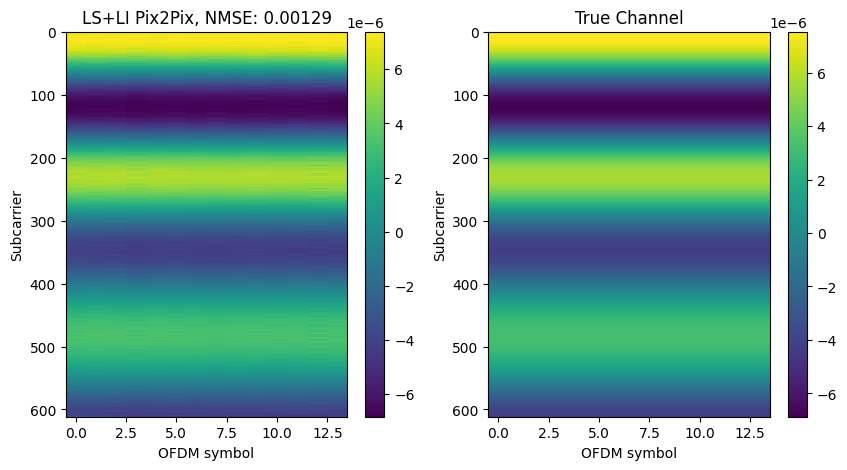

In [19]:
import matplotlib.pyplot as plt
i = 0 # epoch index

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(H_GAN_val_denormd[i,0,:,:].cpu(),  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title(f'LS+LI Pix2Pix, NMSE: {nmse_GAN_iSNR[i]:.5f}')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(valLabels[i,0,:,:].cpu(),  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title(f'True Channel')
plt.colorbar()

plt.show()

In [13]:
# from scipy.io import loadmat
# data = loadmat(save_folder_model+'/0dB/GAN_1_variable.mat')
# print(data)

In [14]:
# from scipy.io import loadmat
# data = loadmat('../../model/static/GAN/BS16/3500_3516/ver5_nmse.mat')
# print(data)

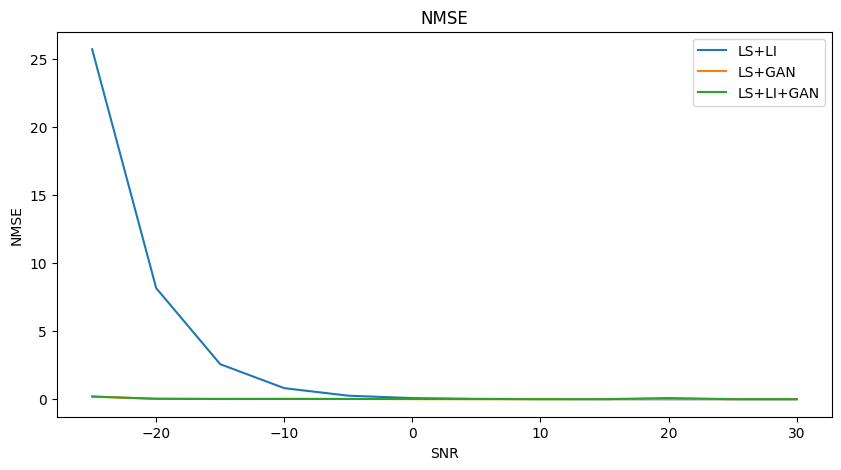

In [15]:
# 'nmse_LS_LI_val':nmse_LS_LI_val, 'nmse_LS_GAN_val':nmse_LS_GAN_val, 
#                                         'nmse_LI_GAN_val':nmse_LI_GAN_val
plt.figure(figsize=(10, 5))
plt.plot(SNR, nmse_LS_LI_val, label='LS+LI')
plt.plot(SNR, nmse_LS_GAN_val, label='LS+GAN')
plt.plot(SNR, nmse_LI_GAN_val, label='LS+LI+GAN')
plt.xlabel('SNR')
plt.ylabel('NMSE')
plt.title(f'NMSE')
plt.legend()

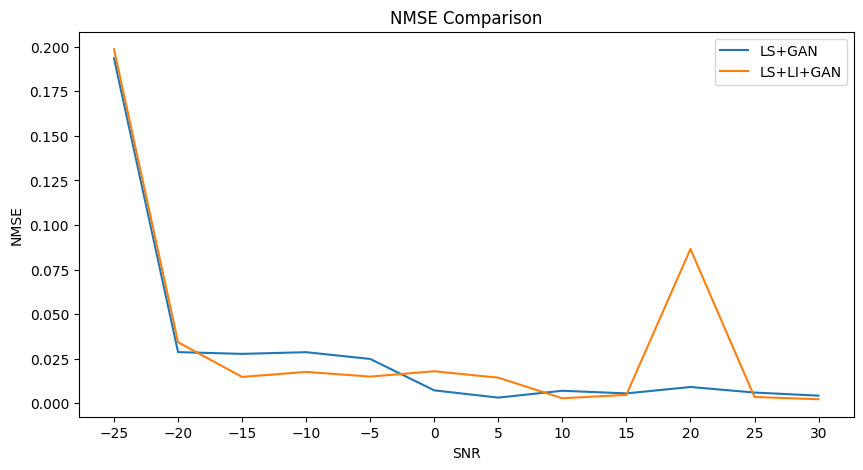

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(SNR, nmse_LS_GAN_val, label='LS+GAN')
plt.plot(SNR, nmse_LI_GAN_val, label='LS+LI+GAN')
plt.xticks(SNR)
plt.xlabel('SNR')
plt.ylabel('NMSE')
plt.title(f'NMSE Comparison')
plt.legend()

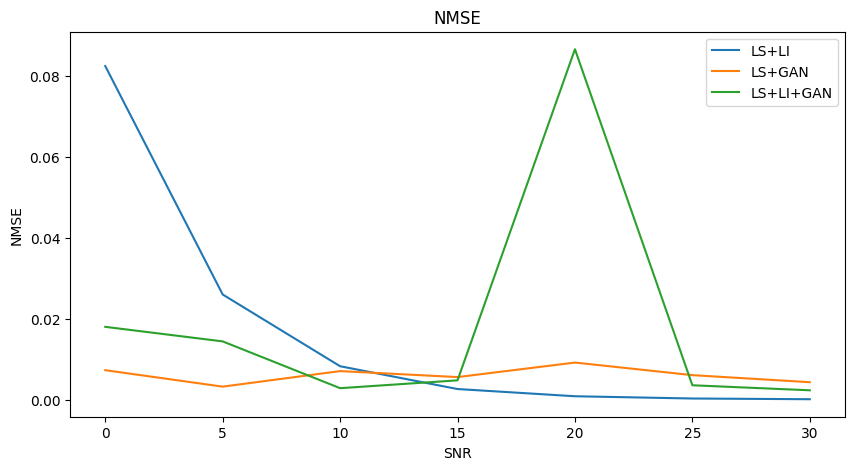

In [17]:
i=5
plt.figure(figsize=(10, 5))
plt.plot(SNR[i:], nmse_LS_LI_val[i:], label='LS+LI')
plt.plot(SNR[i:], nmse_LS_GAN_val[i:], label='LS+GAN')
plt.plot(SNR[i:], nmse_LI_GAN_val[i:], label='LS+LI+GAN')
plt.xlabel('SNR')
plt.ylabel('NMSE')
plt.title(f'NMSE')
plt.legend()

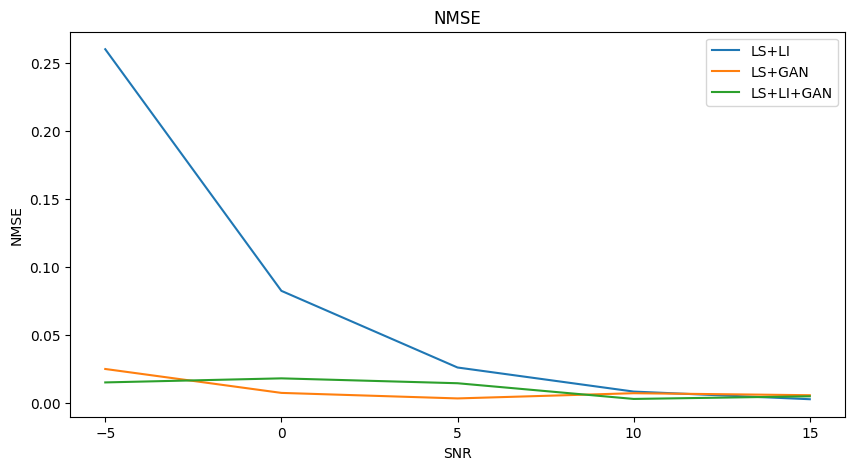

In [18]:
i=4
j=9
plt.figure(figsize=(10, 5))
plt.plot(SNR[i:j], nmse_LS_LI_val[i:j], label='LS+LI')
plt.plot(SNR[i:j], nmse_LS_GAN_val[i:j], label='LS+GAN')
plt.plot(SNR[i:j], nmse_LI_GAN_val[i:j], label='LS+LI+GAN')
plt.xticks(SNR[i:j])
plt.xlabel('SNR')
plt.ylabel('NMSE')
plt.title(f'NMSE')
plt.legend()